In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
from scipy.stats import ttest_ind
import implicit
import random
import torch
import torch.nn as nn
import scipy.sparse as sp
import networkx as nx
from node2vec import Node2Vec
import pickle
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="threadpoolctl") # To ignore a warning about threading which I have dealt with below by setting the thread limit to 1 but the warning still appears
import threadpoolctl
threadpoolctl.threadpool_limits(1, "blas")

# Data preparation:

Loading the original data:

In [207]:
# Load spotify playlists data
playlists = pd.read_csv("../Data/user_playlists.csv", on_bad_lines="skip")
# Rename columns
playlists.columns = ["user_id", "artist_name", "track_name", "playlist_name"]
# Drop rows with any missing data
playlists = playlists.dropna()

# Get list of tracks and artists in this data
playlists_tracks = playlists["track_name"].copy()
playlists_artists = playlists["artist_name"].copy()

In [208]:
# Load spotify song data
songs = pd.read_csv("../Data/song_data.csv")
# Drop duplicate song entries
songs = songs.drop_duplicates(subset=["track_name", "artist_name"])
# Rename ID column
songs.rename(columns={"id": "track_id"}, inplace=True)

# Get list of tracks and artists in this data
songs_tracks = songs["track_name"].copy()
songs_artists = songs["artist_name"].copy()

In [209]:
# Join the data by track name and artist name (case insensitive)
valid_data = playlists.merge(songs, left_on=[playlists_tracks.str.lower(), playlists_artists.str.lower()], right_on=[songs_tracks.str.lower(), songs_artists.str.lower()])
valid_data.drop(["key_0", "key_1", "track_name_x", "artist_name_x"], axis=1, inplace=True)
valid_data.rename(columns={"track_name_y" : "track_name", "artist_name_y" : "artist_name"}, inplace=True)

Creating demo user:

In [210]:
# Create synthetic data for demonstration
my_rap_song_ids = ["7uWVT3UkCAZyANvv0bdyQn", "6REbwUNlppTfcnV4d4ZoZi", "5DO1SazQppcsKQ1c1JpyQz", "4Pwjz3DfvfQWV0rO2V8jyh", "3q2v8QaTnHLveAQzR6gvYm", "2HbKqm4o0w5wEeEFXm2sD4", "1zCi4cVFqe6ja16MeGZKRN", "1UGD3lW3tDmgZfAVDh6w7r", "7EzY5a2CMrK5KqCxoOeyIj", "0ua0Go4NN4Td7l0Zre6Ce3", "1XQhZctQWzkznclbmbE7FQ", "1pHmmvnRsCqI56r8NZecvq", "1fLdeDTrJWNkwOeFyAVLvF", "22L7bfCiAkJo5xGSQgmiIO", "2FgkwIXC52sHCbqVL8jE41", "2Im64pIz6m0EJKdUe6eZ8r", "2d5NhldpaetRQBVbNveDkK", "2gZUPNdnz5Y45eiGxpHGSc", "2rT6jwkyUcz6cmDWZGbGjC", "3DK6m7It6Pw857FcQftMds", "3sNVsP50132BTNlImLx70i", "07NI6CCv57IbIqzy10ddd7", "26RcjBcThMrZ8KvsqApOvN", "4gkl7QbQvBd3TM9PhlWFkI", "62vpWI1CHwFy7tMIcSStl8", "7FOJvA3PxiIU0DN3JjQ7jT", "05VHidqx1tV6V7MsCdAIby", "1Nso7C8d7pW3SRM7AI0FyV", "1XHK0mjgx9xMvoGiFn6jF8", "3lPAHV0b53zgRRm9LBgnTY", "6MmT9hje2krkn1twcmtBYu", "0m1KYWlT6LhFRBDVq9UNx4", "10VBBaul4zVD0reteuIHM2", "1HDaPtZuixue2q6VGNRdVO", "1OHoBC4icbuNhpSxP400sv", "1QBwk6GTCxVdC2hoSw9tlM", "1pF5hkdEGJv8xzLTvhy3PF", "2YaDRtIlQiZ5WDDB2YuEOC", "31Q9ZTF9x81BDonlObCbvP", "3fyMH1t6UPeR5croea9PrR", "5jNrszQHRIVKmS9Ptb63pe", "1fb6b2Mas9q2mWxJazzeRI", "2UB0VoGZSBReyPdTBQi6z6", "7yPGXCaeIr1ofJoqp3LeKF", "25kGNSv0yGXZKaC79xzrvg"]
my_rnb_song_ids = valid_data[valid_data["artist_name"] == "Frank Ocean"]["track_id"].unique().tolist()[:-3]
my_rnb_song_ids += ["3QPKkP40zmc6xBtJMrXSNi", "46CA1H0T1r7u5lDUtVveAh", "16NGfNtshNVSKkf5szmGwx", "2KMCM2dirSnthfYKNjS8iT", "6olUplztLFFfU7fMYmFXOP", "2ekdnv2xVIyAdG3ySoDDeY", "0EHR9OObFtjlhQB8wSt1m7", "6NKtO7hYNDtjGFXE858qEk", "047fCsbO4NdmwCBn8pcUXl", "124NFj84ppZ5pAxTuVQYCQ", "6jdOi5U5LBzQrc4c1VT983", "6kIh5c8x8vzOe6OKW1X59U"]
my_user_ids = pd.Series(["me"]*(len(my_rap_song_ids) + len(my_rnb_song_ids)), name="user_id")
my_playlist_names = pd.Series(["rap"]*len(my_rap_song_ids) + ["chill"]*len(my_rnb_song_ids), name="playlist_name")
my_track_ids = pd.Series(my_rap_song_ids + my_rnb_song_ids, name="track_id")
my_data = pd.concat([my_user_ids, my_playlist_names, my_track_ids], axis=1)
my_data = my_data.merge(songs)

In [225]:
# The test user is a fan of rap and r&b music
my_data["artist_name"].value_counts()

artist_name
Kanye West            14
Drake                 13
Frank Ocean           10
Kendrick Lamar         7
J. Cole                5
JAY Z                  5
Childish Gambino       3
Joey Bada$$            2
Mac Miller             2
Tyler, The Creator     2
Lil Wayne              2
MF DOOM                1
PARTYNEXTDOOR          1
Name: count, dtype: int64

Creating the 25,000 entry dataset:

In [10]:
# Group the data by each playlist
valid_data_counts = valid_data.groupby(["user_id", "playlist_name"]).apply(lambda rows : rows.index).reset_index().rename(columns={0:"indices"})
# Get total number of playlists
num_playlists = len(valid_data_counts)

# Select random playlists until we reach 25,000 user-song interactions
total = 0 # Total no. user-song interactions
indices = [] # Indices of interactions to include in subset
i = 0
playlists_shuffled = list(range(num_playlists))
random.seed(20) # Set seed so we get exactly 25,000 interactions
random.shuffle(playlists_shuffled)
while total < 24995:
    # Get playlist index in valid_data
    index = playlists_shuffled[i]
    # Get indices of playlist songs
    playlist_songs = valid_data_counts.iloc[index, 2].tolist()
    # Only include playlists with at least 5 unique songs
    if len(valid_data.iloc[playlist_songs, :].drop_duplicates()) >= 5:
        total += len(playlist_songs)
        indices += list(playlist_songs)
    i += 1
# We now have a subset of 25,000 user-song interactions
valid_data_subset_25k = valid_data.iloc[indices, :].reset_index(drop=True)

Creating the 50,000 entry dataset:

In [11]:
# Select random playlists until we reach 50,000 user-song interactions
total = 0 # Total no. user-song interactions
indices = [] # Indices of interactions to include in subset
i = 0
playlists_shuffled = list(range(num_playlists))
random.seed(7) # Set seed so we get exactly 50,000 interactions
random.shuffle(playlists_shuffled)
while total < 49995:
    # Get playlist index in valid_data
    index = playlists_shuffled[i]
    # Get indices of playlist songs
    playlist_songs = valid_data_counts.iloc[index, 2]
    # Only include playlists with at least 5 unique songs
    if len(valid_data.iloc[playlist_songs, :].drop_duplicates()) >= 5:
        total += len(playlist_songs)
        indices += list(playlist_songs)
    i += 1
# We now have a subset of 50,000 user-song interactions
valid_data_subset_50k = valid_data.iloc[indices, :].reset_index(drop=True)

Creating the 100,000 entry dataset:

In [12]:
# Select random playlists until we reach 99,933 user-song interactions (since we have 67 synthetic to add)
total = 0 # Total no. user-song interactions
indices = [] # Indices of interactions to include in subset
i = 0
playlists_shuffled = list(range(num_playlists))
random.seed(17) # Set seed so we get exactly 100,000 interactions
random.shuffle(playlists_shuffled)
while total < 99933:
    # Get playlist index in valid_data
    index = playlists_shuffled[i]
    # Get indices of playlist songs
    playlist_songs = valid_data_counts.iloc[index, 2]
    # Only include playlists with at least 5 unique songs
    if len(valid_data.iloc[playlist_songs, :].drop_duplicates()) >= 5:
        total += len(playlist_songs)
        indices += list(playlist_songs)
    i += 1
# We now have a subset of 100,000 user-song interactions
valid_data_subset_100k = valid_data.iloc[indices, :].reset_index(drop=True)
# Add my synthetic data to the subset
valid_data_subset_100k = pd.concat([valid_data_subset_100k, my_data], axis=0)

In [13]:
# Display info about each subset and the original data
print(len(valid_data_subset_25k), "user-song interaction subset has")
print(valid_data_subset_25k["user_id"].nunique(), "users")
print(valid_data_subset_25k["track_id"].nunique(), "songs\n")

print(len(valid_data_subset_50k), "user-song interaction subset has")
print(valid_data_subset_50k["user_id"].nunique(), "users")
print(valid_data_subset_50k["track_id"].nunique(), "songs\n")

print(len(valid_data_subset_100k), "user-song interaction subset has")
print(valid_data_subset_100k["user_id"].nunique(), "users")
print(valid_data_subset_100k["track_id"].nunique(), "songs\n")

print("Full data has")
print(len(valid_data), "user-song interactions")
print(valid_data["user_id"].nunique(), "users")
print(valid_data["track_id"].nunique(), "songs")

25000 user-song interaction subset has
845 users
9555 songs

50000 user-song interaction subset has
1660 users
11907 songs

100000 user-song interaction subset has
3060 users
14757 songs

Full data has
2213379 user-song interactions
14958 users
22283 songs


In [ ]:
# Create csv files for the data subsets
valid_data_subset_25k.to_csv("../Data/combined_data_25k.csv", index=False)
valid_data_subset_50k.to_csv("../Data/combined_data_50k.csv", index=False)
valid_data_subset_100k.to_csv("../Data/combined_data_100k.csv", index=False)

In [3]:
random.seed(0) # For reproducibility

# Loading the data:

In [227]:
def load_data(dataset_file_name):
    """
    Function to load the data required for the recommender given the file name of the dataset.
    Params:
    - string dataset_file_name: the name of the dataset file including its extension
    Return:
    - songs_data: a pandas dataframe for the song content
    - interactions_data: a pandas dataframe for the user-song interactions
    """
    # Load data
    data = pd.read_csv(f"../Data/{dataset_file_name}")

    # Separate the data into song content and interactions data
    songs_data = data.groupby("track_id", as_index=False).first().drop(columns=["user_id", "playlist_name"])
    interactions_data = data[["user_id", "track_id", "playlist_name"]]

    return songs_data, interactions_data


In [228]:
# Load data for 25,000 dataset
songs_data_25k, interactions_data_25k = load_data("combined_data_25k.csv")

# Load data for 50,000 dataset
songs_data_50k, interactions_data_50k = load_data("combined_data_50k.csv")

# Load data for 100,000 dataset
songs_data_100k, interactions_data_100k = load_data("combined_data_100k.csv")

In [81]:
# Show some data
songs_data_100k.head()

,track_id,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_pop,artist_pop,genres_list
0,00BuKLSAFkaEkaVAgIMbeA,Telephone,Lady Gaga,0.825,0.8320,5,-5.853,0,0.0403,0.00587,0.000789,0.114,0.7130,122.021,0,87,"['art_pop', 'dance_pop', 'pop']"
1,00CmjeeHvAVKvx3tcIiZTy,Two Lovers,Mary Wells,0.678,0.4050,2,-16.965,1,0.0304,0.42600,0.000000,0.109,0.9600,105.902,50,54,"['brill_building_pop', 'classic_soul', 'motown..."
2,00FROhC5g4iJdax5US8jRr,Satisfy You,Diddy,0.764,0.5940,6,-10.050,1,0.1850,0.59100,0.000000,0.145,0.6950,87.261,56,75,"['dance_pop', 'east_coast_hip_hop', 'hip_hop',..."
3,00Hi29G5h1ZHuHn78KvHnm,Food Is Still Hot,Karen O And The Kids,0.323,0.0547,5,-20.179,1,0.0443,0.98100,0.906000,0.122,0.0587,176.403,0,0,['unknown']
4,00Jiy2HCQrpELyLXSI6YpW,Gangster Blues,Mattafix,0.561,0.6650,7,-7.600,0,0.1670,0.02310,0.167000,0.120,0.3910,158.974,44,53,['reggae_fusion']


In [82]:
# Show some data
interactions_data_100k.head()

,user_id,track_id,playlist_name
0,9ed1a44b1166f56cd9ad834581090a9c,3piY5aMfwEEmXMV6I9kpoi,covers
1,9ed1a44b1166f56cd9ad834581090a9c,7xhhhqWgqM0tf5IaEc9Bwt,covers
2,9ed1a44b1166f56cd9ad834581090a9c,2xD7RvKFJl52xyds3wQFXQ,covers
3,9ed1a44b1166f56cd9ad834581090a9c,1OutzYv6YiN93lrT3pJsWR,covers
4,9ed1a44b1166f56cd9ad834581090a9c,7LR87BxVS5GawUHQFJdko5,covers


# Data Splitting:

In [229]:
def split_data(interactions_data):
    """
    Function to split the interactions data into 5 train/test splits using 5-fold cross validation.
    Params:
    - interactions_data: a pandas dataframe for the user-song interactions
    Return:
    - cross_validation: a 2D list containing the 5 train/test splits
    """
    # Create folds for 5-fold cross validation
    folds = StratifiedKFold(5, shuffle=True, random_state=0)

    # Get user, song pairs that indicate that a user has interacted with the song (binarizes the interactions data)
    interactions = interactions_data.groupby(["user_id", "track_id"], as_index=False).size().drop(columns=["size"])

    # Create train/test splits using 5-fold cross validation stratified by user ID

    # Initialise list to store train/test splits
    cross_validation = []

    # Iterate through each split
    for train_index, test_index in folds.split(interactions, interactions["user_id"]):
        # Get train and test interactions
        train_i, test_i = interactions.iloc[train_index, :], interactions.iloc[test_index, :]

        # Merge the train and test interactions with the original interactions data to add the playlist names to the data
        train_i = train_i.merge(interactions_data).set_index("user_id")
        test_i = test_i.merge(interactions_data).set_index("user_id")

        # Add train/test split to list
        cross_validation.append([train_i, test_i])

    return cross_validation

In [230]:
# Split 25,000 dataset
cross_validation_25k = split_data(interactions_data_25k)

# Split 50,000 dataset
cross_validation_50k = split_data(interactions_data_50k)

# Split 100,000 dataset
cross_validation_100k = split_data(interactions_data_100k)

# Evaluation Function:

In [231]:
def evaluate_model(model):
    """
    Function to calculate recall@k and novelty@k for a recommender system for k = 5, 10, and 20.
    Params:
    - model: a recommender system model
    Return:
    - eval_data: a pandas dataframe containing recall and novelty data for every user
    """
    # Get 20 recommendations for all users
    recommendations = model.get_k_recommendations_all_users(20)

    # Get list of all user IDs and the number of users
    user_ids = model.all_user_ids
    n = len(user_ids)

    # Get proportion of users who have interacted with each song
    interactions_data = pd.concat([model.interactions_train, model.interactions_test], axis=0)
    prop_interaction = interactions_data.groupby("track_id").apply(lambda x: x.index.nunique() / n)

    # Create list to store evaluation data for each user
    eval_data = []

    # For each user
    for i in range(n):
        # Get user ID
        user_id = user_ids[i]

        # Get user test interactions
        user_test_interactions = model.interactions_test.loc[[user_id], "track_id"]

        # Count number of test interactions that appear in user recommendations
        hits_at_5 = np.sum(user_test_interactions.isin(recommendations[i]["track_id"][:5]))
        hits_at_10 = np.sum(user_test_interactions.isin(recommendations[i]["track_id"][:10]))
        hits_at_20 = np.sum(user_test_interactions.isin(recommendations[i]["track_id"]))

        # Calculate recall@k for user
        num_user_test_interactions = len(user_test_interactions)
        recall_at_5 = hits_at_5 / num_user_test_interactions
        recall_at_10 = hits_at_10 / num_user_test_interactions
        recall_at_20 = hits_at_20 / num_user_test_interactions

        # Calculate maximum recall@k for user (may be less than 1)
        max_recall_at_5 = min(5, num_user_test_interactions) / num_user_test_interactions
        max_recall_at_10 = min(10, num_user_test_interactions) / num_user_test_interactions
        max_recall_at_20 = min(20, num_user_test_interactions) / num_user_test_interactions

        # Calculate normalised recall@k for user
        norm_recall_at_5 = recall_at_5 / max_recall_at_5
        norm_recall_at_10 = recall_at_10 / max_recall_at_10
        norm_recall_at_20 = recall_at_20 / max_recall_at_20

        # Get the novelty of the set of user recommendations
        novelty_at_5 = -np.log2(prop_interaction.loc[recommendations[i]["track_id"][:5]]).sum() / 5
        novelty_at_10 = -np.log2(prop_interaction.loc[recommendations[i]["track_id"][:10]]).sum() / 10
        novelty_at_20 = -np.log2(prop_interaction.loc[recommendations[i]["track_id"]]).sum() / 20

        # Add user evaluation data to list
        eval_data.append([user_id, recall_at_5, recall_at_10, recall_at_20, max_recall_at_5, max_recall_at_10, max_recall_at_20, norm_recall_at_5, norm_recall_at_10, norm_recall_at_20, hits_at_5, hits_at_10, hits_at_20, num_user_test_interactions, novelty_at_5, novelty_at_10, novelty_at_20])
    
    # Convert evaluation data to a dataframe
    eval_data = pd.DataFrame(eval_data, columns=["user_id", "recall@5", "recall@10", "recall@20", "max recall@5", "max recall@10", "max recall@20", "normalised recall@5", "normalised recall@10", "normalised recall@20", "hit count@5", "hit count@10", "hit count@20", "no. test interactions", "novelty@5", "novelty@10", "novelty@20"])
    
    return eval_data

# RS1:

# CBF:

Pre-processing functions:

In [232]:
def space_tokenizer(text):
    """
    Function to tokenize text using spaces as the only delimiter.
    Params:
    - string text
    Return:
    - tokens: a list of tokens in the text
    """
    tokens = text.split()
    return tokens

"""
[8]
Title: Content-based Filtering Spotify Song Recommendation System
Author: Eric Chang
Date: 2021
Code version: Commit "update secret.txt", Dec. 17, 2021
Availability: https://github.com/enjuichang/PracticalDataScience-ENCA/blob/main/notebooks/content_based_recsys.ipynb
"""
def cbf_pre_processing(songs_original):
    """
    Function to perform pre processing on the song content.
    Params:
    - songs_original: a pandas dataframe containing song content
    Return:
    - songs: a pandas dataframe containing the transformed song content
    """
    songs = songs_original.copy()

    # One-hot encode the key column
    ohe_key = pd.get_dummies(songs.pop("key"))
    ohe_key.columns = ["key_" + str(k) for k in ohe_key.columns]  # Rename columns
    songs = pd.concat([songs, ohe_key], axis=1)  # Replace original key column

    # Min-max scale to get values in same range (0-1)
    cols_to_scale = ["loudness", "tempo"]
    mm_scaler = MinMaxScaler()
    songs[cols_to_scale] = mm_scaler.fit_transform(songs[cols_to_scale])

    # TF-IDF to turn genre lists to vectors
    tf_idf = TfidfVectorizer(tokenizer=space_tokenizer, token_pattern=None)
    tf_idf_genres = tf_idf.fit_transform(songs.pop("genres_list").apply(lambda x: " ".join(eval(x))))
    genres = pd.DataFrame(tf_idf_genres.toarray())
    # Rename columns
    genres.columns = ["genre_" + g for g in tf_idf.get_feature_names_out()]
    # Replace original genre list column
    songs = pd.concat([songs, genres], axis=1)

    # TF-IDF to turn artist names to vectors
    tf_idf_artists = tf_idf.fit_transform(songs.pop("artist_name").apply(lambda x: x.replace(" ", "_")))
    artists = pd.DataFrame(tf_idf_artists.toarray())
    # Rename columns
    artists.columns = ["artist_" + a for a in tf_idf.get_feature_names_out()]
    # Replace original artist name column
    songs = pd.concat([songs, artists], axis=1)

    # Drop columns to not include in song profiles
    songs.drop(columns=["track_name", "track_pop", "artist_pop"], inplace=True)

    return songs

In [91]:
# Demo of the pre-processing
cbf_pre_processing(songs_data_25k).head()

,track_id,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,artist_ziggy_marley,artist_zion_&_lennox,artist_zion_i,artist_zola_jesus,artist_zombie_nation,artist_zomby,artist_zoé,artist_zz_top,artist_ásgeir,artist_ólafur_arnalds
0,00BuKLSAFkaEkaVAgIMbeA,0.825,0.832,0.850823,0,0.0403,0.005870,0.000789,0.1140,0.713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00DlEKhhlQNtjnJk7xqB9O,0.500,0.890,0.892192,0,0.0420,0.000404,0.000000,0.0850,0.360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00FROhC5g4iJdax5US8jRr,0.764,0.594,0.752117,1,0.1850,0.591000,0.000000,0.1450,0.695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00LfFm08VWeZwB0Zlm24AT,0.662,0.748,0.916957,0,0.2680,0.688000,0.000008,0.0841,0.535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00NUqFMIpCsrYPbM9YpVHQ,0.504,0.856,0.870320,0,0.2860,0.011400,0.000000,0.2560,0.335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Model:

In [233]:
class ContentBasedFilter:
    """
    Class to produce content-based recommendations.
    """
    def __init__(self, interactions_train, interactions_test, songs_data, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight):
        """
        Params:
        - interactions_train: a pandas dataframe containing the training interactions
        - interactions_test: a pandas dataframe containing the test interactions (None if no test interactions)
        - songs_data: a pandas dataframe containing the content for all songs
        - float key_weight: a value between 0 and 1 to multiply the key columns by to adjust their weighting in the recommendations
        - float mode_weight: "                                    " mode column by to adjust its weighting in the recommendations
        - float loud_tempo_weight: "                              " loudness and tempo columns by to adjust their weighting in the recommendations
        - float genre_weight: "                                   " genre columns by "                "
        - float artist_weight: "                                  " artist columns by "                "
        """
        # Load data into class variables
        self.interactions_train = interactions_train
        self.interactions_test = interactions_test
        self.songs_data = songs_data
        self.key_weight = key_weight
        self.mode_weight = mode_weight
        self.loud_tempo_weight = loud_tempo_weight
        self.genre_weight = genre_weight
        self.artist_weight = artist_weight

        # Adjust weighting of key columns
        key_columns = [col for col in self.songs_data.columns if col[:3] == "key"]
        self.songs_data[key_columns] *= self.key_weight

        # Adjust weighting of mode column
        self.songs_data["mode"] *= self.mode_weight

        # Adjust weighting of columns that were min-max scaled
        scaled_columns = ["loudness", "tempo"]
        self.songs_data[scaled_columns] *= self.loud_tempo_weight

        # Adjust weighting of genre columns
        genre_columns = [col for col in self.songs_data.columns if col[:5] == "genre"]
        self.songs_data[genre_columns] *= self.genre_weight

        # Adjust weighting of artist columns
        artist_columns = [col for col in self.songs_data.columns if col[:6] == "artist"]
        self.songs_data[artist_columns] *= self.artist_weight
        
        # Turn song content to song profiles
        self.all_song_profiles = self.songs_data.set_index("track_id")

        # Get all song IDs
        self.all_track_ids = self.all_song_profiles.index

        # Create dictionary class variable to map between song ID and row number of song profile
        self.track_id_map = dict(zip(self.all_track_ids, range(len(self.all_song_profiles))))

        # Create user profiles by taking the mean profile of all songs a user has interacted with
        song_profiles_sparse = csr_matrix(self.all_song_profiles) # Use sparse matrix to speed up computation
        self.all_user_profiles = self.interactions_train.groupby(self.interactions_train.index).apply(lambda x : np.asarray(song_profiles_sparse[[self.track_id_map[y] for y in x["track_id"]], :].mean(axis=0)).flatten()).apply(pd.Series)
        self.all_user_profiles.columns = self.all_song_profiles.columns

        # Get all user IDs
        self.all_user_ids = self.all_user_profiles.index

        # Create a dataframe to indicate which songs each user has interacted with in the training data
        interaction_counts = self.interactions_train.groupby(["user_id", "track_id"], as_index=False).size()
        self.training_songs = interaction_counts.groupby("user_id").apply(lambda x: x["track_id"].tolist()).to_frame(name="track_ids")
        self.training_songs["indices"] = self.training_songs["track_ids"].apply(lambda ids: [self.track_id_map[id] for id in ids])

        # Create a dataframe to indicate which songs each user hasn't interacted with in the training data
        self.non_training_songs = self.training_songs.copy()
        self.non_training_songs["track_ids"] = self.non_training_songs["track_ids"].apply(lambda x: list(set(self.all_track_ids) - set(x))).to_frame(name="track_ids")
        self.non_training_songs["indices"] = self.non_training_songs["track_ids"].apply(lambda ids: [self.track_id_map[id] for id in ids])

        # Create min-max scaler to scale scores
        self.mm_scaler = MinMaxScaler()

    """
    [9]
    Title: Recommender Systems in Python 101
    Author: Gabriel Moreira
    Date: 2020
    Code version: 4
    Availability: https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101
    """
    def get_k_recommendations_all_users(self, k=10):
        """
        Function to get k recommendations for each user.
        Params:
        - int k: the number of recommendations
        Return:
        - recommendations: a list of recommendations for each user, where each recommendation is a pandas dataframe with columns track ID, score
        """
        # Get the cosine similarity between every user profile and every song
        cosine_similarities_matrix = cosine_similarity(self.all_user_profiles, csr_matrix(self.all_song_profiles))

        # Initialise list to store lists of recommendations
        recommendations = []

        # For each user
        for i, cosine_similarities_row in enumerate(cosine_similarities_matrix):
            # "Filter out" songs already interacted with by setting their similarities to 0
            indices_for_songs_already_interacted_with = self.training_songs.iloc[i, 1]
            cosine_similarities_row[indices_for_songs_already_interacted_with] = np.zeros(len(indices_for_songs_already_interacted_with))

            # Get the indices of the k most similar songs to the user profile in descending order
            similar_indices = cosine_similarities_row.argsort()[-k:][::-1]

            # Get a list of tuples containing these songs' IDs and similarity values
            similar_items = [(self.all_track_ids[i], cosine_similarities_row[i]) for i in similar_indices]

            # Convert this to a dataframe
            user_recommendations = pd.DataFrame(similar_items, columns=["track_id", "score"])

            # Add the recommendations to the global recommendations list
            recommendations.append(user_recommendations)
 
        return recommendations
    

    def get_k_recommendations(self, user_profile, song_profiles, k=10):
        """
        Function to get k recommendations for a particular user given their user profile and a set of songs that can be recommended.
        Params:
        - user_profile: a pandas dataframe for the user profile
        - song_profiles: a pandas dataframe containing song profiles for the songs that can be recommended to this user
        - int k: number of recommendations
        Return:
        - recommendations: a pandas dataframe with columns track ID, score
        """
        # Get the cosine similarity between the user profile and each song
        cosine_similarities = cosine_similarity(user_profile, csr_matrix(song_profiles)).flatten()

        # Get the indices of the k most similar songs to the user profile in descending order
        similar_indices = cosine_similarities.argsort()[-k:][::-1]

        # Get a list of tuples containing these songs' IDs and similarity values
        all_user_track_ids = song_profiles.index
        similar_items = [(all_user_track_ids[i], cosine_similarities[i]) for i in similar_indices]

        # Convert this to a dataframe
        recommendations = pd.DataFrame(similar_items, columns=["track_id", "score"])
        
        return recommendations

    
    def rank_items_all_users(self):
        """
        Function to rank every song that each user hasn't interacted with based on their similarity score.
        Used for the hybrid system.
        Return:
        - rankings: a list of rankings for each user, where each ranking is a pandas dataframe with columns track ID, score
        """
        # Get the cosine similarity between every user profile and every song
        cosine_similarities_matrix = cosine_similarity(self.all_user_profiles, csr_matrix(self.all_song_profiles))

        # Initialise list to store rankings for each user
        rankings = []

        # For each user
        for i, cosine_similarities_row in enumerate(cosine_similarities_matrix):
            # "Filter out" songs already interacted with by setting their similarities to 0
            indices_for_songs_already_interacted_with = self.training_songs.iloc[i, 1]
            cosine_similarities_row[indices_for_songs_already_interacted_with] = np.zeros(len(indices_for_songs_already_interacted_with))

            # Get the indices of the songs in descending order of similarity to the user profile
            similar_indices = cosine_similarities_row.argsort()[::-1]

            # Get a list of tuples containing these songs' IDs and similarity values
            similar_items = [(self.all_track_ids[i], cosine_similarities_row[i]) for i in similar_indices]

            # Convert this to a dataframe
            user_rankings = pd.DataFrame(similar_items, columns=["track_id", "score"])

            # Min-max scale the scores so they are in the range 0-1
            user_rankings.loc[:, "score"] = self.mm_scaler.fit_transform(user_rankings[["score"]])

            # Add the rankings to the global rankings list
            rankings.append(user_rankings)
 
        return rankings
    

    def rank_items(self, user_profile, song_profiles):
        """
        Function to rank a set of songs for a particular user given their user profile.
        Used for the hybrid system.
        Params:
        - user_profile: a pandas dataframe for the user profile
        - song_profiles: a pandas dataframe containing song profiles for the songs to rank for the user
        Return:
        - rankings: a pandas dataframe with columns track ID, score
        """
        # Get the cosine similarity between the user profile and each song
        cosine_similarities = cosine_similarity(user_profile, csr_matrix(song_profiles)).flatten()
        
        # Get the indices of the songs in descending order of similarity to the user profile
        ranked_indices = cosine_similarities.argsort()[::-1]

        # Get a list of tuples containing these songs' IDs and similarity values
        all_user_track_ids = song_profiles.index
        ranked_items = [(all_user_track_ids[i], cosine_similarities[i]) for i in ranked_indices]

        # Convert this to a dataframe
        rankings = pd.DataFrame(ranked_items, columns=["track_id", "score"])

        # Min-max scale the scores so they are in the range 0-1
        rankings.loc[:, "score"] = self.mm_scaler.fit_transform(rankings[["score"]])
        
        return rankings

### CBF Evaluation:

In [142]:
def cbf_evaluation(cross_validation, songs_data, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight):
    """
    Function to perform the evaluation on the CBF model.
    Params:
    - cross_validation: a 2D list of train/test splits
    - songs_data: a pandas dataframe containing the content for all songs
    - float key_weight: a value between 0 and 1 to multiply the key columns by to adjust their weighting in the recommendations
    - float mode_weight: "                                    " mode column by to adjust its weighting in the recommendations
    - float loud_tempo_weight: "                              " loudness and tempo columns by to adjust their weighting in the recommendations
    - float genre_weight: "                                   " genre columns by "                "
    - float artist_weight: "                                  " artist columns by "                "
    """
    evals = []
    # For each fold
    for i, cv_set in enumerate(cross_validation):
        cbf = ContentBasedFilter(cv_set[0], cv_set[1], songs_data, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight)
        # Evaluate model
        e = evaluate_model(cbf)
        evals.append(e)
        print(f"Fold {i+1}.")
        print("recall@5:", np.mean(e["normalised recall@5"]), "\trecall@10:", np.mean(e["normalised recall@10"]), "\trecall@20:", np.mean(e["normalised recall@20"]))
        print("novelty@5:", np.mean(e["novelty@5"]), "\tnovelty@10:", np.mean(e["novelty@10"]), "\tnovelty@20:", np.mean(e["novelty@20"]))
        print()

    # Get overall recall values
    overall_recall_at_5 = 0
    overall_recall_at_10 = 0
    overall_recall_at_20 = 0
    # Get overall novelty values
    overall_novelty_at_5 = 0
    overall_novelty_at_10 = 0
    overall_novelty_at_20 = 0
    for e in evals:
        overall_recall_at_5 += np.mean(e["normalised recall@5"])/5
        overall_recall_at_10 += np.mean(e["normalised recall@10"])/5
        overall_recall_at_20 += np.mean(e["normalised recall@20"])/5
        overall_novelty_at_5 += np.mean(e["novelty@5"])/5
        overall_novelty_at_10 += np.mean(e["novelty@10"])/5
        overall_novelty_at_20 += np.mean(e["novelty@20"])/5

    print("Overall recall@5:", overall_recall_at_5, "\tOverall recall@10:", overall_recall_at_10, "\tOverall recall@20:", overall_recall_at_20)
    print("Overall novelty@5:", overall_novelty_at_5, "\tOverall novelty@10:", overall_novelty_at_10, "\tOverall novelty@20:", overall_novelty_at_20)

In [259]:
# Initialise parameters
key_weight = 0.3
mode_weight = 0
loud_tempo_weight = 0.9
genre_weight = 0.7
artist_weight = 1

25,000 dataset:

In [48]:
# Perform pre-processing
transformed_songs_data_25k = cbf_pre_processing(songs_data_25k)
# Evaluate
cbf_evaluation(cross_validation_25k, transformed_songs_data_25k, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight)

Fold 1.
recall@5: 0.2503155818540434 	recall@10: 0.30637691368460596 	recall@20: 0.3509232159919594
novelty@5: 8.364564328380363 	novelty@10: 8.387959331367592 	novelty@20: 8.407386589321437

Fold 2.
recall@5: 0.24873767258382642 	recall@10: 0.2984155161078238 	recall@20: 0.3435934462030419
novelty@5: 8.379445251663846 	novelty@10: 8.390009460610019 	novelty@20: 8.425678905569521

Fold 3.
recall@5: 0.2459368836291913 	recall@10: 0.2866201746970978 	recall@20: 0.3347172331549107
novelty@5: 8.4074594025548 	novelty@10: 8.426240259663652 	novelty@20: 8.453757107909821

Fold 4.
recall@5: 0.2378698224852071 	recall@10: 0.2915966939043862 	recall@20: 0.332434148859305
novelty@5: 8.427364265034372 	novelty@10: 8.44573028012204 	novelty@20: 8.487738021024493

Fold 5.
recall@5: 0.2283826429980276 	recall@10: 0.28201653047806896 	recall@20: 0.3225810201018584
novelty@5: 8.440417394572815 	novelty@10: 8.463458777052095 	novelty@20: 8.512322676581872

Overall recall@5: 0.24224852071005915 	Overall

50,000 dataset:

In [49]:
# Perform pre-processing
transformed_songs_data_50k = cbf_pre_processing(songs_data_50k)
# Evaluate
cbf_evaluation(cross_validation_50k, transformed_songs_data_50k, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight)

Fold 1.
recall@5: 0.20714859437751001 	recall@10: 0.2627653471026965 	recall@20: 0.3236460737938087
novelty@5: 8.76236068580598 	novelty@10: 8.764683308444337 	novelty@20: 8.776182408354535

Fold 2.
recall@5: 0.19722891566265058 	recall@10: 0.2662401988908013 	recall@20: 0.3250347082703521
novelty@5: 8.775819251677175 	novelty@10: 8.782427641318245 	novelty@20: 8.807204477635526

Fold 3.
recall@5: 0.20646586345381526 	recall@10: 0.26398235800344233 	recall@20: 0.3148890885091882
novelty@5: 8.809880538808512 	novelty@10: 8.822931293008072 	novelty@20: 8.870433073228885

Fold 4.
recall@5: 0.20552208835341368 	recall@10: 0.25918316121629376 	recall@20: 0.3120815648577781
novelty@5: 8.815423795172014 	novelty@10: 8.858000840504031 	novelty@20: 8.930945739233506

Fold 5.
recall@5: 0.20024096385542167 	recall@10: 0.25396347293937654 	recall@20: 0.30408728394658957
novelty@5: 8.835402676351103 	novelty@10: 8.894249134617567 	novelty@20: 8.966733557389311

Overall recall@5: 0.20332128514056225

100,000 dataset:

In [18]:
# Perform pre-processing
transformed_songs_data_100k = cbf_pre_processing(songs_data_100k)
# Evaluate
cbf_evaluation(cross_validation_100k, transformed_songs_data_100k, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight)

Fold 1.
recall@5: 0.19419934640522876 	recall@10: 0.2594128021579002 	recall@20: 0.3124109708860134
novelty@5: 8.893285816642763 	novelty@10: 8.903515410837972 	novelty@20: 8.949083715341002

Fold 2.
recall@5: 0.19678104575163402 	recall@10: 0.25295557111733585 	recall@20: 0.31024820846081397
novelty@5: 8.905514033902334 	novelty@10: 8.934502065113353 	novelty@20: 8.986939576912654

Fold 3.
recall@5: 0.19677015250544658 	recall@10: 0.2510434173669468 	recall@20: 0.30444649612519004
novelty@5: 8.93266334815008 	novelty@10: 8.977021163744867 	novelty@20: 9.05051427354832

Fold 4.
recall@5: 0.19501633986928105 	recall@10: 0.24407485216308744 	recall@20: 0.29256770544495153
novelty@5: 8.989546096087617 	novelty@10: 9.037049104268197 	novelty@20: 9.104684093756791

Fold 5.
recall@5: 0.1960294117647059 	recall@10: 0.24584798734308538 	recall@20: 0.2993374060389024
novelty@5: 9.01223272126292 	novelty@10: 9.077338377062416 	novelty@20: 9.147326790748734

Overall recall@5: 0.19575925925925927 

In [ ]:
# Example of recommendations
cbf = ContentBasedFilter(interactions_data_100k.set_index("user_id"), None, transformed_songs_data_100k, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight)
# Get user profile
user_profile = cbf.all_user_profiles.loc[["me"], :]
# Get song profiles
user_non_interacted_songs = pd.Series(cbf.non_training_songs.loc["me", "track_ids"])
song_profiles = cbf.all_song_profiles.loc[user_non_interacted_songs, :]
cbf.get_k_recommendations(user_profile, song_profiles).merge(songs_data_100k)[["track_name", "artist_name"]]

,track_name,artist_name
0,10 Bands,Drake
1,The New Workout Plan,Kanye West
2,Jesus Walks,Kanye West
3,Addiction,Kanye West
4,Breathe In Breathe Out,Kanye West
5,Homecoming,Kanye West
6,Mercy.1,Kanye West
7,Worst Behavior,Drake
8,Get Em High,Kanye West
9,Touch The Sky,Kanye West


# CF:

Model:

In [143]:
class CollaborativeFilter:
    """
    Class to produce collaborative recommendations.
    """
    def __init__(self, interactions_train, interactions_test, interactions_data, model):
        """
        Params:
        - interactions_train: a pandas dataframe containing the training interactions
        - interactions_test: a pandas dataframe containing the test interactions (None if no test interactions)
        - interactions_data: a pandas dataframe containing all interactions
        - model: the collaborative filtering model to use
        """
        # Load data into class variables
        self.interactions_train = interactions_train
        self.interactions_test = interactions_test
        self.cf = model

        # Get dataframe containing (user, song, number of interactions) triples
        interaction_counts = interactions_data.groupby(["user_id", "track_id"], as_index=False).size()

        # Create the users x songs interactions matrix
        self.interactions_matrix = interaction_counts.pivot(index="user_id", columns="track_id", values="size").fillna(0)

        # Set any test interactions to 0
        if interactions_test is not None:
            for user_id, track_id in interactions_test["track_id"].items():
                self.interactions_matrix.at[user_id, track_id] = 0
            
        # Create a sparse version for faster computation
        self.interactions_matrix_sparse = csr_matrix(self.interactions_matrix)

        # Get list of row indices in the users x songs interactions matrix
        self.user_indices = range(self.interactions_matrix_sparse.get_shape()[0])

        # Create dictionaries to map from user/song IDs to the corresponding row/column index in the interactions matrix
        self.all_user_ids = self.interactions_matrix.index
        self.user_id_map = dict(zip(self.all_user_ids, self.user_indices))
        self.all_track_ids = self.interactions_matrix.columns
        self.reverse_track_id_map = dict(zip(range(len(self.all_track_ids)), self.all_track_ids))

        # Train model on interactions matrix
        self.cf.fit(self.interactions_matrix_sparse, show_progress=False)

        # Create min-max scaler to scale scores
        self.mm_scaler = MinMaxScaler()


    def get_k_recommendations_all_users(self, k=10):
        """
        Function to get k recommendations for each user.
        Params:
        - int k: the number of recommendations
        Return:
        - recommendations: a list of recommendations for each user, where each recommendation is a pandas dataframe with columns track ID, score
        """
        # Get recommendations from model (default behaviour is to ignore items already interacted with in training data)
        recommendations = self.cf.recommend(self.user_indices, self.interactions_matrix_sparse, k)
        
        # Reformat these to be a list of pandas dataframes
        recommendations = [pd.DataFrame(list(zip(*x)), columns=["track_id", "score"]) for x in zip(*recommendations)]
        
        # Convert song column numbers to track IDs
        for user_recs in recommendations:
            user_recs["track_id"] = user_recs["track_id"].apply(lambda id: self.reverse_track_id_map[id])
        
        return recommendations
    

    def get_k_recommendations(self, user_id, k=10, tracks_to_ignore=[]):
        """
        Function to get k recommendations for a particular user.
        Params:
        - string user_id: the user's unique ID
        - int k: number of recommendations
        - list tracks_to_ignore: a list of column numbers for songs that cannot be recommended based on user constraints
        Return:
        - recommendations: a pandas dataframe with columns track ID, score
        """
        # Get row number corresponding to user
        user_index = self.user_id_map[user_id]

        # Get recommendations from model
        if tracks_to_ignore == []:
            # Get recommendations as usual
            recommendations = self.cf.recommend(user_index, self.interactions_matrix_sparse.getrow(user_index), k)
        else:
            # Get recommendations but tell model to ignore additional songs based on user constraints
            recommendations = self.cf.recommend(user_index, self.interactions_matrix_sparse.getrow(user_index), k, filter_items=tracks_to_ignore)

        # Reformat to a pandas dataframe
        recommendations = pd.DataFrame(list(zip(*recommendations)), columns=["track_id", "score"])

        # Convert song column numbers to track IDs
        recommendations["track_id"] = recommendations["track_id"].apply(lambda id: self.reverse_track_id_map[id])
        
        return recommendations

    
    def rank_items_all_users(self):
        """
        Function to rank every song that each user hasn't interacted with based on their similarity score.
        Used for the hybrid system.
        Return:
        - rankings: a list of rankings for each user, where each ranking is a pandas dataframe with columns track ID, score
        """
        # Get number of songs
        num_songs = len(self.all_track_ids)

        # Get the set of rankings
        all_rankings = self.cf.recommend(self.user_indices, self.interactions_matrix_sparse, num_songs)
        
        # Concatenate all rankings to form one dataframe with columns track ID, score
        all_rankings = pd.DataFrame({"track_id": all_rankings[0].flatten(), "score": all_rankings[1].flatten()})
        
        # Convert song column numbers to track IDs
        all_rankings["track_id"] = all_rankings["track_id"].apply(lambda id: self.reverse_track_id_map[id])
        
        # Get the number of users and songs
        num_users, num_songs = self.interactions_matrix.shape
        
        # Reformat to list of rankings, where each ranking is a dataframe with columns track ID, score
        
        # Initialise list to store rankings for each user
        rankings = []

        # For each user
        for i in range(num_users):
            # Get rankings for songs they have not interacted with
            user_rankings = all_rankings.iloc[i*num_songs : (i+1)*num_songs - int(np.sum(self.interactions_matrix.iloc[i, :])), :]

            # Min-max scale the scores so they are in the range 0-1
            user_rankings.loc[:, "score"] = self.mm_scaler.fit_transform(user_rankings[["score"]])

            # Add the rankings to the global rankings list
            rankings.append(user_rankings)

        return rankings
    

    def rank_items(self, user_id, tracks_to_ignore=[]):
        """
        Function to rank the songs that a particular user hasn't interacted with in the training data.
        Params:
        - string user_id: the user's unique ID
        - list tracks_to_ignore: a list of column numbers for songs that cannot be recommended based on user constraints
        """
        # Get rankings for songs the user has not interacted with that fit the constraints
        rankings = self.get_k_recommendations(user_id, len(self.all_track_ids) - int(np.sum(self.interactions_matrix.loc[user_id, :])) - len(tracks_to_ignore), tracks_to_ignore)
        
        # Min-max scale the scores so they are in the range 0-1
        rankings.loc[:, "score"] = self.mm_scaler.fit_transform(rankings[["score"]])
        
        return rankings

### CF Evaluation:

In [262]:
def cf_evaluation(cross_validation, interactions_data, factors, regularisation, alpha):
    """
    Function to perform the evaluation on the CF model.
    Params:
    - cross_validation: a 2D list of train/test splits
    - interactions_data: a pandas dataframe containing the user-songs interactions
    - int factors: the number of latent factors for the model
    - int regularisation: the regularisation term for the model
    - int alpha: the value of alpha for the model
    """
    evals = []
    # For each fold
    for i, cv_set in enumerate(cross_validation):
        model_cf = implicit.als.AlternatingLeastSquares(factors, regularisation, alpha, random_state=0)
        cf = CollaborativeFilter(cv_set[0], cv_set[1], interactions_data, model_cf)
        # Evaluate model
        e = evaluate_model(cf)
        evals.append(e)
        print(f"Fold {i+1}.")
        print("recall@5:", np.mean(e["normalised recall@5"]), "\trecall@10:", np.mean(e["normalised recall@10"]), "\trecall@20:", np.mean(e["normalised recall@20"]))
        print("novelty@5:", np.mean(e["novelty@5"]), "\tnovelty@10:", np.mean(e["novelty@10"]), "\tnovelty@20:", np.mean(e["novelty@20"]))
        print()

    # Get overall recall values
    overall_recall_at_5 = 0
    overall_recall_at_10 = 0
    overall_recall_at_20 = 0
    # Get overall novelty values
    overall_novelty_at_5 = 0
    overall_novelty_at_10 = 0
    overall_novelty_at_20 = 0
    for e in evals:
        overall_recall_at_5 += np.mean(e["normalised recall@5"])/5
        overall_recall_at_10 += np.mean(e["normalised recall@10"])/5
        overall_recall_at_20 += np.mean(e["normalised recall@20"])/5
        overall_novelty_at_5 += np.mean(e["novelty@5"])/5
        overall_novelty_at_10 += np.mean(e["novelty@10"])/5
        overall_novelty_at_20 += np.mean(e["novelty@20"])/5

    print("Overall recall@5:", overall_recall_at_5, "\tOverall recall@10:", overall_recall_at_10, "\tOverall recall@20:", overall_recall_at_20)
    print("Overall novelty@5:", overall_novelty_at_5, "\tOverall novelty@10:", overall_novelty_at_10, "\tOverall novelty@20:", overall_novelty_at_20)

In [263]:
# Initialise parameters
factors = 240
regularisation = 0.01
alpha = 40

25,000 dataset:

In [15]:
cf_evaluation(cross_validation_25k, interactions_data_25k, factors, regularisation, alpha)

Fold 1.
recall@5: 0.15483234714003943 	recall@10: 0.17101296139757677 	recall@20: 0.20240711684388749
novelty@5: 8.180619452484283 	novelty@10: 8.14193824172694 	novelty@20: 8.085207503278381

Fold 2.
recall@5: 0.1449506903353057 	recall@10: 0.16848736733352115 	recall@20: 0.20346436107253696
novelty@5: 8.170359489126872 	novelty@10: 8.156461873286197 	novelty@20: 8.120327949924885

Fold 3.
recall@5: 0.14625246548323473 	recall@10: 0.16590917629379168 	recall@20: 0.19400007857873283
novelty@5: 8.17174247504877 	novelty@10: 8.155562893820996 	novelty@20: 8.109322229816376

Fold 4.
recall@5: 0.1473767258382643 	recall@10: 0.17087395510472433 	recall@20: 0.19424910392782777
novelty@5: 8.187851496923708 	novelty@10: 8.16743532287483 	novelty@20: 8.118521028633028

Fold 5.
recall@5: 0.14877712031558185 	recall@10: 0.1736991640837795 	recall@20: 0.19980750967309122
novelty@5: 8.173875076524233 	novelty@10: 8.126360417395594 	novelty@20: 8.080684247773299

Overall recall@5: 0.1484378698224852

50,000 dataset:

In [16]:
cf_evaluation(cross_validation_50k, interactions_data_50k, factors, regularisation, alpha)

Fold 1.
recall@5: 0.21269076305220883 	recall@10: 0.22602074966532798 	recall@20: 0.2604181625897281
novelty@5: 7.959594085780844 	novelty@10: 8.024171779168203 	novelty@20: 8.058547952766398

Fold 2.
recall@5: 0.2166265060240964 	recall@10: 0.23917838018741633 	recall@20: 0.2730751333196874
novelty@5: 7.956401231803296 	novelty@10: 8.021834785784765 	novelty@20: 8.064729240339348

Fold 3.
recall@5: 0.2116566265060241 	recall@10: 0.2345795085102314 	recall@20: 0.2605194517540185
novelty@5: 7.995242730186788 	novelty@10: 8.053202302404204 	novelty@20: 8.070441023867708

Fold 4.
recall@5: 0.22078313253012047 	recall@10: 0.23810025817555938 	recall@20: 0.2652621264914478
novelty@5: 7.987815157293964 	novelty@10: 8.060382407313647 	novelty@20: 8.075722143598528

Fold 5.
recall@5: 0.2112550200803213 	recall@10: 0.2414656244023714 	recall@20: 0.27303690314342055
novelty@5: 8.016031886987394 	novelty@10: 8.052182320330244 	novelty@20: 8.067693618488072

Overall recall@5: 0.2146024096385542 	O

100,000 dataset:

In [17]:
cf_evaluation(cross_validation_100k, interactions_data_100k, factors, regularisation, alpha)

Fold 1.
recall@5: 0.2880664488017429 	recall@10: 0.30640237576512086 	recall@20: 0.34024246960020643
novelty@5: 7.578755328990478 	novelty@10: 7.692916436996975 	novelty@20: 7.800391907750963

Fold 2.
recall@5: 0.2828322440087146 	recall@10: 0.30239353148666875 	recall@20: 0.339846293328241
novelty@5: 7.589237729966652 	novelty@10: 7.700133994988545 	novelty@20: 7.799138263623265

Fold 3.
recall@5: 0.2862418300653595 	recall@10: 0.3055442732648615 	recall@20: 0.3398961369845544
novelty@5: 7.577022140228005 	novelty@10: 7.685435158200818 	novelty@20: 7.7917365810836605

Fold 4.
recall@5: 0.28944989106753816 	recall@10: 0.3089953574022201 	recall@20: 0.34502527949672523
novelty@5: 7.577655954966513 	novelty@10: 7.69408169256797 	novelty@20: 7.799297536998938

Fold 5.
recall@5: 0.2832897603485839 	recall@10: 0.30244955389563233 	recall@20: 0.34199101777214447
novelty@5: 7.597853964771603 	novelty@10: 7.702930728831693 	novelty@20: 7.801874684295361

Overall recall@5: 0.28597603485838785 	

In [112]:
# Example of recommendations
model_cf = implicit.als.AlternatingLeastSquares(factors, regularisation, alpha, random_state=0)
cf = CollaborativeFilter(interactions_data_100k.set_index("user_id"), None, interactions_data_100k, model_cf)
cf.get_k_recommendations("me").merge(songs_data_100k)[["track_name", "artist_name"]]

,track_name,artist_name
0,Forrest Gump,Frank Ocean
1,Touch The Sky,Kanye West
2,Gone,Kanye West
3,Heartless,Kanye West
4,Headlines,Drake
5,Show Me What You Got,JAY Z
6,All Falls Down,Kanye West
7,Monster,Kanye West
8,Sweet Life,Frank Ocean
9,Heard 'Em Say,Kanye West


# Hybrid:

Model:

In [144]:
class Hybrid:
    """
    Class to produce hybrid recommendations.
    """
    def __init__(self, interactions_train, interactions_test, interactions_data, songs_data, transformed_songs_data, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight, model_cf, cbf_weight, cf_weight):
        """
        Params:
        - interactions_train: a pandas dataframe containing the training interactions
        - interactions_test: a pandas dataframe containing the test interactions (None if no test interactions)
        - interactions_data: a pandas dataframe containing all interactions
        - songs_data: a pandas dataframe containing non-transformed content for all songs
        - transformed_songs_data: a pandas dataframe containing transformed content for all songs
        - float key_weight: a value between 0 and 1 to multiply the key columns by to adjust their weighting in the CBF recommendations
        - float mode_weight: "                                    " mode column by to adjust its weighting in the CBF recommendations
        - float loud_tempo_weight: "                              " loudness and tempo columns by to adjust their weighting in the CBF recommendations
        - float genre_weight: "                                   " genre columns by "                "
        - float artist_weight: "                                  " artist columns by "                "
        - model: the collaborative filtering model to use
        - float cbf_weight: the weighting value for CBF scores
        - float cf_weight: the weighting value for CF scores
        """
        # Load data into class variables
        self.cbf = ContentBasedFilter(interactions_train, interactions_test, transformed_songs_data, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight)
        self.cf = CollaborativeFilter(interactions_train, interactions_test, interactions_data, model_cf)
        self.interactions_train = interactions_train
        self.interactions_test = interactions_test
        self.songs_data = songs_data
        self.all_user_ids = self.cbf.all_user_ids
        self.cbf_weight = cbf_weight
        self.cf_weight = cf_weight


    def get_k_recommendations_all_users(self, k=10):
        """
        Function to get k recommendations for each user.
        Params:
        - int k: the number of recommendations
        Return:
        - recommendations: a list of recommendations for each user, where each recommendation is a pandas dataframe with columns track ID, score
        """
        # Get CBF scores for all items user has not interacted with
        rankings_cbf = self.cbf.rank_items_all_users()

        # Get CF scores for all items user has not interacted with
        rankings_cf = self.cf.rank_items_all_users()

        # Get number of users
        num_users = len(self.all_user_ids)

        # Initialise list to store recommendations for each user 
        recommendations = []

        for i in range(num_users):
            # Multiply scores by weights
            rankings_cbf[i]["score"] *= self.cbf_weight
            rankings_cf[i]["score"] *= self.cf_weight

            # Concatenate the weighted CBF and CF scores
            concatenated = pd.concat([rankings_cbf[i], rankings_cf[i]], axis=0)

            # Sum the weighted scores and take the top k songs
            hybrid_rankings = concatenated.groupby("track_id", as_index=False).sum().sort_values("score", ascending=False).head(k)

            # Add the recommendations to the global recommendations list
            recommendations.append(hybrid_rankings)
            
        return recommendations
    

    def get_k_recommendations(self, user_id, constraints, k=10):
        """
        Function to get k recommendations for a particular user.
        Params:
        - string user_id: the user's unique ID
        - dict constraints: a dictionary of constraints for items that can be recommended
        - int k: number of recommendations
        Return:
        - recommendations: a pandas dataframe with columns track ID, score
        """
        # Get user profile
        user_profile = self.cbf.all_user_profiles.loc[[user_id], :]

        # Get song profiles for songs user has not interacted with
        user_non_interacted_songs = pd.Series(self.cbf.non_training_songs.loc[user_id, "track_ids"])
        song_profiles = self.cbf.all_song_profiles.loc[user_non_interacted_songs, :]

        # Add column for unscaled tempo to use in filtering
        song_profiles = song_profiles.merge(self.songs_data[["track_id", "tempo"]].rename(columns={"tempo": "tempo_original"}), left_on=song_profiles.index, right_on="track_id").set_index("track_id")

        # Initialise list of song IDs for songs that do not fit the constraints
        songs_to_ignore = []

        if constraints["key"] != []:
            # Filter by key constraints
            songs_to_ignore += song_profiles.loc[(song_profiles[constraints["key"]] == 0).all(axis=1), :].index.tolist()
            song_profiles = song_profiles.loc[(song_profiles[constraints["key"]] != 0).any(axis=1), :]

        if constraints["mode"] != []:
            # Filter by mode constraint
            songs_to_ignore += song_profiles[song_profiles["mode"] != constraints["mode"]].index.tolist()
            song_profiles = song_profiles.loc[song_profiles["mode"] == constraints["mode"], :]

        if constraints["tempo"] != []:
            # Filter by tempo constraint
            songs_to_ignore += song_profiles.loc[~((song_profiles["tempo_original"] >= constraints["tempo"][0]) & (song_profiles["tempo_original"] <= constraints["tempo"][1])), :].index.tolist()
            song_profiles = song_profiles.loc[(song_profiles["tempo_original"] >= constraints["tempo"][0]) & (song_profiles["tempo_original"] <= constraints["tempo"][1]), :]

        if constraints["genre"] != []:
            # Filter by genre constraints
            songs_to_ignore += song_profiles.loc[(song_profiles[constraints["genre"]] == 0).all(axis=1), :].index.tolist()
            song_profiles = song_profiles.loc[(song_profiles[constraints["genre"]] != 0).any(axis=1), :]

        if constraints["artist"] != []:
            # Filter by artist constraints
            songs_to_ignore += song_profiles.loc[(song_profiles[constraints["artist"]] == 0).all(axis=1), :].index.tolist()
            song_profiles = song_profiles.loc[(song_profiles[constraints["artist"]] != 0).any(axis=1), :]

        # Remove unscaled tempo column
        song_profiles.drop(columns="tempo_original", inplace=True)

        # If no songs meet the constraints, return an empty dataframe
        if len(song_profiles) == 0:
            return pd.DataFrame()

        # Convert list of song IDs to ignore to list of column numbers in interactions matrix
        songs_to_ignore_indices = list(map(lambda x: self.cbf.track_id_map[x], songs_to_ignore))

        # Get CBF scores for all items user has not interacted with
        rankings_cbf = self.cbf.rank_items(user_profile, song_profiles)
        rankings_cbf["score"] *= self.cbf_weight
        
        # Get CF scores for all items user has not interacted with
        rankings_cf = self.cf.rank_items(user_id, songs_to_ignore_indices)
        rankings_cf["score"] *= self.cf_weight

        # Concatenate the weighted CBF and CF scores
        concatenated = pd.concat([rankings_cbf, rankings_cf], axis=0)

        # Sum the weighted scores and take the top k songs
        recommendations = concatenated.groupby("track_id", as_index=False).sum().sort_values("score", ascending=False).head(k)
            
        return recommendations

### Hybrid Evaluation:

In [265]:
def hybrid_evaluation(cross_validation, interactions_data, songs_data, transformed_songs_data, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight, factors, regularisation, alpha, cbf_weight, cf_weight):
    """
    Function to perform the evaluation on the hybrid model.
    Params:
    - cross_validation: a 2D list of train/test splits
    - interactions_data: a pandas dataframe containing the user-songs interactions
    - songs_data: a pandas dataframe containing the content for all songs
    - transformed_songs_data: a pandas dataframe containing the transformed content for all songs
    - float key_weight: a value between 0 and 1 to multiply the key columns by to adjust their weighting in the recommendations
    - float mode_weight: "                                    " mode column by to adjust its weighting in the recommendations
    - float loud_tempo_weight: "                              " loudness and tempo columns by to adjust their weighting in the recommendations
    - float genre_weight: "                                   " genre columns by "                "
    - float artist_weight: "                                  " artist columns by "                "
    - int factors: the number of latent factors for the model
    - int regularisation: the regularisation term for the model
    - int alpha: the value of alpha for the model
    - float cbf_weight: the weighting value for CBF scores
    - float cf_weight: the weighting value for CF scores
    """
    evals = []
    # For each fold
    for i, cv_set in enumerate(cross_validation):
        model_cf = implicit.als.AlternatingLeastSquares(factors, regularisation, alpha, random_state=0)
        hybrid = Hybrid(cv_set[0], cv_set[1], interactions_data, songs_data, transformed_songs_data, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight, model_cf, cbf_weight, cf_weight)
        # Evaluate model
        e = evaluate_model(hybrid)
        evals.append(e)
        print(f"Fold {i+1}.")
        print("recall@5:", np.mean(e["normalised recall@5"]), "\trecall@10:", np.mean(e["normalised recall@10"]), "\trecall@20:", np.mean(e["normalised recall@20"]))
        print("novelty@5:", np.mean(e["novelty@5"]), "\tnovelty@10:", np.mean(e["novelty@10"]), "\tnovelty@20:", np.mean(e["novelty@20"]))
        print()

    # Get overall recall values
    overall_recall_at_5 = 0
    overall_recall_at_10 = 0
    overall_recall_at_20 = 0
    # Get overall novelty values
    overall_novelty_at_5 = 0
    overall_novelty_at_10 = 0
    overall_novelty_at_20 = 0
    for e in evals:
        overall_recall_at_5 += np.mean(e["normalised recall@5"])/5
        overall_recall_at_10 += np.mean(e["normalised recall@10"])/5
        overall_recall_at_20 += np.mean(e["normalised recall@20"])/5
        overall_novelty_at_5 += np.mean(e["novelty@5"])/5
        overall_novelty_at_10 += np.mean(e["novelty@10"])/5
        overall_novelty_at_20 += np.mean(e["novelty@20"])/5

    print("Overall recall@5:", overall_recall_at_5, "\tOverall recall@10:", overall_recall_at_10, "\tOverall recall@20:", overall_recall_at_20)
    print("Overall novelty@5:", overall_novelty_at_5, "\tOverall novelty@10:", overall_novelty_at_10, "\tOverall novelty@20:", overall_novelty_at_20)

In [ ]:
# Initialise parameters (others are same as earlier)
cbf_weight = 0.6
cf_weight = 0.4

25,000 dataset:

In [23]:
# Perform pre-processing
transformed_songs_data_25k = cbf_pre_processing(songs_data_25k)

hybrid_evaluation(cross_validation_25k, interactions_data_25k, songs_data_25k, transformed_songs_data_25k, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight, factors, regularisation, alpha, cbf_weight, cf_weight)

Fold 1.
recall@5: 0.2505325443786982 	recall@10: 0.29583591622053157 	recall@20: 0.3458962646029622
novelty@5: 8.10454779445609 	novelty@10: 8.10215459727443 	novelty@20: 8.071949072597599

Fold 2.
recall@5: 0.25564102564102564 	recall@10: 0.30163238470930775 	recall@20: 0.34936602460055843
novelty@5: 8.113247842563434 	novelty@10: 8.121536495011314 	novelty@20: 8.104895037564372

Fold 3.
recall@5: 0.23919132149901381 	recall@10: 0.28479242979242975 	recall@20: 0.33475588588779454
novelty@5: 8.096836035316635 	novelty@10: 8.112184543696285 	novelty@20: 8.100077523391866

Fold 4.
recall@5: 0.24927021696252463 	recall@10: 0.2904052784822016 	recall@20: 0.33787637457650466
novelty@5: 8.112271382005533 	novelty@10: 8.13291653670011 	novelty@20: 8.11242867272504

Fold 5.
recall@5: 0.24571992110453647 	recall@10: 0.296045834507373 	recall@20: 0.3429713184900317
novelty@5: 8.097248447035122 	novelty@10: 8.103260877744301 	novelty@20: 8.08906161670017

Overall recall@5: 0.24807100591715975 	Ov

50,000 dataset:

In [27]:
# Perform pre-processing
transformed_songs_data_50k = cbf_pre_processing(songs_data_50k)

hybrid_evaluation(cross_validation_50k, interactions_data_50k, songs_data_50k, transformed_songs_data_50k, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight, factors, regularisation, alpha, cbf_weight, cf_weight)

Fold 1.
recall@5: 0.2717771084337349 	recall@10: 0.30358601070950464 	recall@20: 0.3564064198051151
novelty@5: 7.968006133087778 	novelty@10: 8.050228263325002 	novelty@20: 8.099846183120784

Fold 2.
recall@5: 0.2822289156626506 	recall@10: 0.3171696309045707 	recall@20: 0.35731628050343317
novelty@5: 7.985313438674764 	novelty@10: 8.062151629014258 	novelty@20: 8.105216529302593

Fold 3.
recall@5: 0.2735542168674699 	recall@10: 0.31281506980302154 	recall@20: 0.36017917749843126
novelty@5: 7.9997855143232 	novelty@10: 8.09066611538472 	novelty@20: 8.121752989947153

Fold 4.
recall@5: 0.27589357429718875 	recall@10: 0.3114254637598011 	recall@20: 0.35566162394764733
novelty@5: 7.994097741023597 	novelty@10: 8.079817645237064 	novelty@20: 8.116519456498262

Fold 5.
recall@5: 0.2773995983935743 	recall@10: 0.3167706540447504 	recall@20: 0.36468970105081117
novelty@5: 8.019370589601907 	novelty@10: 8.082896348611646 	novelty@20: 8.119348767688733

Overall recall@5: 0.2761706827309237 	Ove

100,000 dataset:

In [28]:
# Perform pre-processing
transformed_songs_data_100k = cbf_pre_processing(songs_data_100k)

hybrid_evaluation(cross_validation_100k, interactions_data_100k, songs_data_100k, transformed_songs_data_100k, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight, factors, regularisation, alpha, cbf_weight, cf_weight)

Fold 1.
recall@5: 0.32312636165577346 	recall@10: 0.3502205882352941 	recall@20: 0.3907174906574682
novelty@5: 7.786688395332868 	novelty@10: 7.891214512987618 	novelty@20: 7.9787330716474685

Fold 2.
recall@5: 0.31443899782135076 	recall@10: 0.347338546529723 	recall@20: 0.39103201069274335
novelty@5: 7.790738729112101 	novelty@10: 7.879807328705335 	novelty@20: 7.964964930726302

Fold 3.
recall@5: 0.3251960784313725 	recall@10: 0.3504226320157693 	recall@20: 0.39243908018057383
novelty@5: 7.77124256126987 	novelty@10: 7.878025899073667 	novelty@20: 7.956653158280555

Fold 4.
recall@5: 0.3225980392156863 	recall@10: 0.34996744994294016 	recall@20: 0.39011352169872926
novelty@5: 7.7582293304175955 	novelty@10: 7.8738912466753845 	novelty@20: 7.959052548552521

Fold 5.
recall@5: 0.31519607843137254 	recall@10: 0.3457967631497043 	recall@20: 0.39295661743162963
novelty@5: 7.789338691694683 	novelty@10: 7.897325385859309 	novelty@20: 7.979418536733614

Overall recall@5: 0.3201111111111111

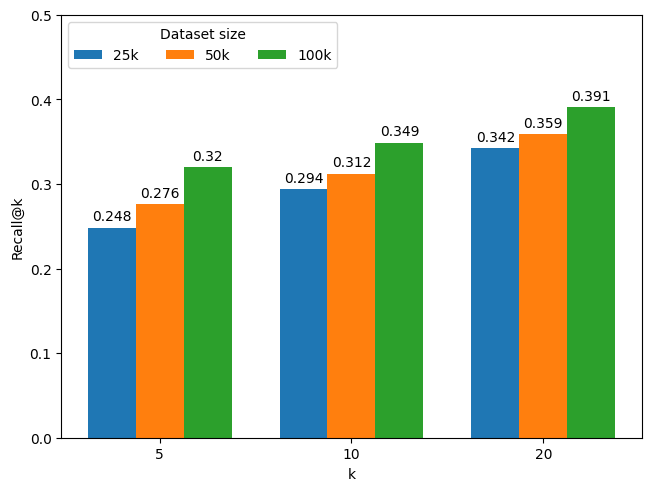

In [45]:
"""
[11]
Title: Grouped bar chart with labels
Author: matplotlib
Availability: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
"""
# Data for plot showing recall values for each dataset
ks = ("5", "10", "20")
recalls = {
    "25k": (0.24807100591715975, 0.2937423687423687, 0.3421731736315703),
    "50k": (0.2761706827309237, 0.3123533658443297, 0.3588506405610876),
    "100k": (0.3201111111111111, 0.34874919597468623, 0.39145174413222883)
}

# Create grouped bar plot
fig, ax = plt.subplots(layout="constrained")

# Create plot data
x = np.arange(len(ks))
bar_width = 0.25
multiplier = 0
for dataset, measurements in recalls.items():
    offset = bar_width * multiplier
    rects = ax.bar(x + offset, list(map(lambda x: round(x, 3), measurements)), bar_width, label=dataset)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Set plot features
ax.set_xlabel("k")
ax.set_ylabel("Recall@k")
# ax.set_title("")
ax.set_xticks(x + bar_width, ks)
ax.legend(title="Dataset size", loc="upper left", ncols=3)
ax.set_ylim(0, 0.5)

plt.savefig("../Data/rs1_recall_per_dataset.pdf")
plt.show()

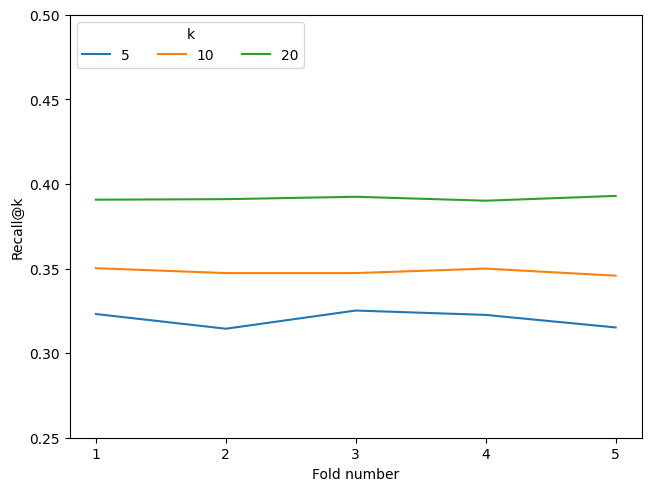

In [50]:
# Data for plot showing recall values for each cross validation fold in the 100k dataset
recall_at_5s = [0.32312636165577346, 0.31443899782135076, 0.3251960784313725, 0.3225980392156863, 0.31519607843137254]
recall_at_10s = [0.3502205882352941, 0.347338546529723, 0.347338546529723, 0.34996744994294016, 0.3457967631497043]
recall_at_20s = [0.3907174906574682, 0.39103201069274335, 0.39243908018057383, 0.39011352169872926, 0.39295661743162963]

# Plot data
fig, ax = plt.subplots(layout="constrained")
plt.plot(range(1, 6), recall_at_5s)
plt.plot(range(1, 6), recall_at_10s)
plt.plot(range(1, 6), recall_at_20s)

# Set plot features
plt.xticks(range(1, 6))
plt.xlabel("Fold number")
plt.ylabel("Recall@k")
plt.legend(["5", "10", "20"], title="k", loc="upper left", ncols=3)
plt.ylim(0.25, 0.5)

plt.savefig("../Data/rs1_recall_over_folds.pdf")
plt.show()

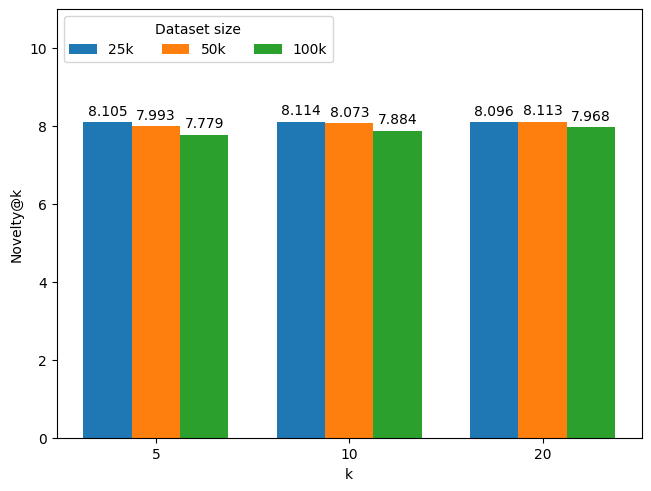

In [51]:
"""
[11]
Title: Grouped bar chart with labels
Author: matplotlib
Availability: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
"""
# Data for plot showing novelty values for each dataset
ks = ("5", "10", "20")
recalls = {
    "25k": (8.104830300275363, 8.114410610085288, 8.09568238459581),
    "50k": (7.993314683342249, 8.073152000314538, 8.112536785311505),
    "100k": (7.779247541565423, 7.884052874660262, 7.967764449188092)
}

# Create grouped bar plot
fig, ax = plt.subplots(layout="constrained")

# Create plot data
x = np.arange(len(ks))
bar_width = 0.25
multiplier = 0
for dataset, measurements in recalls.items():
    offset = bar_width * multiplier
    rects = ax.bar(x + offset, list(map(lambda x: round(x, 3), measurements)), bar_width, label=dataset)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Set plot features
ax.set_xlabel("k")
ax.set_ylabel("Novelty@k")
# ax.set_title("")
ax.set_xticks(x + bar_width, ks)
ax.legend(title="Dataset size", loc="upper left", ncols=3)
ax.set_ylim(0, 11)

plt.savefig("../Data/rs1_novelty_per_dataset.pdf")
plt.show()

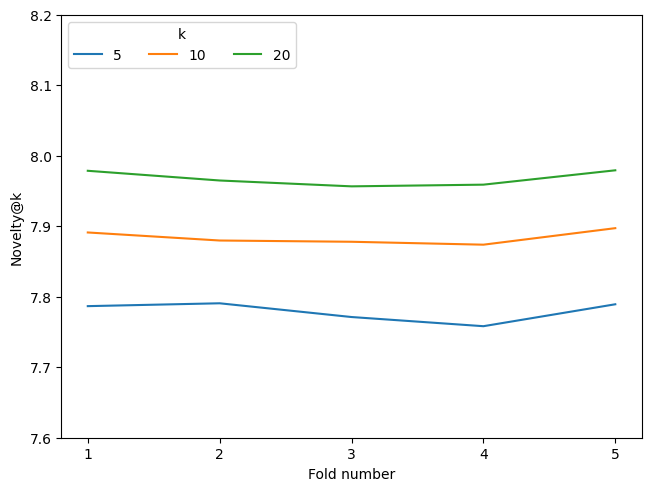

In [54]:
# Data for plot showing novelty values for each cross validation fold in the 100k dataset
novelty_at_5s = [7.786688395332868, 7.790738729112101, 7.77124256126987, 7.7582293304175955, 7.789338691694683]
novelty_at_10s = [7.891214512987618, 7.879807328705335, 7.878025899073667, 7.8738912466753845, 7.897325385859309]
novelty_at_20s = [7.9787330716474685, 7.964964930726302, 7.956653158280555, 7.959052548552521, 7.979418536733614]

# Plot data
fig, ax = plt.subplots(layout="constrained")
plt.plot(range(1, 6), novelty_at_5s)
plt.plot(range(1, 6), novelty_at_10s)
plt.plot(range(1, 6), novelty_at_20s)

# Set plot features
plt.xticks(range(1, 6))
plt.xlabel("Fold number")
plt.ylabel("Novelty@k")
plt.legend(["5", "10", "20"], title="k", loc="upper left", ncols=3)
plt.ylim(7.6, 8.2)

plt.savefig("../Data/rs1_novelty_over_folds.pdf")
plt.show()

# RS1 Demo:

In [133]:
def get_key_constraints(keys):
    """
    Function to get the key constraints from a user.
    Params:
    - list keys: a list of all key options
    Return:
    - string output: an output message to be printed on the screen after receiving the constraints
    - list user_keys: a list of column names corresponding to the keys the user wants to see in their recommendations
    """
    print("Enter the numbers corresponding to any keys you want the recommended songs to be in (separated by spaces):")
    # Display key options
    count = 0
    for key in keys:
        print(f"{str(count)+'.':<4}{key}")
        count += 1

    # Take user input
    print()
    user_keys = input()
    print()

    user_keys = user_keys.split()
    if user_keys == []:
        # If no constraint entered, all keys selected
        output = "All keys selected."
    else:
        # Otherwise, validate user input
        valid = True
        for key in user_keys:
            try:
                if int(key) not in range(12):
                    valid = False
            except ValueError:
                valid = False
        # Set output message
        if valid:
            
            output = "Keys selected:"
            for key in user_keys:
                output += "\n"+keys[int(key)]
            user_keys = list(map(lambda x: "key_"+x, user_keys))
        else:
            output = "Error. Invalid input."
            user_keys = []

    print()

    return output, user_keys

In [134]:
def get_mode_constraints(modes):
    """
    Function to get the mode constraint from a user.
    Params:
    - list modes: a list of all modes
    Return:
    - string output: an output message to be printed on the screen after receiving the constraint
    - list user_mode: a list containing the selected mode
    """
    print("Enter the number corresponding to the mode(s) you want the recommended songs to be in (choose one):")
    # Display mode options
    count = 0
    for mode in modes:
        print(f"{str(count)+'.':<4}{mode}")
        count += 1

    # Take user input
    print()
    user_mode = input()
    print()

    # Set output message
    if user_mode == "":
        user_mode = []
        output = "All modes selected."
    elif user_mode == "0":
        user_mode = [0]
        output = "Mode selected: Minor"
    elif user_mode == "1":
        user_mode = [1]
        output = "Mode selected: Major"
    else:
        user_mode = []
        output = "Error. Invalid mode."

    print()

    return output, user_mode

In [135]:
def get_tempo_constraints():
    """
    Function to get the tempo constraints from a user.
    Return:
    - string output: an output message to be printed on the screen after receiving the constraint
    - list user_tempo: a list containing the selected tempo range ([0, 0] if error)
    """
    print("Enter the minimum tempo you want the recommended songs to have (must be at least 80bpm):")
    valid = True
    # Take user input for min tempo
    user_min_tempo = input()
    print()
    # Validate user input
    try:
        user_min_tempo = float(user_min_tempo)
        if user_min_tempo < 80:
            valid = False
    except ValueError:
        valid = False

    if not valid:
        # Don't set any constraint
        user_min_tempo = 0
        user_max_tempo = 0
    else:
        print("Enter the maximum tempo you want the recommended songs to have (must be at most 220bpm):")
        valid = True
        # Take user input for max tempo
        user_max_tempo = input()
        print()
        # Validate user input
        try:
            user_max_tempo = float(user_max_tempo)
            if user_max_tempo > 220 or user_min_tempo > user_max_tempo:
                valid = False
        except ValueError:
            valid = False

        if not valid:
            # Don't set any constraint
            user_min_tempo = 0
            user_max_tempo = 0

    # Set output message
    if valid:
        output = "Tempo range selected: " + str(user_min_tempo) + "-" + str(user_max_tempo) + "bpm"
    else:
        output = "Error. Invalid tempo range."

    print()

    user_tempo = [user_min_tempo, user_max_tempo]

    return output, user_tempo

In [136]:
def get_genre_constraints(genres_map):
    """
    Function to get the genre constraints from a user.
    Params:
    - dict genres_map: a dictionary mapping genre names to their column names
    Return:
    - list user_genres: a list containing the column names corresponding to the selected genres
    """
    print("Enter any genres you want to appear in your recommendations. If you are done entering your genres, press enter:")
    # # Display all genres
    # count = 1
    # for genre in genres_nice:
    #     print(f"{genre:<32}", end="")
    #     if count % 4 == 0:
    #         print()
    #     count += 1
    # print()
    done = False
    user_genres = []
    while not done:
        # Take user input
        user_genre = input()
        if user_genre == "":
            # Stop if they do not enter anything
            done = True
        else:
            # Validate genre selection
            user_genre_unformatted = user_genre.lower().strip()
            valid = False
            for key in genres_map.keys():
                if user_genre_unformatted == key.lower():
                    user_genres.append(genres_map[key])
                    valid = True
                    print(key, "selected.\n")
            if not valid:
                print("Invalid genre. Try again.\n")

    print()

    return user_genres

In [137]:
def get_artist_constraints(artists_map):
    """
    Function to get the artist constraints from a user.
    Params:
    - dict artists_map: a dictionary mapping artist names to their column names
    Return:
    - list user_artists: a list containing the column names corresponding to the selected artists
    """
    print("Enter any artists you want to appear in your recommendations. If you are done entering your artists, press enter:")
    # # Display all artist names
    # count = 1
    # for artist in artists_nice:
    #     print(f"{artist:<46}", end="")
    #     if count % 3 == 0:
    #         print()
    #     count += 1
    # print()
    done = False
    user_artists = []
    while not done:
        # Take user input
        user_artist = input()
        if user_artist == "":
            # Stop if they do not enter anything
            done = True
        else:
            # Validate artist selection
            user_artist_unformatted = user_artist.lower().strip()
            valid = False
            for key in artists_map.keys():
                if user_artist_unformatted == key.lower():
                    user_artists.append(artists_map[key])
                    valid = True
                    print(key, "selected.\n")
            if not valid:
                print("Invalid artist. Try again.\n")

    print()

    return user_artists

In [138]:
def format_constraints(constraints, keys_nice, modes, genres_reverse_map, artists_reverse_map):
    """
    Function to format a user's entered constraints to be displayed.
    Params:
    - dict constraints: a dictionary of constraints for items that can be recommended
    - list keys_nice: a list of all keys in format for user to interpret
    - list modes: a list of all modes in format for user to interpret
    - dict genres_reverse_map: a dictionary mapping column names to genre names
    - dict artists_reverse_map: a dictionary mapping column names to artist names
    Return:
    - string constraints_display: the text to display to the user to show their recommendation constraints
    """
    # Get text stating key selection
    if constraints["key"] != []:
        keys = "Keys: "
        for i, key in enumerate(constraints["key"]):
            keys += keys_nice[int(key[4:])]
            if i != len(constraints["key"]) - 1:
                keys += ", "
    else:
        keys = "Keys: All"
 
    # Get text stating mode selection
    if constraints["mode"] != []:
        mode = "Mode: " + modes[constraints["mode"]]
    else:
        mode = "Modes: All"

    # Get text stating tempo range
    if constraints["tempo"] != []:
        tempo_range = "Tempos: " + str(constraints["tempo"][0]) + "-" + str(constraints["tempo"][1]) + "bpm"
    else:
        tempo_range = "Tempos: All"

    # Get text stating genre selection
    if constraints["genre"] != []:
        genres = "Genres: "
        for i, genre in enumerate(constraints["genre"]):
            genres += genres_reverse_map[genre]
            if i != len(constraints["genre"]) - 1:
                genres += ", "
    else:
        genres = "Genres: All"

    # Get text stating artist selection
    if constraints["artist"] != []:
        artists = "Artists: "
        for i, artist in enumerate(constraints["artist"]):
            artists += artists_reverse_map[artist]
            if i != len(constraints["artist"]) - 1:
                artists += ", "
    else:
        artists = "Artists: All"

    # Combine text
    constraints_display = keys + ". " + mode + ". " + tempo_range + ". " + genres + ". " + artists + ". "

    return constraints_display

In [139]:
def demo_recommendations(user_id, constraints, model, songs_data, k):
    """
    Function to make a set of recommendations for a user.
    Params:
    - string user_id: the user's unique ID
    - dict constraints: a dictionary of constraints to give the recommendations
    - model: a recommender systems model
    - songs_data: a pandas dataframe of all song content
    - int k: number of recommendations
    Return:
    - recommendations: a set of recommendations for the user
    """
    # Get user recommendations
    recommendations = model.get_k_recommendations(user_id, constraints, k)

    # If no recommendations, display error message
    if len(recommendations) == 0:
        print("No songs meet the constraints.")
        return

    # Merge the dataframe with that containing song content
    recommendations = recommendations.merge(songs_data)

    # Take the relevant columns from this dataframe
    recommendations = recommendations[["track_id", "track_name", "artist_name"]]

    # Get explanations for the recommendations
    for i, track_id in enumerate(recommendations["track_id"]):
        # Get the track column numbers of the 3 most similar songs to each recommended song
        track_nums, scores = zip(*model.cf.cf.explain(0, model.cf.interactions_matrix_sparse.getrow(model.cf.user_id_map[user_id]), model.cbf.track_id_map[track_id], N=3)[1])
        # Convert column numbers to track IDs
        rec_explanations = pd.DataFrame([model.cf.reverse_track_id_map[x] for x in track_nums], columns=["track_id"]).merge(songs_data)
        # Create explanation
        recommendations.loc[i, "explanation"] = "Because you liked "
        for j, explanation in rec_explanations.iterrows():
            recommendations.loc[i, "explanation"] += "'" + explanation["track_name"] + "'" + " by " + explanation["artist_name"]
            if j != 2:
                recommendations.loc[i, "explanation"] += ", "
            elif j == 2:
                recommendations.loc[i, "explanation"] += "..."

    return recommendations

In [145]:
# Set up data
indexed_interactions_data_100k = interactions_data_100k.set_index("user_id")
transformed_songs_data_100k = cbf_pre_processing(songs_data_100k)

# Initialise parameters
key_weight = 0.3
mode_weight = 0
loud_tempo_weight = 0.9
genre_weight = 0.7
artist_weight = 1
factors = 240
regularisation = 0.01
alpha = 40
model_cf = implicit.als.AlternatingLeastSquares(factors, regularisation, alpha, random_state=0)
cbf_weight = 0.6
cf_weight = 0.4

# Initialise model using full data and no test set
hybrid = Hybrid(indexed_interactions_data_100k, None, interactions_data_100k, songs_data_100k, transformed_songs_data_100k, key_weight, mode_weight, loud_tempo_weight, genre_weight, artist_weight, model_cf, cbf_weight, cf_weight)

In [147]:
# Get list of all keys
keys = ["C", "C#/Db", "D", "D#/Eb", "E", "F", "F#/Gb", "G", "G#/Ab", "A", "A#/Bb", "B"]

# Get list of all modes
modes = ["Minor", "Major"]

# Get list of all genre column names
genres = hybrid.cbf.all_song_profiles.iloc[:, 22:1406].columns

#  Get list of all genre names suitable for displaying to the user
genres_nice = list(map(lambda x: x.replace("_", " ")[6:].title(), genres))

#  Get list of all artist names suitable for displaying to the user
artists_nice = sorted(songs_data_100k["artist_name"].unique().tolist())

# Get list of all artist column names
artists = list(map(lambda x: "artist_" + x.lower().replace(" ", "_"), artists_nice))

# Get dictionaries to map between nice versions of genres and column names
genres_map = dict(zip(genres_nice, genres))
genres_reverse_map = dict(zip(genres, genres_nice))

# Get dictionaries to map between nice versions of artists and column names
artists_map = dict(zip(artists_nice, artists))
artists_reverse_map = dict(zip(artists, artists_nice))

In [ ]:
print("Welcome to the song recommender!")
print("Given your Spotify playlist statistics, I will provide you with recommendations to try and help you expand your catalog!\n")
login_run = True
logged_in = False
while login_run:
    user_id = input("Enter your Spotify user ID to login: ")
    if user_id in hybrid.all_user_ids:
        login_run = False
        logged_in = True
        print("\033[A                                                                                                                                                                 ", end="\r")
        print("User logged in: ", user_id, "\n")
    else:
        quit = input(
            "Error. That user ID does not exist. Would you like to quit? (Yes (y) or No (n)) ")
        if quit.lower() == "y":
            login_run = False
        else:
            for i in range(2):
                print("\033[A                                                                                                                                                                 ", end="\r")

Welcome to the song recommender!
Given your Spotify playlist statistics, I will provide you with recommendations to try and help you expand your catalog!
User logged in:  me                                                                                                                                              



In [148]:
# Initialise constraints dictionary
constraints = {"key": [], "mode": [], "tempo": [], "genre": [], "artist": []}

In [ ]:
print("Generating recommendations...", end="\r")
# Generate user recommendations
recs = demo_recommendations(user_id, constraints, hybrid, songs_data_100k, 10)

print("Your recommendations:        ")
# Display recommendations
for i, row in recs.iterrows():
    print(f"{str(i+1)+'.':<4}'{row['track_name']}' - {row['artist_name']}")

Your recommendations:        
1.  'Touch The Sky' - Kanye West
2.  'Gone' - Kanye West
3.  'Heartless' - Kanye West
4.  'All Falls Down' - Kanye West
5.  'Headlines' - Drake
6.  'Heard 'Em Say' - Kanye West
7.  'Show Me What You Got' - JAY Z
8.  'A.D.H.D' - Kendrick Lamar
9.  'Addiction' - Kanye West
10. 'Dark Fantasy' - Kanye West


In [ ]:
# User may ask to see explanations of the recommendations, in which case:

print("Explanations:")
# Display explanations
for i, row in recs.iterrows():
    print(f"{str(i+1)+'.':<4}{row['explanation']}")

Explanations:
1.  Because you liked 'Diamonds From Sierra Leone - Remix - Album Version (Explicit)' by Kanye West, 'Lord Knows' by Drake, 'Hey Mama' by Kanye West...
2.  Because you liked 'Super Rich Kids' by Frank Ocean, 'Diamonds From Sierra Leone - Remix - Album Version (Explicit)' by Kanye West, 'Hey Mama' by Kanye West...
3.  Because you liked 'Flashing Lights' by Kanye West, 'Through The Wire' by Kanye West, 'Runaway' by Kanye West...
4.  Because you liked 'Lucifer' by JAY Z, 'Through The Wire' by Kanye West, 'Waves' by Joey Bada$$...
5.  Because you liked 'Marvins Room' by Drake, 'Lord Knows' by Drake, 'Take Care' by Drake...
6.  Because you liked 'Hey Mama' by Kanye West, 'Diamonds From Sierra Leone - Remix - Album Version (Explicit)' by Kanye West, 'Through The Wire' by Kanye West...
7.  Because you liked 'Run This Town' by JAY Z, 'Empire State Of Mind' by JAY Z, 'Song Cry' by JAY Z...
8.  Because you liked 'Hol' Up' by Kendrick Lamar, 'Swimming Pools (Drank)' by Kendrick Lama

In [149]:
# User can set constraints

# Key constraints
key_output, constraints["key"] = get_key_constraints(keys)
print(key_output)

Enter the numbers corresponding to any keys you want the recommended songs to be in (separated by spaces):
0.  C
1.  C#/Db
2.  D
3.  D#/Eb
4.  E
5.  F
6.  F#/Gb
7.  G
8.  G#/Ab
9.  A
10. A#/Bb
11. B



Keys selected:
C
D
E


In [150]:
# Mode constraints
mode_output, constraints["mode"] = get_mode_constraints(modes)
print(mode_output)

Enter the number corresponding to the mode(s) you want the recommended songs to be in (choose one):
0.  Minor
1.  Major



All modes selected.


In [152]:
# Tempo constraints
tempo_output, constraints["tempo"] = get_tempo_constraints()
print(tempo_output)

Enter the minimum tempo you want the recommended songs to have (must be at least 80bpm):



Enter the maximum tempo you want the recommended songs to have (must be at most 220bpm):


Tempo range selected: 100.0-140.0bpm


In [153]:
# Genre constraints
constraints["genre"] = get_genre_constraints(genres_map)

Enter any genres you want to appear in your recommendations. If you are done entering your genres, press enter:
Soul selected.

R&B selected.

Pop selected.




In [154]:
# Artist constraints
constraints["artist"] = get_artist_constraints(artists_map)

Enter any artists you want to appear in your recommendations. If you are done entering your artists, press enter:


In [155]:
constraints

{'key': ['key_0', 'key_2', 'key_4'],
 'mode': [],
 'tempo': [100.0, 140.0],
 'genre': ['genre_soul', 'genre_r&b', 'genre_pop'],
 'artist': []}

In [ ]:
print("Generating recommendations...", end="\r")
# Generate constrained user recommendations
recs = demo_recommendations(user_id, constraints, hybrid, songs_data_100k, 10)

print("Your recommendations:        ")
# Display constrained recommendations
for i, row in recs.iterrows():
    print(f"{str(i+1)+'.':<4}'{row['track_name']}' - {row['artist_name']}")

Your recommendations:        
1.  'This Is How We Do It' - Montell Jordan
2.  'Thinking About You' - Calvin Harris
3.  'American Boy' - Estelle
4.  'No New Friends' - DJ Khaled
5.  'Recognize (feat. Drake)' - PARTYNEXTDOOR
6.  'I Will Never Let You Down' - Rita Ora
7.  'Leave Me Alone - 2012 Remaster' - Michael Jackson
8.  'Settle Down' - The 1975
9.  'Glamorous' - Fergie
10. 'Don't Stop 'Til You Get Enough - 2003 Edit' - Michael Jackson


In [ ]:
# And their explanations
print("Explanations:")
# Display explanations
for i, row in recs.iterrows():
    print(f"{str(i+1)+'.':<4}{row['explanation']}")

Explanations:
1.  Because you liked 'Song Cry' by JAY Z, 'Bitch, Don’t Kill My Vibe' by Kendrick Lamar, 'Lord Knows' by Drake...
2.  Because you liked 'Lost One' by JAY Z, 'Love Yourz' by J. Cole, 'No Role Modelz' by J. Cole...
3.  Because you liked 'Two Words' by Kanye West, 'Spaceship' by Kanye West, 'Wus Good / Curious' by PARTYNEXTDOOR...
4.  Because you liked 'You & The 6' by Drake, 'Preach' by Drake, 'HYFR (Hell Ya Fucking Right)' by Drake...
5.  Because you liked 'You & The 6' by Drake, 'Preach' by Drake, 'Marvins Room' by Drake...
6.  Because you liked 'Power Trip' by J. Cole, 'LES' by Childish Gambino, 'All Of The Lights' by Kanye West...
7.  Because you liked 'Spaceship' by Kanye West, 'Two Words' by Kanye West, 'Nobody's Perfect' by J. Cole...
8.  Because you liked 'Love Yourz' by J. Cole, 'Power Trip' by J. Cole, 'Novacane' by Frank Ocean...
9.  Because you liked 'Devil In A New Dress' by Kanye West, 'Hol' Up' by Kendrick Lamar, 'Lost' by Frank Ocean...
10. Because you like

# RS2:

# CBF2 (Node2Vec):

Pre-processing functions:

In [18]:
def get_kg_embeddings(songs_original, dataset, song_emb_file=None):
    """
    Function to produce knowledge graph embeddings of this data.
    Params:
    - songs_original: a pandas dataframe containing song content
    - string dataset: a string to indicate which dataset the song embeddings are being produced for
    - string song_emb_file: the filename of the pre-trained song embeddings (None if not yet created)
    Return:
    - song_embeddings: a pandas dataframe containing the song embeddings
    """
    songs = songs_original.copy()

    if song_emb_file is None:
        # Drop unnecessary columns
        songs.drop(columns=["track_name", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "track_pop", "artist_pop"], inplace=True)

        # Convert lists of strings to lists
        songs["genres_list"] = songs["genres_list"].apply(lambda x : eval(x))

        # Vectorise the genres data 
        mlb = MultiLabelBinarizer()
        mlb_genres = mlb.fit_transform(songs.pop("genres_list"))
        genres = pd.DataFrame(mlb_genres)
        # Rename the columns
        genres.columns = ["genre_" + str(g) for g in mlb.classes_]
        genres.drop(columns="genre_unknown", inplace=True)
        # Replace original genre list column
        songs = pd.concat([songs, genres], axis=1)
    
        # Get list of songs by each artist
        artist_songs = songs.groupby(["artist_name"]).apply(lambda x: x["track_id"].tolist()).to_frame(name="track_ids")

        # Get list of songs in each genre
        genre_songs = songs.columns[2:].to_frame().reset_index(drop=True).rename(columns={0: "genre_name"})
        genre_items = []
        for genre in songs.columns[2:]:
            genre_items.append(songs[songs[genre] == 1]["track_id"].tolist())
        genre_songs = pd.concat([genre_songs, pd.Series(genre_items, name="track_ids")], axis=1)

        # Create a knowledge graph of the songs connected by artist and genre nodes
        G = nx.Graph()

        # Add nodes to the graph
        for track_id in songs["track_id"]:
            G.add_node(f"{track_id}", type="song")

        for artist_id in artist_songs.index:
            G.add_node(f"{artist_id}", type="artist")

        for genre_id in genre_songs.index:
            G.add_node(f"{genre_id}", type="genre")

        # Add edges to the graph between songs with the same artist or genre
        for i, row in artist_songs.iterrows():
            for track_id in row["track_ids"]:
                G.add_edge(f"{track_id}", f"{i}")

        for i, row in genre_songs.iterrows():
            for track_id in row["track_ids"]:
                G.add_edge(f"{track_id}", f"{i}")

        # Initialise Node2Vec to create graph embeddings
        node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=2)

        # Train Node2Vec model
        model = node2vec.fit(window=10, min_count=1, batch_words=4)

        # Get the song embeddings
        embeddings = {node: model.wv[node] for node in G.nodes()}
        song_embeddings = {node: emb for node, emb in embeddings.items() if G.nodes[node]["type"] == "song"}

        # Save these embeddings to save time later
        with open(f"../Data/song_embeddings_{dataset}.pkl", "wb") as file:
            pickle.dump(song_embeddings, file)
    else:
        # Load pre-trained embeddings to save time
        with open(song_emb_file, "rb") as file:
            song_embeddings = pickle.load(file)

    # Convert embeddings to a dataframe
    song_embeddings = pd.DataFrame.from_dict(song_embeddings, orient="index")
    song_embeddings.index.name = "track_id"
    
    return song_embeddings


def cbf2_pre_processing(songs_original, dataset, song_emb_file=None):
    """
    Function to perform pre processing on the song content.
    Params:
    - songs_original: a pandas dataframe containing song content
    - string dataset: a string to indicate which dataset the song embeddings are being produced for
    - string song_emb_file: the filename of the pre-trained song embeddings (None if not yet created)
    Return:
    - new_songs: a pandas dataframe containing the transformed song content
    """
    songs = songs_original.copy()    

    # One-hot encode the key column
    ohe_key = pd.get_dummies(songs.pop("key"))
    ohe_key.columns = ["key_" + str(k) for k in ohe_key.columns]  # Rename columns
    songs = pd.concat([songs, ohe_key], axis=1)  # Replace original key column

    # Min-max scale to get values in same range (0-1)
    cols_to_scale = ["loudness", "tempo"]
    mm_scaler = MinMaxScaler()
    songs[cols_to_scale] = mm_scaler.fit_transform(songs[cols_to_scale])

    # Drop columns to not include in song profiles
    songs.drop(columns=["track_name", "track_pop", "artist_pop", "artist_name", "genres_list"], inplace=True)

    # Get the song embeddings containing the genre and artist data
    song_embeddings = get_kg_embeddings(songs_original, dataset, song_emb_file)

    # Merge the two dataframes
    new_songs = song_embeddings.reset_index().merge(songs)
    
    return new_songs

Model:

In [19]:
class ContentBasedFilter2:
    """
    Class to produce better content-based recommendations using Node2Vec.
    """
    def __init__(self, interactions_train, interactions_test, songs_data, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len):
        """
        Params:
        - interactions_train: a pandas dataframe containing the training interactions
        - interactions_test: a pandas dataframe containing the test interactions (None if no test interactions)
        - songs_data: a pandas dataframe containing the content for all songs
        - float key_weight: a value between 0 and 1 to multiply the key columns by to adjust their weighting in the recommendations
        - float mode_weight: "                                    " mode column by to adjust its weighting in the recommendations
        - float loud_tempo_weight: "                              " loudness and tempo columns by to adjust their weighting in the recommendations
        - float genre_artist_weight:  "                               " genre and artist embeddings by to adjust their weighting in the recommendations
        - int embedding_len: the dimension of the genre and artist embeddings
        """
        # Load data into class variables
        self.interactions_train = interactions_train
        self.interactions_test = interactions_test
        self.songs_data = songs_data
        self.key_weight = key_weight
        self.mode_weight = mode_weight
        self.loud_tempo_weight = loud_tempo_weight
        self.genre_artist_weight = genre_artist_weight

        # Adjust weighting of key columns
        key_columns = [col for col in self.songs_data.columns if str(col)[:3] == "key"]
        self.songs_data[key_columns] *= self.key_weight

        # Adjust weighting of mode column
        self.songs_data["mode"] *= self.mode_weight

        # Adjust weighting of columns that were min-max scaled
        scaled_columns = ["loudness", "tempo"]
        self.songs_data[scaled_columns] *= self.loud_tempo_weight

        # Adjust weighting of embedding columns
        emb_columns = list(range(embedding_len))
        self.songs_data[emb_columns] *= self.genre_artist_weight
        
        # Turn song content to song profiles
        self.all_song_profiles = self.songs_data.set_index("track_id")

        # Get all song IDs
        self.all_track_ids = self.all_song_profiles.index

        # Create dictionary class variable to map between song ID and row number of song profile
        self.track_id_map = dict(zip(self.all_track_ids, range(len(self.all_song_profiles))))

        # Create user profiles by taking the mean profile of all songs a user has interacted with
        song_profiles_sparse = csr_matrix(self.all_song_profiles) # Use sparse matrix to speed up computation
        self.all_user_profiles = self.interactions_train.groupby(self.interactions_train.index).apply(lambda x : np.asarray(song_profiles_sparse[[self.track_id_map[y] for y in x["track_id"]], :].mean(axis=0)).flatten()).apply(pd.Series)
        self.all_user_profiles.columns = self.all_song_profiles.columns

        # Get all user IDs
        self.all_user_ids = self.all_user_profiles.index

        # Create a dataframe to indicate which songs each user has interacted with in the training data
        interaction_counts = self.interactions_train.groupby(["user_id", "track_id"], as_index=False).size()
        self.training_songs = interaction_counts.groupby("user_id").apply(lambda x: x["track_id"].tolist()).to_frame(name="track_ids")
        self.training_songs["indices"] = self.training_songs["track_ids"].apply(lambda ids: [self.track_id_map[id] for id in ids])

        # Create a dataframe to indicate which songs each user hasn't interacted with in the training data
        self.non_training_songs = self.training_songs.copy()
        self.non_training_songs["track_ids"] = self.non_training_songs["track_ids"].apply(lambda x: list(set(self.all_track_ids) - set(x))).to_frame(name="track_ids")
        self.non_training_songs["indices"] = self.non_training_songs["track_ids"].apply(lambda ids: [self.track_id_map[id] for id in ids])

        # Create min-max scaler to scale scores
        self.mm_scaler = MinMaxScaler()


    def get_k_recommendations_all_users(self, k=10):
        """
        Function to get k recommendations for each user.
        Params:
        - int k: the number of recommendations
        Return:
        - recommendations: a list of recommendations for each user, where each recommendation is a pandas dataframe with columns track ID, score
        """
        # Get the cosine similarity between every user profile and every song
        cosine_similarities_matrix = cosine_similarity(self.all_user_profiles, csr_matrix(self.all_song_profiles))

        # Initialise list to store lists of recommendations
        recommendations = []

        # For each user
        for i, cosine_similarities_row in enumerate(cosine_similarities_matrix):
            # "Filter out" songs already interacted with by setting their similarities to 0
            indices_for_songs_already_interacted_with = self.training_songs.iloc[i, 1]
            cosine_similarities_row[indices_for_songs_already_interacted_with] = np.zeros(len(indices_for_songs_already_interacted_with))

            # Get the indices of the k most similar songs to the user profile in descending order
            similar_indices = cosine_similarities_row.argsort()[-k:][::-1]

            # Get a list of tuples containing these songs' IDs and similarity values
            similar_items = [(self.all_track_ids[i], cosine_similarities_row[i]) for i in similar_indices]

            # Convert this to a dataframe
            user_recommendations = pd.DataFrame(similar_items, columns=["track_id", "score"])

            # Add the recommendations to the global recommendations list
            recommendations.append(user_recommendations)
 
        return recommendations
    

    def get_k_recommendations(self, user_profile, song_profiles, k=10):
        """
        Function to get k recommendations for a particular user given their user profile and a set of songs that can be recommended.
        Params:
        - user_profile: a pandas dataframe for the user profile
        - song_profiles: a pandas dataframe containing song profiles for the songs that can be recommended to this user
        - int k: number of recommendations
        Return:
        - recommendations: a pandas dataframe with columns track ID, score
        """
        # Get the cosine similarity between the user profile and each song
        cosine_similarities = cosine_similarity(user_profile, csr_matrix(song_profiles)).flatten()

        # Get the indices of the k most similar songs to the user profile in descending order
        similar_indices = cosine_similarities.argsort()[-k:][::-1]

        # Get a list of tuples containing these songs' IDs and similarity values
        all_user_track_ids = song_profiles.index
        similar_items = [(all_user_track_ids[i], cosine_similarities[i]) for i in similar_indices]

        # Convert this to a dataframe
        recommendations = pd.DataFrame(similar_items, columns=["track_id", "score"])
        
        return recommendations

    
    def rank_items_all_users(self):
        """
        Function to rank every song that each user hasn't interacted with based on their similarity score.
        Used for the hybrid system.
        Return:
        - rankings: a list of rankings for each user, where each ranking is a pandas dataframe with columns track ID, score
        """
        # Get the cosine similarity between every user profile and every song
        cosine_similarities_matrix = cosine_similarity(self.all_user_profiles, csr_matrix(self.all_song_profiles))

        # Initialise list to store rankings for each user
        rankings = []

        # For each user
        for i, cosine_similarities_row in enumerate(cosine_similarities_matrix):
            # "Filter out" songs already interacted with by setting their similarities to 0
            indices_for_songs_already_interacted_with = self.training_songs.iloc[i, 1]
            cosine_similarities_row[indices_for_songs_already_interacted_with] = np.zeros(len(indices_for_songs_already_interacted_with))

            # Get the indices of the songs in descending order of similarity to the user profile
            similar_indices = cosine_similarities_row.argsort()[::-1]

            # Get a list of tuples containing these songs' IDs and similarity values
            similar_items = [(self.all_track_ids[i], cosine_similarities_row[i]) for i in similar_indices]

            # Convert this to a dataframe
            user_rankings = pd.DataFrame(similar_items, columns=["track_id", "score"])

            # Min-max scale the scores so they are in the range 0-1
            user_rankings.loc[:, "score"] = self.mm_scaler.fit_transform(user_rankings[["score"]])

            # Add the rankings to the global rankings list
            rankings.append(user_rankings)
 
        return rankings
    

    def rank_items(self, user_profile, song_profiles):
        """
        Function to rank a set of songs for a particular user given their user profile.
        Used for the hybrid system.
        Params:
        - user_profile: a pandas dataframe for the user profile
        - song_profiles: a pandas dataframe containing song profiles for the songs to rank for the user
        Return:
        - rankings: a pandas dataframe with columns track ID, score
        """
        # Get the cosine similarity between the user profile and each song
        cosine_similarities = cosine_similarity(user_profile, csr_matrix(song_profiles)).flatten()
        
        # Get the indices of the songs in descending order of similarity to the user profile
        ranked_indices = cosine_similarities.argsort()[::-1]

        # Get a list of tuples containing these songs' IDs and similarity values
        all_user_track_ids = song_profiles.index
        ranked_items = [(all_user_track_ids[i], cosine_similarities[i]) for i in ranked_indices]

        # Convert this to a dataframe
        rankings = pd.DataFrame(ranked_items, columns=["track_id", "score"])

        # Min-max scale the scores so they are in the range 0-1
        rankings.loc[:, "score"] = self.mm_scaler.fit_transform(rankings[["score"]])
        
        return rankings

## CBF2 Evaluation:

In [20]:
def cbf2_evaluation(cross_validation, songs_data, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len):
    """
    Function to perform the evaluation on the CBF2 model.
    Params:
    - cross_validation: a 2D list of train/test splits
    - songs_data: a pandas dataframe containing the content for all songs
    - float key_weight: a value between 0 and 1 to multiply the key columns by to adjust their weighting in the recommendations
    - float mode_weight: "                                    " mode column by to adjust its weighting in the recommendations
    - float loud_tempo_weight: "                              " loudness and tempo columns by to adjust their weighting in the recommendations
    - float genre_artist_weight:  "                           " genre and artist embeddings by to adjust their weighting in the recommendations
    - int embedding_len: the dimension of the genre and artist embeddings
    """
    evals = []
    # For each fold
    for i, cv_set in enumerate(cross_validation):
        cbf2 = ContentBasedFilter2(cv_set[0], cv_set[1], songs_data, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len)
        # Evaluate model
        e = evaluate_model(cbf2)
        evals.append(e)
        print(f"Fold {i+1}.")
        print("recall@5:", np.mean(e["normalised recall@5"]), "\trecall@10:", np.mean(e["normalised recall@10"]), "\trecall@20:", np.mean(e["normalised recall@20"]))
        print("novelty@5:", np.mean(e["novelty@5"]), "\tnovelty@10:", np.mean(e["novelty@10"]), "\tnovelty@20:", np.mean(e["novelty@20"]))
        print()

    # Get overall recall values
    overall_recall_at_5 = 0
    overall_recall_at_10 = 0
    overall_recall_at_20 = 0
    # Get overall novelty values
    overall_novelty_at_5 = 0
    overall_novelty_at_10 = 0
    overall_novelty_at_20 = 0
    for e in evals:
        overall_recall_at_5 += np.mean(e["normalised recall@5"])/5
        overall_recall_at_10 += np.mean(e["normalised recall@10"])/5
        overall_recall_at_20 += np.mean(e["normalised recall@20"])/5
        overall_novelty_at_5 += np.mean(e["novelty@5"])/5
        overall_novelty_at_10 += np.mean(e["novelty@10"])/5
        overall_novelty_at_20 += np.mean(e["novelty@20"])/5

    print("Overall recall@5:", overall_recall_at_5, "\tOverall recall@10:", overall_recall_at_10, "\tOverall recall@20:", overall_recall_at_20)
    print("Overall novelty@5:", overall_novelty_at_5, "\tOverall novelty@10:", overall_novelty_at_10, "\tOverall novelty@20:", overall_novelty_at_20)

In [21]:
# Initialise parameters
key_weight = 0.5
mode_weight = 0
loud_tempo_weight = 1
genre_artist_weight = 1
embedding_len = 64

25,000 dataset:

In [191]:
# Perform pre-processing - use pre-trained song embeddings
transformed_songs_data_25k = cbf2_pre_processing(songs_data_25k, "25k", "../Data/song_embeddings_25k.pkl")
# Evaluate
cbf2_evaluation(cross_validation_25k, transformed_songs_data_25k, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len)

Fold 1.
recall@5: 0.23984220907297832 	recall@10: 0.29458110265802573 	recall@20: 0.33851948414614436
novelty@5: 8.609915181497541 	novelty@10: 8.64888535231958 	novelty@20: 8.66599300448606

Fold 2.
recall@5: 0.23721893491124263 	recall@10: 0.2853540903540904 	recall@20: 0.3328008436901122
novelty@5: 8.641132825940634 	novelty@10: 8.656196626595348 	novelty@20: 8.670539171948317

Fold 3.
recall@5: 0.23745562130177517 	recall@10: 0.2802296421527191 	recall@20: 0.33097142794268486
novelty@5: 8.612832337718494 	novelty@10: 8.644468988945325 	novelty@20: 8.667197399542907

Fold 4.
recall@5: 0.23690335305719923 	recall@10: 0.2876880811496196 	recall@20: 0.3281677661914257
novelty@5: 8.616112298320504 	novelty@10: 8.627136389827884 	novelty@20: 8.65544559655672

Fold 5.
recall@5: 0.22658777120315582 	recall@10: 0.2767601202216587 	recall@20: 0.3281148295782274
novelty@5: 8.59058861570553 	novelty@10: 8.622072197985212 	novelty@20: 8.653200045546654

Overall recall@5: 0.23560157790927022 	Ov

50,000 dataset:

In [192]:
# Perform pre-processing
transformed_songs_data_50k = cbf2_pre_processing(songs_data_50k, "50k", "../Data/song_embeddings_50k.pkl")
# Evaluate
cbf2_evaluation(cross_validation_50k, transformed_songs_data_50k, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len)

Fold 1.
recall@5: 0.1826706827309237 	recall@10: 0.2362026678141136 	recall@20: 0.2911963164280483
novelty@5: 9.105181860032072 	novelty@10: 9.077384288639834 	novelty@20: 9.10847891092019

Fold 2.
recall@5: 0.18421686746987953 	recall@10: 0.24330799388028304 	recall@20: 0.3012500212143988
novelty@5: 9.086407650496005 	novelty@10: 9.059657376657414 	novelty@20: 9.09895833666496

Fold 3.
recall@5: 0.18825301204819278 	recall@10: 0.2434607477529164 	recall@20: 0.2970115921830831
novelty@5: 9.074230290573682 	novelty@10: 9.049357146780693 	novelty@20: 9.090489974985033

Fold 4.
recall@5: 0.19137550200803213 	recall@10: 0.2496612641040352 	recall@20: 0.3027925188737556
novelty@5: 9.067502286848418 	novelty@10: 9.038150228593297 	novelty@20: 9.080651713377616

Fold 5.
recall@5: 0.19174698795180722 	recall@10: 0.24709289539108817 	recall@20: 0.29773274719631354
novelty@5: 9.061801693327196 	novelty@10: 9.045026327071456 	novelty@20: 9.090821910339507

Overall recall@5: 0.18765261044176706 	O

100,000 dataset:

In [ ]:
# Perform pre-processing
transformed_songs_data_100k = cbf2_pre_processing(songs_data_100k, "100k", "../Data/song_embeddings_100k.pkl")
# Evaluate
cbf2_evaluation(cross_validation_100k, transformed_songs_data_100k, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len)

Fold 1.
recall@5: 0.1746949891067538 	recall@10: 0.23440203859321512 	recall@20: 0.2838553059534362
novelty@5: 9.287411203937488 	novelty@10: 9.325924136621625 	novelty@20: 9.384951234482898

Fold 2.
recall@5: 0.18196078431372548 	recall@10: 0.228833255524432 	recall@20: 0.2838860511187956
novelty@5: 9.281089343732667 	novelty@10: 9.315794533988743 	novelty@20: 9.380585312342259

Fold 3.
recall@5: 0.17960239651416118 	recall@10: 0.23258066189438736 	recall@20: 0.2841134036205896
novelty@5: 9.278519776102003 	novelty@10: 9.311892669358615 	novelty@20: 9.37905655992253

Fold 4.
recall@5: 0.17668300653594773 	recall@10: 0.23135128125324206 	recall@20: 0.28035314873762635
novelty@5: 9.264135916784532 	novelty@10: 9.30271218442601 	novelty@20: 9.372755074020034

Fold 5.
recall@5: 0.1792102396514161 	recall@10: 0.22999714700695092 	recall@20: 0.28005006078558253
novelty@5: 9.26962444154797 	novelty@10: 9.316702045182927 	novelty@20: 9.381647175006545

Overall recall@5: 0.17843028322440085 	O

In [119]:
# Example of recommendations
cbf2 = ContentBasedFilter2(interactions_data_100k.set_index("user_id"), None, transformed_songs_data_100k, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len)
# Get user profile
user_profile = cbf2.all_user_profiles.loc[["me"], :]
# Get song profiles
user_non_interacted_songs = pd.Series(cbf2.non_training_songs.loc["me", "track_ids"])
song_profiles = cbf2.all_song_profiles.loc[user_non_interacted_songs, :]
cbf2.get_k_recommendations(user_profile, song_profiles).merge(songs_data_100k)[["track_name", "artist_name"]]

,track_name,artist_name
0,The Recipe - Bonus Track,Kendrick Lamar
1,F*ck Your Ethnicity,Kendrick Lamar
2,Ni**as In Paris,JAY Z
3,P&P 1.5,Kendrick Lamar
4,HiiiPower,Kendrick Lamar
5,You Ain't Gotta Lie (Momma Said),Kendrick Lamar
6,Average Joe,Kendrick Lamar
7,Complexion (A Zulu Love),Kendrick Lamar
8,Institutionalized,Kendrick Lamar
9,The Spiteful Chant,Kendrick Lamar


# CF2 (LightGCN):

Model:

In [196]:
"""
[12]
Title: LightGCN->Pytorch(From Scratch)
Author: Dipanjan Das
Date: 2021
Code version: 3
Availability: https://www.kaggle.com/code/dipanjandas96/lightgcn-pytorch-from-scratch
"""
class LightGCN(nn.Module):
    """
    Class to produce better collaborative recommendations using the LightGCN model.
    """
    def __init__(self, interactions_train, interactions_test, interactions_data, latent_dimensions, num_layers, pretrained_emb_files=None):
        """
        Params:
        - interactions_train: a pandas dataframe containing the training interactions
        - interactions_test: a pandas dataframe containing the test interactions (None if no test interactions)
        - interactions_data: a pandas dataframe containing all interactions
        - int latent_dimensions: the embedding size
        - int num_layers: the number of layers used to propagate the embeddings on the graph
        - list pretrained_emb_files: a list of the file names of the pretrained embeddings (None if don't exist)
        """
        super(LightGCN, self).__init__()
        
        # Load data into class variables
        self.interactions_train = interactions_train
        self.interactions_test = interactions_test
        self.interactions_data = interactions_data
        self.latent_dimensions = latent_dimensions
        self.num_layers = num_layers

        # Get dataframe containing (user, song, 1) triples
        interaction_counts = interactions_data.groupby(["user_id", "track_id"], as_index=False).size()
        interaction_counts["size"] = interaction_counts["size"].apply(lambda x: 1)

        # Create the users x songs interactions matrix (1 if any interaction, 0 if not)
        self.interactions_matrix = interaction_counts.pivot(index="user_id", columns="track_id", values="size").fillna(0)

        # Set any test interactions to 0
        if interactions_test is not None:
            for user_id, track_id in interactions_test["track_id"].items():
                self.interactions_matrix.at[user_id, track_id] = 0

        # Create dictionaries to map from user/song IDs to the corresponding row/column index in the interactions matrix
        self.all_user_ids = self.interactions_matrix.index
        self.all_track_ids = self.interactions_matrix.columns
        self.num_users = len(self.all_user_ids)
        self.num_tracks = len(self.all_track_ids)
        self.all_user_nums = range(self.num_users)
        self.all_track_nums = range(self.num_tracks)
        self.user_id_map = dict(zip(self.all_user_ids, self.all_user_nums))
        self.reverse_user_id_map = dict(zip(self.all_user_nums, self.all_user_ids))
        self.track_id_map = dict(zip(self.all_track_ids, self.all_track_nums))
        self.reverse_track_id_map = dict(zip(self.all_track_nums, self.all_track_ids))

        # Create a dataframe to indicate which songs each user has interacted with in the training data
        interaction_counts = interactions_train.groupby(["user_id", "track_id"], as_index=False).size()
        self.training_songs = interaction_counts.groupby("user_id").apply(lambda x: list(map(lambda y: self.track_id_map[y], x["track_id"]))).to_frame(name="track_ids")

        # Create a dataframe to indicate which songs each user has not interacted with in the training data
        self.non_training_songs = self.training_songs.copy()
        self.non_training_songs["track_ids"] = self.non_training_songs["track_ids"].apply(lambda x: list(set(self.all_track_nums) - set(x))).to_frame(name="track_ids")

        # Get the adjacency matrix of the graph (the nodes are the users and songs)
        adj_matrix = np.zeros((self.num_users + self.num_tracks, self.num_users + self.num_tracks))
        adj_matrix[:self.num_users, self.num_users:] = self.interactions_matrix
        adj_matrix[self.num_users:, :self.num_users] = self.interactions_matrix.T
        adj_matrix_sparse = sp.csr_matrix(adj_matrix)

        # Get the row sums of this adjacency matrix
        rowsums = adj_matrix.sum(axis=1)

        # Get the normalising matrix, D^-1/2
        normalising_terms = np.power(rowsums + 1e-9, -0.5) # We add 1e-9 for numerical stability
        normalising_matrix = sp.diags(normalising_terms)
        normalising_matrix_sparse = sp.csr_matrix(normalising_matrix)

        # Normalise the adjacency matrix
        normalised_adj_matrix = (normalising_matrix_sparse @ adj_matrix_sparse @ normalising_matrix_sparse).tocoo()

        # Convert this to a tensor
        values = normalised_adj_matrix.data
        indices = np.vstack((normalised_adj_matrix.row, normalised_adj_matrix.col))
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = normalised_adj_matrix.shape
        self.normalised_adj_matrix = torch.sparse_coo_tensor(i, v, torch.Size(shape))

        # Initialise the user and song embedding parameters using the Xavier method
        self.initial_emb = nn.Embedding(self.num_users + self.num_tracks, self.latent_dimensions)
        nn.init.xavier_uniform_(self.initial_emb.weight)
        self.initial_emb.weight = nn.Parameter(self.initial_emb.weight)

        # Create min-max scaler to scale scores
        self.mm_scaler = MinMaxScaler()

        # If the model is pretrained, load the embeddings
        if pretrained_emb_files is not None:
            self.best_user_emb = torch.load(pretrained_emb_files[0], map_location="cpu")
            self.best_track_emb = torch.load(pretrained_emb_files[1], map_location="cpu")


    def propagate_through_layers(self):
        """
        Function to propagate the embeddings through layers of the graph.
        Return:
        - final_user_emb: the new embedding for the users
        - final_track_emb: the new embedding for the songs
        """
        # Initialise list to store the embedding at each layer
        all_layer_embs = [self.initial_emb.weight]
 
        current_emb_layer = self.initial_emb.weight
        # Iterate through layers
        for layer in range(self.num_layers):
            # Get next embedding layer by multiplying embedding with adjacency matrix
            current_emb_layer = torch.sparse.mm(self.normalised_adj_matrix, current_emb_layer)
            
            # Add embedding layer to list
            all_layer_embs.append(current_emb_layer)

        # Create a tensor from the list
        all_layer_embs = torch.stack(all_layer_embs)

        # Get the mean embedding over the layers
        mean_layer_emb = torch.mean(all_layer_embs, axis=0)

        # Split the mean embedding into user and song embeddings
        final_user_emb, final_track_emb = torch.split(mean_layer_emb, [self.num_users, self.num_tracks])

        return final_user_emb, final_track_emb


    def forward(self, batch_users, pos_samples, neg_samples):
        """
        Function to update the embeddings for the batch users and the songs used as positive and negative samples.
        Params:
        - list batch_users: the IDs of the users in the current training batch
        - list pos_samples: the IDs of the 1 positive sample for each user in the current training batch
        - list neg_samples: the IDs of the 1 negative sample for each user in the current training batch
        Return:
        - batch_user_emb: the new embedding for the batch users
        - pos_sample_emb: the new embedding for the positive sample songs
        - neg_sample_emb: the new embedding for the negative sample songs
        - initial_batch_user_emb: the initial embedding for the batch users
        - initial_pos_sample_emb: the initial embedding for the positive sample songs
        - initial_neg_sample_emb: the initial embedding for the negative sample songs
        """
        # Update embedding with the aggregated embedding across the propagated layers
        final_user_emb, final_track_emb = self.propagate_through_layers()

        # Get the updated embeddings for the batch users and their positive samples and negative samples
        batch_user_emb, pos_sample_emb, neg_sample_emb = final_user_emb[batch_users], final_track_emb[pos_samples], final_track_emb[neg_samples]

        # Get the initial embeddings for the batch users and their positive samples and negative samples
        initial_user_emb, initial_track_emb = torch.split(self.initial_emb.weight, [self.num_users, self.num_tracks])
        initial_batch_user_emb, initial_pos_sample_emb, initial_neg_sample_emb = initial_user_emb[batch_users], initial_track_emb[pos_samples], initial_track_emb[neg_samples]

        return batch_user_emb, pos_sample_emb, neg_sample_emb, initial_batch_user_emb, initial_pos_sample_emb, initial_neg_sample_emb
    

    def data_loader(self, batch_size):
        """
        Function to load a batch of data for the training process.
        Params:
        - int batch_size: the batch size used in training
        Return:
        - list batch_users: the IDs of the users in the batch
        - list batch_pos_samples: the IDs of the 1 positive sample for each user in the batch
        - list batch_neg_samples: the IDs of the 1 negative sample for each user in the batch
        """
        if batch_size > self.num_users:
            # Still use batch size but will have duplicates
            batch_users = [random.choice(self.all_user_nums) for i in range(batch_size)]
        else:
            # Take a sample of size batch_size from the user numbers
            batch_users = random.sample(self.all_user_nums, batch_size)

        # Initialise lists to store the positive and negative samples to be used in the next training iteration
        batch_pos_samples = []
        batch_neg_samples = []

        # Take a random song that a user has interacted with for each user
        for i, row in self.training_songs.iloc[batch_users, :].iterrows():
            batch_pos_samples.append(random.choice(row["track_ids"]))
        
        # Take a random song that a user has not interacted with for each user
        for i, row in self.non_training_songs.iloc[batch_users, :].iterrows():
            batch_neg_samples.append(random.choice(row["track_ids"]))

        return batch_users, batch_pos_samples, batch_neg_samples
    

    def bpr_loss(self, batch_users, batch_user_emb, pos_sample_emb, neg_sample_emb, initial_batch_user_emb, initial_pos_sample_emb, initial_neg_sample_emb):
        """
        Function to calculate the BPR loss.
        Params:
        - batch_user_emb: the new embedding for the batch users
        - pos_sample_emb: the new embedding for the positive sample songs
        - neg_sample_emb: the new embedding for the negative sample songs
        - initial_batch_user_emb: the initial embedding for the batch users
        - initial_pos_sample_emb: the initial embedding for the positive sample songs
        - initial_neg_sample_emb: the initial embedding for the negative sample songs
        Return:
        - int pr_loss: the pairwise ranking loss
        - int reg_loss: the regularisation term in the loss
        """
        # Calculate regularisation loss
        reg_loss = (initial_batch_user_emb.norm().pow(2) + initial_pos_sample_emb.norm().pow(2) + initial_neg_sample_emb.norm().pow(2)) / (2.0 * len(batch_users))

        # Find user scores for positive samples
        pos_scores = torch.mul(batch_user_emb, pos_sample_emb)
        pos_scores = torch.sum(pos_scores, dim=1)

        # Find user scores for negative samples
        neg_scores = torch.mul(batch_user_emb, neg_sample_emb)
        neg_scores = torch.sum(neg_scores, dim=1)

        # Calculate pairwise ranking loss
        pr_loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

        return pr_loss, reg_loss
    

    def fit(self, optimiser, epochs=1000, batch_size=1024, reg_coef=1e-4):
        """
        Function to train the LightGCN model.
        Params:
        - optimiser: the optimiser to use
        - int epochs: the number of epochs to train for
        - int batch_size: the batch size
        - float reg_coef: the regularisation coefficient
        Return:
        - list losses: a list of the loss at each epoch
        - list recalls: a list of the recalls at each epoch
        """
        # Initialise list to store loss for each epoch
        losses = []

        # Initialise list to store the recall data for each epoch
        recalls = []

        # Get the number of batches needed in each epoch
        num_training_interactions = len(self.interactions_train.groupby(["user_id", "track_id"]).size())
        num_batches = int(num_training_interactions/batch_size) 

        for epoch in range(epochs):
            # Initialise list to store loss for each batch in epoch
            epoch_losses = []

            # Initialise best recall@10 obtained in the epoch
            best_recall_at_10 = -1
            
            self.train()
            for i in range(num_batches):
                # Reset optimiser gradients
                optimiser.zero_grad()

                # Load the batch data
                batch_users, pos_samples, neg_samples = self.data_loader(batch_size)

                # Update the embeddings for the batch
                batch_user_emb, pos_sample_emb, neg_sample_emb, initial_batch_user_emb, initial_pos_sample_emb, initial_neg_sample_emb = self.forward(batch_users, pos_samples, neg_samples)

                # Calculate the loss obtained by these embeddings
                loss, reg_loss = self.bpr_loss(batch_users, batch_user_emb, pos_sample_emb, neg_sample_emb, initial_batch_user_emb, initial_pos_sample_emb, initial_neg_sample_emb)
                final_loss = loss + reg_loss*reg_coef
                
                # Perform backpropagation step
                final_loss.backward()
                optimiser.step()

                # Add loss to list for epoch losses
                epoch_losses.append(final_loss.item())

            # If there is a test set
            if self.interactions_test is not None:
                self.eval()
                with torch.no_grad():
                    # Get the user and song embeddings
                    final_user_emb, final_track_emb = self.propagate_through_layers()

                    # Evaluate the embeddings
                    eval_data = self.evaluate_model(final_user_emb, final_track_emb)

                    # Get the recall data
                    recall_at_5 = np.mean(eval_data["normalised recall@5"])
                    recall_at_10 = np.mean(eval_data["normalised recall@10"])
                    recall_at_20 = np.mean(eval_data["normalised recall@20"])

                # If test recall is best recall obtained so far, update the pre-train embedding files
                if recall_at_10 > best_recall_at_10:
                    # Update best recall and evaluation data
                    best_eval_data = eval_data
                    best_recall_at_10 = recall_at_10

                    # Load embeddings into class variables
                    self.best_user_emb = final_user_emb
                    self.best_track_emb = final_track_emb

                    # Save pre-train files
                    torch.save(final_user_emb, "../Data/user_embeddings.pt")
                    torch.save(final_track_emb, "../Data/track_embeddings.pt")

                # Add recall data to list of recalls
                recalls.append((recall_at_5, recall_at_10, recall_at_20))
            
            # Add mean loss in epoch to list of all losses
            losses.append(np.mean(epoch_losses))
        
        # If there is no test set
        if self.interactions_test is None:
            self.eval()
            with torch.no_grad():
                # Get the final user and song embeddings
                final_user_emb, final_track_emb = self.propagate_through_layers()
                
                # Load embeddings into class variables
                self.best_user_emb = final_user_emb
                self.best_track_emb = final_track_emb

                # Save pre-train files
                torch.save(final_user_emb, "../Data/user_embeddings.pt")
                torch.save(final_track_emb, "../Data/track_embeddings.pt")

                return [], losses, []
        # If there is a test set
        else:
            # Return evaluation information
            return best_eval_data, losses, recalls

     
    def get_k_recommendations_all_users(self, user_emb, track_emb, k=10):
        """
        Function to get k recommendations for each user.
        Params:
        - user_emb: the user embeddings
        - track_emb: the song embeddings
        - int k: the number of recommendations
        Return:
        - recommendations: a list of recommendations for each user, where each recommendation is a pandas dataframe with columns track ID, score
        """
        # Get the relevance scores between each user and song
        relevance_scores = user_emb @ track_emb.T

        # Filter out the songs each user has already interacted with
        prev_interacted_with_mask = torch.tensor(self.interactions_matrix.values) == 1
        relevance_scores[prev_interacted_with_mask] = relevance_scores.min().item()

        # Get the scores for the recommendations
        recommendation_scores = torch.topk(relevance_scores, k).values

        # Get the track IDs for the recommendations
        recommendation_indices = torch.topk(relevance_scores, k).indices

        # Initialise list to store lists of recommendations
        recommendations = []

        # For each user
        for i in range(self.num_users):
            # Get user recommendations
            user_recommendation_data = torch.stack((recommendation_indices[i], recommendation_scores[i])).T.numpy()
            
            # Convert them to a dataframe
            user_recommendations = pd.DataFrame(user_recommendation_data, columns=["track_id", "score"])
            user_recommendations["track_id"] = user_recommendations["track_id"].astype(int)

            # Convert numbers back to IDs
            user_recommendations["track_id"] = user_recommendations["track_id"].apply(lambda x: self.reverse_track_id_map[x])

            # Add the recommendations to the global recommendations list
            recommendations.append(user_recommendations)

        return recommendations


    def get_k_recommendations(self, user_id, user_emb, track_emb, k=10, tracks_to_ignore=[]):
        """
        Function to get k recommendations for a particular user.
        Params:
        - string user_id: the user's unique ID
        - user_emb: the user embeddings
        - track_emb: the track embeddings
        - int k: number of recommendations
        - list tracks_to_ignore: a list of IDs for songs that cannot be recommended based on user constraints
        Return:
        - recommendations: a pandas dataframe with columns track ID, score
        """
        # Get the relevance scores for the user for the appropriate songs
        tracks_to_keep = torch.ones(self.num_tracks, dtype=torch.bool)
        tracks_to_keep[torch.tensor(tracks_to_ignore, dtype=torch.int)] = False
        relevance_scores = user_emb[self.user_id_map[user_id]] @ track_emb[tracks_to_keep].T

        # Filter out songs the user has already interacted with
        prev_interacted_with_mask = torch.tensor(self.interactions_matrix.loc[user_id].values) == 1
        relevance_scores[prev_interacted_with_mask] = relevance_scores.min().item()

        # Get the scores for the recommendations
        recommendation_scores = torch.topk(relevance_scores, k).values

        # Get the track IDs for the recommendations
        recommendation_indices = torch.topk(relevance_scores, k).indices

        # Get the user recommendations
        recommendation_data = torch.stack((recommendation_indices, recommendation_scores)).T.numpy()
            
        # Convert them to a dataframe
        recommendations = pd.DataFrame(recommendation_data, columns=["track_id", "score"])
        recommendations["track_id"] = recommendations["track_id"].astype(int)
        
        # Convert numbers back to IDs
        recommendations["track_id"] = recommendations["track_id"].apply(lambda x: self.reverse_track_id_map[x])

        return recommendations
    

    def rank_items_all_users(self, user_emb, track_emb):
        """
        Function to rank every song that each user hasn't interacted with based on their relevance score.
        Used for the hybrid system.
        Params:
        - user_emb: the user embeddings
        - track_emb: the song embeddings
        Return:
        - rankings: a list of rankings for each user, where each ranking is a pandas dataframe with columns track ID, score
        """
        # Get the relevance scores between each user and song
        relevance_scores = user_emb @ track_emb.T

        # Filter out the songs each user has already interacted with
        prev_interacted_with_mask = torch.tensor(self.interactions_matrix.values) == 1
        relevance_scores[prev_interacted_with_mask] = relevance_scores.min().item()

        # Get the scores and track IDs for the songs
        ranking_scores, ranking_indices = torch.sort(relevance_scores, descending=True)
        
        # Initialise list to store rankings for each user
        rankings = []

        # For each user
        for i in range(self.num_users):
            # Get user rankings
            user_ranking_data = torch.stack((ranking_indices[i], ranking_scores[i])).T.numpy()
            
            # Convert this to a dataframe
            user_rankings = pd.DataFrame(user_ranking_data, columns=["track_id", "score"])
            user_rankings["track_id"] = user_rankings["track_id"].astype(int)
            
            # Convert numbers back to IDs
            user_rankings["track_id"] = user_rankings["track_id"].apply(lambda x: self.reverse_track_id_map[x])

            # Min-max scale the scores so they are in the range 0-1
            user_rankings.loc[:, "score"] = self.mm_scaler.fit_transform(user_rankings[["score"]])

            # Add the rankings to the global rankings list
            rankings.append(user_rankings)

        return rankings
    

    def rank_items(self, user_id, user_emb, track_emb, tracks_to_ignore=[]):
        """
        Function to rank the songs that a particular user hasn't interacted with in the training data.
        Params:
        - string user_id: the user's unique ID
        - user_emb: the user embeddings
        - track_emb: the track embeddings
        - list tracks_to_ignore: a list of IDs for songs that cannot be recommended based on user constraints
        """
        # Get the relevance scores for the user for the appropriate songs
        tracks_to_keep = torch.ones(self.num_tracks, dtype=torch.bool)
        tracks_to_keep[torch.tensor(tracks_to_ignore, dtype=torch.int)] = False
        relevance_scores = user_emb[self.user_id_map[user_id]] @ track_emb[tracks_to_keep].T

        # Filter out songs the user has already interacted with
        prev_interacted_with_mask = torch.tensor(self.interactions_matrix.loc[user_id, :].values) == 1
        prev_interacted_with_mask = prev_interacted_with_mask[tracks_to_keep]
        relevance_scores[prev_interacted_with_mask] = relevance_scores.min().item()

        # Get the scores and track IDs for the songs
        ranking_scores, ranking_indices = torch.sort(relevance_scores, descending=True)

        # Get the user rankings
        ranking_data = torch.stack((ranking_indices, ranking_scores)).T.numpy()
            
        # Convert them to a dataframe
        rankings = pd.DataFrame(ranking_data, columns=["track_id", "score"])
        rankings["track_id"] = rankings["track_id"].astype(int)
        
        # Convert numbers back to IDs
        rankings["track_id"] = rankings["track_id"].apply(lambda x: self.reverse_track_id_map[x])

        # Min-max scale the scores so they are in the range 0-1
        rankings.loc[:, "score"] = self.mm_scaler.fit_transform(rankings[["score"]])

        return rankings
    

    def evaluate_model(self, user_emb, track_emb):
        """
        Function to calculate recall@k and novelty@k for the LightGCN recommender system with k = 5, 10, and 20.
        Params:
        - user_emb: the user embeddings
        - track_emb: the song embeddings
        Return:
        - eval_data: a pandas dataframe containing recall and novelty data for every user
        """
        # Get 20 recommendations for all users
        recommendations = self.get_k_recommendations_all_users(user_emb, track_emb, 20)

        # Get list of all user IDs and the number of users
        user_ids = self.all_user_ids
        n = len(user_ids)

        # Get proportion of users who have interacted with each song
        interactions_data = pd.concat([self.interactions_train, self.interactions_test], axis=0)
        prop_interaction = interactions_data.groupby("track_id").apply(lambda x: x.index.nunique() / n)

        # Create list to store evaluation data for each user
        eval_data = []

        # For each user
        for i in range(n):
            # Get user ID
            user_id = user_ids[i]

            # Get user test interactions
            user_test_interactions = self.interactions_test.loc[[user_id], "track_id"]

            # Count number of test interactions that appear in user recommendations
            hits_at_5 = np.sum(user_test_interactions.isin(recommendations[i]["track_id"][:5]))
            hits_at_10 = np.sum(user_test_interactions.isin(recommendations[i]["track_id"][:10]))
            hits_at_20 = np.sum(user_test_interactions.isin(recommendations[i]["track_id"]))

            # Calculate recall@k for user
            num_user_test_interactions = len(user_test_interactions)
            recall_at_5 = hits_at_5 / num_user_test_interactions
            recall_at_10 = hits_at_10 / num_user_test_interactions
            recall_at_20 = hits_at_20 / num_user_test_interactions

            # Calculate maximum recall@k for user (may be less than 1)
            max_recall_at_5 = min(5, num_user_test_interactions) / num_user_test_interactions
            max_recall_at_10 = min(10, num_user_test_interactions) / num_user_test_interactions
            max_recall_at_20 = min(20, num_user_test_interactions) / num_user_test_interactions

            # Calculate normalised recall@k for user
            norm_recall_at_5 = recall_at_5 / max_recall_at_5
            norm_recall_at_10 = recall_at_10 / max_recall_at_10
            norm_recall_at_20 = recall_at_20 / max_recall_at_20

            # Get the novelty of the set of user recommendations
            novelty_at_5 = -np.log2(prop_interaction.loc[recommendations[i]["track_id"][:5]]).sum() / 5
            novelty_at_10 = -np.log2(prop_interaction.loc[recommendations[i]["track_id"][:10]]).sum() / 10
            novelty_at_20 = -np.log2(prop_interaction.loc[recommendations[i]["track_id"]]).sum() / 20

            # Add user evaluation data to list
            eval_data.append([user_id, recall_at_5, recall_at_10, recall_at_20, max_recall_at_5, max_recall_at_10, max_recall_at_20, norm_recall_at_5, norm_recall_at_10, norm_recall_at_20, hits_at_5, hits_at_10, hits_at_20, num_user_test_interactions, novelty_at_5, novelty_at_10, novelty_at_20])
        
        # Convert evaluation data to a dataframe
        eval_data = pd.DataFrame(eval_data, columns=["user_id", "recall@5", "recall@10", "recall@20", "max recall@5", "max recall@10", "max recall@20", "normalised recall@5", "normalised recall@10", "normalised recall@20", "hit count@5", "hit count@10", "hit count@20", "no. test interactions", "novelty@5", "novelty@10", "novelty@20"])
        
        return eval_data

## CF2 Training:

In [24]:
def cf2_training(cross_validation, interactions_data, latent_dimensions, num_layers, epochs, batch_size, reg_coef, dataset):
    """
    Function to perform the training on the LightGCN CF model for each training set
    Params:
    - cross_validation: a 2D list of train/test splits
    - interactions_data: a pandas dataframe containing the user-songs interactions
    - int latent_dimensions: the embedding size
    - int num_layers: the number of layers used to propagate the embeddings on the graph
    - int epochs: the number of epochs to train for
    - int batch_size: the batch size
    - float reg_coef: the regularisation coefficient
    - string dataset: a string to indicate which dataset the model is being evaluated on
    """
    # For each fold
    for i, cv_set in enumerate(cross_validation):
        cf2 = LightGCN(cv_set[0], cv_set[1], interactions_data, latent_dimensions, num_layers)
        optimiser = torch.optim.Adam(cf2.parameters(), lr = 0.001)
        # Train model
        e, losses, recalls = cf2.fit(optimiser, epochs, batch_size, reg_coef)
        # Save pretrained embeddings
        !mv ../Data/user_embeddings.pt ../Data/user_embeddings_cv{i+1}_{dataset}.pt
        !mv ../Data/track_embeddings.pt ../Data/track_embeddings_cv{i+1}_{dataset}.pt

In [25]:
# Initialise model parameters
latent_dimensions = 64
num_layers = 3

# Initialise training parameters
epochs = 1000
batch_size = 1024 
reg_coef = 1e-4

25,000 dataset:

In [ ]:
cf2_training(cross_validation_25k, interactions_data_25k, latent_dimensions, num_layers, epochs, batch_size, reg_coef, "25k")

50,000 dataset:

In [ ]:
cf2_training(cross_validation_50k, interactions_data_50k, latent_dimensions, num_layers, epochs, batch_size, reg_coef, "50k")

100,000 dataset:

In [ ]:
cf2_training(cross_validation_100k, interactions_data_100k, latent_dimensions, num_layers, epochs, batch_size, reg_coef, "100k")

### CF2 Evaluation:

In [26]:
def cf2_evaluation(cross_validation, interactions_data, latent_dimensions, num_layers, dataset):
    """
    Function to perform the evaluation on the LightGCN CF model.
    Params:
    - cross_validation: a 2D list of train/test splits
    - interactions_data: a pandas dataframe containing the user-songs interactions
    - int latent_dimensions: the embedding size
    - int num_layers: the number of layers used to propagate the embeddings on the graph
    - string dataset: a string to indicate which dataset the model is being evaluated on
    """
    evals = []
    # For each fold
    for i, cv_set in enumerate(cross_validation):
        cf2 = LightGCN(cv_set[0], cv_set[1], interactions_data, latent_dimensions, num_layers, [f"../Data/user_embeddings_cv{i+1}_{dataset}.pt", f"../Data/track_embeddings_cv{i+1}_{dataset}.pt"])
        # Evaluate model
        e = cf2.evaluate_model(cf2.best_user_emb, cf2.best_track_emb)
        evals.append(e)
        print(f"Fold {i+1}.")
        print("recall@5:", np.mean(e["normalised recall@5"]), "\trecall@10:", np.mean(e["normalised recall@10"]), "\trecall@20:", np.mean(e["normalised recall@20"]))
        print("novelty@5:", np.mean(e["novelty@5"]), "\tnovelty@10:", np.mean(e["novelty@10"]), "\tnovelty@20:", np.mean(e["novelty@20"]))
        print()

    # Get overall recall values
    overall_recall_at_5 = 0
    overall_recall_at_10 = 0
    overall_recall_at_20 = 0
    # Get overall novelty values
    overall_novelty_at_5 = 0
    overall_novelty_at_10 = 0
    overall_novelty_at_20 = 0
    for e in evals:
        overall_recall_at_5 += np.mean(e["normalised recall@5"])/5
        overall_recall_at_10 += np.mean(e["normalised recall@10"])/5
        overall_recall_at_20 += np.mean(e["normalised recall@20"])/5
        overall_novelty_at_5 += np.mean(e["novelty@5"])/5
        overall_novelty_at_10 += np.mean(e["novelty@10"])/5
        overall_novelty_at_20 += np.mean(e["novelty@20"])/5

    print("Overall recall@5:", overall_recall_at_5, "\tOverall recall@10:", overall_recall_at_10, "\tOverall recall@20:", overall_recall_at_20)
    print("Overall novelty@5:", overall_novelty_at_5, "\tOverall novelty@10:", overall_novelty_at_10, "\tOverall novelty@20:", overall_novelty_at_20)

25,000 dataset:

In [331]:
cf2_evaluation(cross_validation_25k, interactions_data_25k, latent_dimensions, num_layers, "25k")

Fold 1.
recall@5: 0.15203155818540431 	recall@10: 0.17957687611533765 	recall@20: 0.21206744908720654
novelty@5: 7.498030201679797 	novelty@10: 7.526324539759669 	novelty@20: 7.547390353074274

Fold 2.
recall@5: 0.14777120315581854 	recall@10: 0.17721236028928336 	recall@20: 0.21067930584019579
novelty@5: 7.542022771985589 	novelty@10: 7.555002960516091 	novelty@20: 7.579076863967374

Fold 3.
recall@5: 0.14972386587771203 	recall@10: 0.18340095801634265 	recall@20: 0.21397066458129532
novelty@5: 7.474378295926864 	novelty@10: 7.508056837846867 	novelty@20: 7.551672195979543

Fold 4.
recall@5: 0.15130177514792897 	recall@10: 0.17466939043862117 	recall@20: 0.21301919987751777
novelty@5: 7.545161941905845 	novelty@10: 7.555183873216223 	novelty@20: 7.576102433503898

Fold 5.
recall@5: 0.1545956607495069 	recall@10: 0.18361792054099746 	recall@20: 0.20914526082995682
novelty@5: 7.517435731836175 	novelty@10: 7.540624835041854 	novelty@20: 7.554585045768008

Overall recall@5: 0.15108481262

50,000 dataset:

In [333]:
cf2_evaluation(cross_validation_50k, interactions_data_50k, latent_dimensions, num_layers, "50k")

Fold 1.
recall@5: 0.20452811244979918 	recall@10: 0.2301972174411933 	recall@20: 0.2617794738288556
novelty@5: 7.41172526079051 	novelty@10: 7.445412659798348 	novelty@20: 7.494993111765762

Fold 2.
recall@5: 0.2069277108433735 	recall@10: 0.2350882099827883 	recall@20: 0.2727377933197807
novelty@5: 7.40818251299895 	novelty@10: 7.456369283586192 	novelty@20: 7.50398602545776

Fold 3.
recall@5: 0.2070883534136546 	recall@10: 0.23530742015681774 	recall@20: 0.2726530147880021
novelty@5: 7.433443589733133 	novelty@10: 7.471786804736294 	novelty@20: 7.516452351205761

Fold 4.
recall@5: 0.22086345381526104 	recall@10: 0.24137693631669538 	recall@20: 0.27628447826051705
novelty@5: 7.413982014023124 	novelty@10: 7.461760906603426 	novelty@20: 7.493506678730864

Fold 5.
recall@5: 0.21145582329317267 	recall@10: 0.24061173264486516 	recall@20: 0.2776369448549966
novelty@5: 7.419518975077195 	novelty@10: 7.468860087672348 	novelty@20: 7.500331618317802

Overall recall@5: 0.21017269076305217 	Ov

100,000 dataset:

In [334]:
cf2_evaluation(cross_validation_100k, interactions_data_100k, latent_dimensions, num_layers, "100k")

Fold 1.
recall@5: 0.2693899782135076 	recall@10: 0.2950055763045959 	recall@20: 0.3312336985615229
novelty@5: 7.2540920323567315 	novelty@10: 7.308537062273983 	novelty@20: 7.3794139326888954

Fold 2.
recall@5: 0.26561546840958605 	recall@10: 0.2909028426185289 	recall@20: 0.3368431094967321
novelty@5: 7.262890290662547 	novelty@10: 7.315380309660305 	novelty@20: 7.384617032596032

Fold 3.
recall@5: 0.26903050108932464 	recall@10: 0.29599984438219734 	recall@20: 0.3352999396078221
novelty@5: 7.246274787914834 	novelty@10: 7.297551028986522 	novelty@20: 7.365764191556026

Fold 4.
recall@5: 0.26948801742919387 	recall@10: 0.2930053688141923 	recall@20: 0.3348980775660798
novelty@5: 7.251163051374929 	novelty@10: 7.3184214271499775 	novelty@20: 7.385469471984721

Fold 5.
recall@5: 0.2647058823529412 	recall@10: 0.2903278348376388 	recall@20: 0.3327944819788291
novelty@5: 7.266108701275143 	novelty@10: 7.320889561285353 	novelty@20: 7.386064898687429

Overall recall@5: 0.2676459694989107 	

In [337]:
# Example of recommendations
cf2 = LightGCN(interactions_data_100k.set_index("user_id"), None, interactions_data_100k, latent_dimensions, num_layers, ["../Data/user_embeddings_100k.pt", "../Data/track_embeddings_100k.pt"])
cf2.get_k_recommendations("me", cf2.best_user_emb, cf2.best_track_emb).merge(songs_data_100k)[["track_name", "artist_name"]]

,track_name,artist_name
0,Forrest Gump,Frank Ocean
1,Monster,Kanye West
2,Touch The Sky,Kanye West
3,Gorgeous,Kanye West
4,Blame Game,Kanye West
5,Heard 'Em Say,Kanye West
6,Wet Dreamz,J. Cole
7,Dark Fantasy,Kanye West
8,Ni**as In Paris,JAY Z
9,Started From the Bottom,Drake


# Hybrid2:

Model:

In [197]:
class Hybrid2:
    """
    Class to produce better hybrid recommendations.
    """
    def __init__(self, interactions_train, interactions_test, interactions_data, songs_data, transformed_songs_data, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len, latent_dimensions, num_layers, pretrained_emb_files, cbf_weight, cf_weight):
        """
        Params:
        - interactions_train: a pandas dataframe containing the training interactions
        - interactions_test: a pandas dataframe containing the test interactions (None if no test interactions)
        - interactions_data: a pandas dataframe containing all interactions
        - songs_data: a pandas dataframe containing non-transformed content for all songs
        - transformed_songs_data: a pandas dataframe containing transformed content for all songs
        - float key_weight: a value between 0 and 1 to multiply the key columns by to adjust their weighting in the CBF recommendations
        - float mode_weight: "                                    " mode column by to adjust its weighting in the CBF recommendations
        - float loud_tempo_weight: "                              " loudness and tempo columns by to adjust their weighting in the CBF recommendations
        - float genre_artist_weight:  "                               " genre and artist embeddings by to adjust their weighting in the recommendations
        - int embedding_len: the dimension of the genre and artist embeddings
        - int latent_dimensions: the embedding size
        - int num_layers: the number of layers used to propagate the embeddings on the graph
        - list pretrained_emb_files: a list of the file names of the pretrained embeddings (Required to not be None)
        - float cbf_weight: the weighting value for CBF scores
        - float cf_weight: the weighting value for CF scores
        """
        # Load data into class variables
        self.cbf = ContentBasedFilter2(interactions_train, interactions_test, transformed_songs_data, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len)
        self.cf = LightGCN(interactions_train, interactions_test, interactions_data, latent_dimensions, num_layers, pretrained_emb_files)
        self.interactions_train = interactions_train
        self.interactions_test = interactions_test
        self.songs_data = songs_data
        self.all_user_ids = self.cbf.all_user_ids
        self.cbf_weight = cbf_weight
        self.cf_weight = cf_weight

        # Get song profiles that are more interpretable as opposed to the ones with embeddings - for use in the KBF
        self.cbf1_all_song_profiles = cbf_pre_processing(self.songs_data).set_index("track_id")


    def get_k_recommendations_all_users(self, k=10):
        """
        Function to get k recommendations for each user.
        Params:
        - int k: the number of recommendations
        Return:
        - recommendations: a list of recommendations for each user, where each recommendation is a pandas dataframe with columns track ID, score
        """
        # Get CBF scores for all items user has not interacted with
        rankings_cbf = self.cbf.rank_items_all_users()

        # Get CF scores for all items user has not interacted with
        rankings_cf = self.cf.rank_items_all_users(self.cf.best_user_emb, self.cf.best_track_emb)

        # Get number of users
        num_users = len(self.all_user_ids)

        # Initialise list to store recommendations for each user 
        recommendations = []

        for i in range(num_users):
            # Multiply scores by weights
            rankings_cbf[i]["score"] *= self.cbf_weight
            rankings_cf[i]["score"] *= self.cf_weight

            # Concatenate the weighted CBF and CF scores
            concatenated = pd.concat([rankings_cbf[i], rankings_cf[i]], axis=0)

            # Sum the weighted scores and take the top k songs
            hybrid_rankings = concatenated.groupby("track_id", as_index=False).sum().sort_values("score", ascending=False).head(k)

            # Add the recommendations to the global recommendations list
            recommendations.append(hybrid_rankings)
            
        return recommendations
    

    def get_k_recommendations(self, user_id, constraints, k=10):
        """
        Function to get k recommendations for a particular user.
        Params:
        - string user_id: the user's unique ID
        - dict constraints: a dictionary of constraints for items that can be recommended
        - int k: number of recommendations
        Return:
        - recommendations: a pandas dataframe with columns track ID, score
        """
        # Get user profile
        user_profile = self.cbf.all_user_profiles.loc[[user_id], :]

        # Get song profiles for songs user has not interacted with
        user_non_interacted_songs = pd.Series(self.cbf.non_training_songs.loc[user_id, "track_ids"])
        song_profiles = self.cbf1_all_song_profiles.loc[user_non_interacted_songs, :]

        # Add column for unscaled tempo to use in filtering
        song_profiles = song_profiles.merge(self.songs_data[["track_id", "tempo"]].rename(columns={"tempo": "tempo_original"}), left_on=song_profiles.index, right_on="track_id").set_index("track_id")

        # Initialise list of song IDs for songs that do not fit the constraints
        songs_to_ignore = []

        if constraints["key"] != []:
            # Filter by key constraints
            songs_to_ignore += song_profiles.loc[(song_profiles[constraints["key"]] == 0).all(axis=1), :].index.tolist()
            song_profiles = song_profiles.loc[(song_profiles[constraints["key"]] != 0).any(axis=1), :]

        if constraints["mode"] != []:
            # Filter by mode constraint
            songs_to_ignore += song_profiles[song_profiles["mode"] != constraints["mode"]].index.tolist()
            song_profiles = song_profiles.loc[song_profiles["mode"] == constraints["mode"], :]

        if constraints["tempo"] != []:
            # Filter by tempo constraint
            songs_to_ignore += song_profiles.loc[~((song_profiles["tempo_original"] >= constraints["tempo"][0]) & (song_profiles["tempo_original"] <= constraints["tempo"][1])), :].index.tolist()
            song_profiles = song_profiles.loc[(song_profiles["tempo_original"] >= constraints["tempo"][0]) & (song_profiles["tempo_original"] <= constraints["tempo"][1]), :]

        if constraints["genre"] != []:
            # Filter by genre constraints
            songs_to_ignore += song_profiles.loc[(song_profiles[constraints["genre"]] == 0).all(axis=1), :].index.tolist()
            song_profiles = song_profiles.loc[(song_profiles[constraints["genre"]] != 0).any(axis=1), :]

        if constraints["artist"] != []:
            # Filter by artist constraints
            songs_to_ignore += song_profiles.loc[(song_profiles[constraints["artist"]] == 0).all(axis=1), :].index.tolist()
            song_profiles = song_profiles.loc[(song_profiles[constraints["artist"]] != 0).any(axis=1), :]

        # If no songs meet the constraints, return an empty dataframe
        if len(song_profiles) == 0:
            return pd.DataFrame()
        
        # Convert interpretable song profiles to ones with embeddings
        song_profiles = self.cbf.all_song_profiles.loc[song_profiles.index, :]

        # Convert list of song IDs to ignore to list of column numbers in interactions matrix
        songs_to_ignore_indices = list(map(lambda x: self.cf.track_id_map[x], songs_to_ignore))

        # Get CBF scores for all items user has not interacted with
        rankings_cbf = self.cbf.rank_items(user_profile, song_profiles)
        rankings_cbf["score"] *= self.cbf_weight
        
        # Get CF scores for all items user has not interacted with
        rankings_cf = self.cf.rank_items(user_id, self.cf.best_user_emb, self.cf.best_track_emb, songs_to_ignore_indices)
        rankings_cf["score"] *= self.cf_weight

        # Concatenate the weighted CBF and CF scores
        concatenated = pd.concat([rankings_cbf, rankings_cf], axis=0)

        # Sum the weighted scores and take the top k songs
        recommendations = concatenated.groupby("track_id", as_index=False).sum().sort_values("score", ascending=False).head(k)
            
        return recommendations

## Hybrid2 Evaluation:

In [49]:
def hybrid2_evaluation(cross_validation, interactions_data, songs_data, transformed_songs_data, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len, latent_dimensions, num_layers, cbf_weight, cf_weight, dataset):
    """
    Function to perform the evaluation on the hybrid model.
    Params:
    - cross_validation: a 2D list of train/test splits
    - interactions_data: a pandas dataframe containing all interactions
    - songs_data: a pandas dataframe containing non-transformed content for all songs
    - transformed_songs_data: a pandas dataframe containing transformed content for all songs
    - float key_weight: a value between 0 and 1 to multiply the key columns by to adjust their weighting in the CBF recommendations
    - float mode_weight: "                                    " mode column by to adjust its weighting in the CBF recommendations
    - float loud_tempo_weight: "                              " loudness and tempo columns by to adjust their weighting in the CBF recommendations
    - float genre_artist_weight:  "                               " genre and artist embeddings by to adjust their weighting in the recommendations
    - int embedding_len: the dimension of the genre and artist embeddings
    - int latent_dimensions: the embedding size
    - int num_layers: the number of layers used to propagate the embeddings on the graph
    - float cbf_weight: the weighting value for CBF scores
    - float cf_weight: the weighting value for CF scores
    - string dataset: a string to indicate which dataset the model is being evaluated on
    """
    evals = []
    # For each fold
    for i, cv_set in enumerate(cross_validation):
        hybrid = Hybrid2(cv_set[0], cv_set[1], interactions_data, songs_data, transformed_songs_data, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len, latent_dimensions, num_layers, [f"../Data/user_embeddings_cv{i+1}_{dataset}.pt", f"../Data/track_embeddings_cv{i+1}_{dataset}.pt"], cbf_weight, cf_weight)
        # Evaluate model
        e = evaluate_model(hybrid)
        evals.append(e)
        print(f"Fold {i+1}.")
        print("recall@5:", np.mean(e["normalised recall@5"]), "\trecall@10:", np.mean(e["normalised recall@10"]), "\trecall@20:", np.mean(e["normalised recall@20"]))
        print("novelty@5:", np.mean(e["novelty@5"]), "\tnovelty@10:", np.mean(e["novelty@10"]), "\tnovelty@20:", np.mean(e["novelty@20"]))
        print()

    # Get overall recall values
    overall_recall_at_5 = 0
    overall_recall_at_10 = 0
    overall_recall_at_20 = 0
    # Get overall novelty values
    overall_novelty_at_5 = 0
    overall_novelty_at_10 = 0
    overall_novelty_at_20 = 0
    for e in evals:
        overall_recall_at_5 += np.mean(e["normalised recall@5"])/5
        overall_recall_at_10 += np.mean(e["normalised recall@10"])/5
        overall_recall_at_20 += np.mean(e["normalised recall@20"])/5
        overall_novelty_at_5 += np.mean(e["novelty@5"])/5
        overall_novelty_at_10 += np.mean(e["novelty@10"])/5
        overall_novelty_at_20 += np.mean(e["novelty@20"])/5

    print("Overall recall@5:", overall_recall_at_5, "\tOverall recall@10:", overall_recall_at_10, "\tOverall recall@20:", overall_recall_at_20)
    print("Overall novelty@5:", overall_novelty_at_5, "\tOverall novelty@10:", overall_novelty_at_10, "\tOverall novelty@20:", overall_novelty_at_20)

25,000 dataset:

In [350]:
# Perform pre-processing - use pre-trained song embeddings
transformed_songs_data_25k = cbf2_pre_processing(songs_data_25k, "25k", "../Data/song_embeddings_25k.pkl")
# Evaluate
hybrid2_evaluation(cross_validation_25k, interactions_data_25k, songs_data_25k, transformed_songs_data_25k, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len, latent_dimensions, num_layers, cbf_weight, cf_weight, "25k")

Fold 1.
recall@5: 0.28459566074950693 	recall@10: 0.32245092514323287 	recall@20: 0.37399280469287977
novelty@5: 7.757387107455903 	novelty@10: 7.82797637231218 	novelty@20: 7.9197589521473875

Fold 2.
recall@5: 0.27548323471400393 	recall@10: 0.3263365267211421 	recall@20: 0.3695233156488584
novelty@5: 7.825273871181488 	novelty@10: 7.910593476022586 	novelty@20: 7.996030179950694

Fold 3.
recall@5: 0.27633136094674554 	recall@10: 0.3160707241476472 	recall@20: 0.3701126305998803
novelty@5: 7.7503958950288165 	novelty@10: 7.83191397368807 	novelty@20: 7.932036310828098

Fold 4.
recall@5: 0.26755424063116373 	recall@10: 0.3197792805485113 	recall@20: 0.3654062344695645
novelty@5: 7.84376535797242 	novelty@10: 7.919576267624849 	novelty@20: 8.01256600673921

Fold 5.
recall@5: 0.26459566074950686 	recall@10: 0.3117573025265333 	recall@20: 0.3682963721488462
novelty@5: 7.7673476815509135 	novelty@10: 7.850037253088211 	novelty@20: 7.952162467261662

Overall recall@5: 0.2737120315581854 	O

50,000 dataset:

In [351]:
# Perform pre-processing - use pre-trained song embeddings
transformed_songs_data_50k = cbf2_pre_processing(songs_data_50k, "50k", "../Data/song_embeddings_50k.pkl")
# Evaluate
hybrid2_evaluation(cross_validation_50k, interactions_data_50k, songs_data_50k, transformed_songs_data_50k, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len, latent_dimensions, num_layers, cbf_weight, cf_weight, "50k")

Fold 1.
recall@5: 0.26339357429718874 	recall@10: 0.30311292790208455 	recall@20: 0.34773930704658257
novelty@5: 7.80369101715054 	novelty@10: 7.910271881694606 	novelty@20: 8.031534802574985

Fold 2.
recall@5: 0.2746285140562249 	recall@10: 0.3137150984891949 	recall@20: 0.3590117116177161
novelty@5: 7.858928284824292 	novelty@10: 7.988561151298171 	novelty@20: 8.100382273502856

Fold 3.
recall@5: 0.2668975903614458 	recall@10: 0.3041979824058137 	recall@20: 0.3502173233191268
novelty@5: 7.926182037043825 	novelty@10: 8.048073317125773 	novelty@20: 8.163094913452644

Fold 4.
recall@5: 0.27380522088353415 	recall@10: 0.30822217441193345 	recall@20: 0.3560679025949784
novelty@5: 7.884302021868387 	novelty@10: 8.001342059123898 	novelty@20: 8.107681184481569

Fold 5.
recall@5: 0.2707831325301205 	recall@10: 0.31123972078791357 	recall@20: 0.35955826191973567
novelty@5: 7.937068830895048 	novelty@10: 8.04291161147015 	novelty@20: 8.163083155692354

Overall recall@5: 0.2699016064257028 	Ov

100,000 dataset:

In [352]:
# Perform pre-processing - use pre-trained song embeddings
transformed_songs_data_100k = cbf2_pre_processing(songs_data_100k, "100k", "../Data/song_embeddings_100k.pkl")
# Evaluate
hybrid2_evaluation(cross_validation_100k, interactions_data_100k, songs_data_100k, transformed_songs_data_100k, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len, latent_dimensions, num_layers, cbf_weight, cf_weight, "100k")

Fold 1.
recall@5: 0.29387254901960785 	recall@10: 0.31943004979769685 	recall@20: 0.35735320539526666
novelty@5: 7.811721098164705 	novelty@10: 7.948772505415069 	novelty@20: 8.091523124870047

Fold 2.
recall@5: 0.29211873638344227 	recall@10: 0.31523342670401494 	recall@20: 0.3553630612528886
novelty@5: 7.837591433415905 	novelty@10: 7.974238657690528 	novelty@20: 8.119885812979804

Fold 3.
recall@5: 0.2931753812636166 	recall@10: 0.3173735605353252 	recall@20: 0.35518202554166706
novelty@5: 7.95257221285936 	novelty@10: 8.087076192817708 	novelty@20: 8.236092398531307

Fold 4.
recall@5: 0.29560457516339866 	recall@10: 0.3217522564581388 	recall@20: 0.35947652951348397
novelty@5: 7.894264742185883 	novelty@10: 8.019689732403902 	novelty@20: 8.171573955358038

Fold 5.
recall@5: 0.2948529411764706 	recall@10: 0.3216014368710447 	recall@20: 0.3633959313446581
novelty@5: 7.902228546174542 	novelty@10: 8.022013492378656 	novelty@20: 8.162905593486158

Overall recall@5: 0.2939248366013072 	

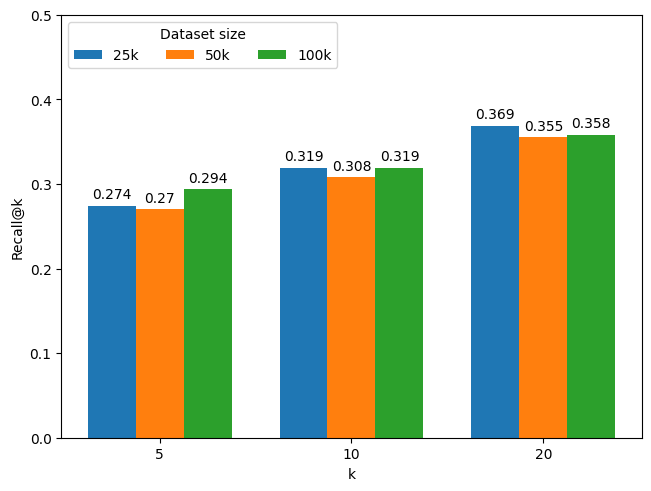

In [362]:
"""
[11]
Title: Grouped bar chart with labels
Author: matplotlib
Availability: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
"""
# Data for plot showing recall values for each dataset
ks = ("5", "10", "20")
recalls = {
    "25k": (0.2737120315581854, 0.31927895181741334, 0.36946627151200584),
    "50k": (0.2699016064257028, 0.30809758079938804, 0.35451890129962793),
    "100k": (0.2939248366013072, 0.31907814607324414, 0.3581541506095928)
}

# Create grouped bar plot
fig, ax = plt.subplots(layout="constrained")

# Create plot data
x = np.arange(len(ks))
bar_width = 0.25
multiplier = 0
for dataset, measurements in recalls.items():
    offset = bar_width * multiplier
    rects = ax.bar(x + offset, list(map(lambda x: round(x, 3), measurements)), bar_width, label=dataset)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Set plot features
ax.set_xlabel("k")
ax.set_ylabel("Recall@k")
# ax.set_title("")
ax.set_xticks(x + bar_width, ks)
ax.legend(title="Dataset size", loc="upper left", ncols=3)
ax.set_ylim(0, 0.5)

plt.savefig("../Data/rs2_recall_per_dataset.pdf")
plt.show()

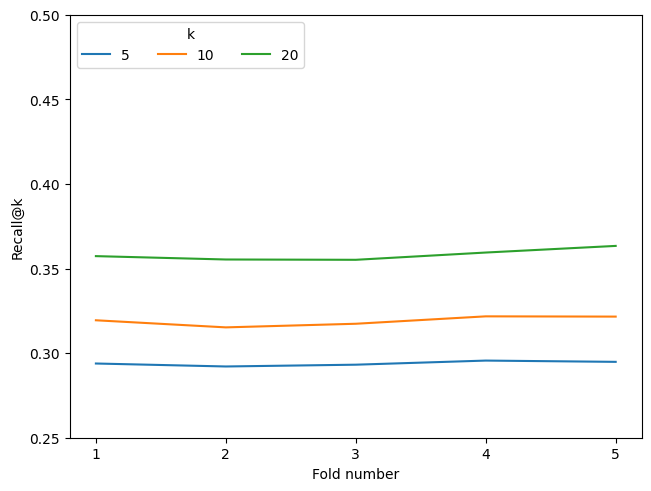

In [363]:
# Data for plot showing recall values for each cross validation fold in the 100k dataset
recall_at_5s = [0.29387254901960785, 0.29211873638344227, 0.2931753812636166, 0.29560457516339866, 0.2948529411764706]
recall_at_10s = [0.31943004979769685, 0.31523342670401494, 0.3173735605353252, 0.3217522564581388, 0.3216014368710447]
recall_at_20s = [0.35735320539526666, 0.3553630612528886, 0.35518202554166706, 0.35947652951348397, 0.3633959313446581]

# Plot data
fig, ax = plt.subplots(layout="constrained")
plt.plot(range(1, 6), recall_at_5s)
plt.plot(range(1, 6), recall_at_10s)
plt.plot(range(1, 6), recall_at_20s)

# Set plot features
plt.xticks(range(1, 6))
plt.xlabel("Fold number")
plt.ylabel("Recall@k")
plt.legend(["5", "10", "20"], title="k", loc="upper left", ncols=3)
plt.ylim(0.25, 0.5)

plt.savefig("../Data/rs2_recall_over_folds.pdf")
plt.show()

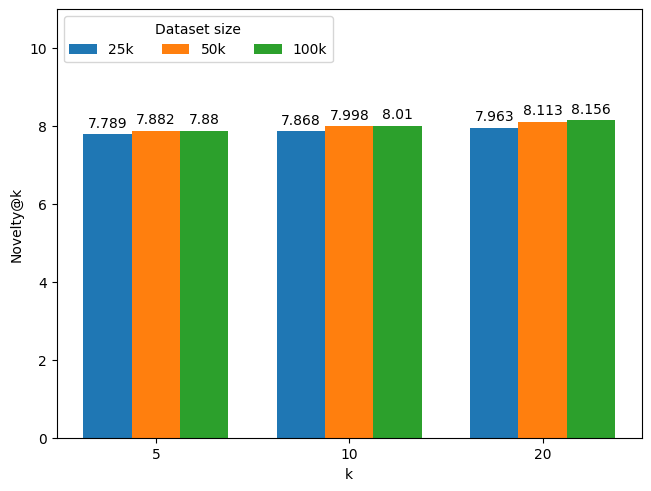

In [367]:
"""
[11]
Title: Grouped bar chart with labels
Author: matplotlib
Availability: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
"""
# Data for plot showing novelty values for each dataset
ks = ("5", "10", "20")
recalls = {
    "25k": (7.788833982637908, 7.868019468547179, 7.962510783385411),
    "50k": (7.882034438356419, 7.998232004142519, 8.11315526594088),
    "100k": (7.879675606560079, 8.010358116141173, 8.156396177045071)
}

# Create grouped bar plot
fig, ax = plt.subplots(layout="constrained")

# Create plot data
x = np.arange(len(ks))
bar_width = 0.25
multiplier = 0
for dataset, measurements in recalls.items():
    offset = bar_width * multiplier
    rects = ax.bar(x + offset, list(map(lambda x: round(x, 3), measurements)), bar_width, label=dataset)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Set plot features
ax.set_xlabel("k")
ax.set_ylabel("Novelty@k")
# ax.set_title("")
ax.set_xticks(x + bar_width, ks)
ax.legend(title="Dataset size", loc="upper left", ncols=3)
ax.set_ylim(0, 11)

plt.savefig("../Data/rs2_novelty_per_dataset.pdf")
plt.show()

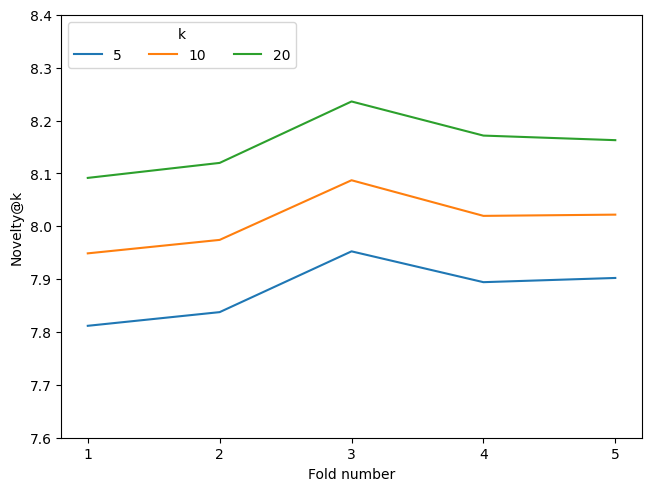

In [366]:
# Data for plot showing novelty values for each cross validation fold in the 100k dataset
novelty_at_5s = [7.811721098164705, 7.837591433415905, 7.95257221285936, 7.894264742185883, 7.902228546174542]
novelty_at_10s = [7.948772505415069, 7.974238657690528, 8.087076192817708, 8.019689732403902, 8.022013492378656]
novelty_at_20s = [8.091523124870047, 8.119885812979804, 8.236092398531307, 8.171573955358038, 8.162905593486158]

# Plot data
fig, ax = plt.subplots(layout="constrained")
plt.plot(range(1, 6), novelty_at_5s)
plt.plot(range(1, 6), novelty_at_10s)
plt.plot(range(1, 6), novelty_at_20s)

# Set plot features
plt.xticks(range(1, 6))
plt.xlabel("Fold number")
plt.ylabel("Novelty@k")
plt.legend(["5", "10", "20"], title="k", loc="upper left", ncols=3)
plt.ylim(7.6, 8.4)

plt.savefig("../Data/rs2_novelty_over_folds.pdf")
plt.show()

# RS2 Demo:

In [176]:
def demo2_recommendations(user_id, constraints, model, songs_data, k):
    """
    Function to make a set of recommendations for a user.
    Params:
    - string user_id: the user's unique ID
    - dict constraints: a dictionary of constraints to give the recommendations
    - model: a recommender systems model
    - songs_data: a pandas dataframe of all song content
    - int k: number of recommendations
    Return:
    - recommendations: a set of recommendations for the user
    """
    # Get user recommendations
    recommendations = model.get_k_recommendations(user_id, constraints, k)

    # If no recommendations, display error message
    if len(recommendations) == 0:
        print("No songs meet the constraints.")
        return

    # Merge the dataframe with that containing song content
    recommendations = recommendations.merge(songs_data)

    # Take the relevant columns from this dataframe
    recommendations = recommendations[["track_id", "track_name", "artist_name"]]

    # Get explanations for the recommendations
    for i, track_id in enumerate(recommendations["track_id"]):
        # Compare track profile to songs user has interacted with

        # Create explanation
        recommendations.loc[i, "explanation"] = "Because you liked "
        
        # Get similarity between song and all songs user has interacted with
        user_interacted_with_ids = model.cbf.training_songs.loc[user_id, "track_ids"]
        cosine_sims = cosine_similarity(model.cbf.all_song_profiles.loc[[track_id], :], model.cbf.all_song_profiles.loc[user_interacted_with_ids, :]).flatten()
        
        # Get the indices of the 3 most similar songs in descending order
        similar_indices = cosine_sims.argsort()[-3:][::-1]

        # Get a list of tuples containing these songs' IDs and similarity values
        similar_items = [user_interacted_with_ids[i] for i in similar_indices]

        for j, similar_track_id in enumerate(similar_items):
            song = model.songs_data[model.songs_data["track_id"] == similar_track_id]
            recommendations.loc[i, "explanation"] += "'" + song["track_name"].item() + "'" + " by " + song["artist_name"].item()
            if j != 2:
                recommendations.loc[i, "explanation"] += ", "
            elif j == 2:
                recommendations.loc[i, "explanation"] += "..."

    return recommendations

In [198]:
# Set up data
indexed_interactions_data_100k = interactions_data_100k.set_index("user_id")
transformed_songs_data_100k = cbf2_pre_processing(songs_data_100k, "100k", "../Data/song_embeddings_100k.pkl")

# Initialise parameters
key_weight = 0.5
mode_weight = 0
loud_tempo_weight = 1
genre_artist_weight = 1
embedding_len = 64
latent_dimensions = 64
num_layers = 3
cbf_weight = 0.6
cf_weight = 0.4

# Initialise model using full data and no test set
hybrid2 = Hybrid2(indexed_interactions_data_100k, None, interactions_data_100k, songs_data_100k, transformed_songs_data_100k, key_weight, mode_weight, loud_tempo_weight, genre_artist_weight, embedding_len, latent_dimensions, num_layers, ["../Data/user_embeddings_100k.pt", "../Data/track_embeddings_100k.pt"], cbf_weight, cf_weight)

Everything is same as the previous demo other than the recommendations and explanations, which now come from the CBF.

In [178]:
# Initialise constraints dictionary
constraints = {"key": [], "mode": [], "tempo": [], "genre": [], "artist": []}

In [185]:
user_id = "me"

print("Generating recommendations...", end="\r")
# Generate user recommendations
recs = demo2_recommendations(user_id, constraints, hybrid2, songs_data_100k, 10)

print("Your recommendations:        ")
# Display recommendations
for i, row in recs.iterrows():
    print(f"{str(i+1)+'.':<4}'{row['track_name']}' - {row['artist_name']}")

Your recommendations:        
1.  'Touch The Sky' - Kanye West
2.  'Monster' - Kanye West
3.  'Ni**as In Paris' - JAY Z
4.  'Heard 'Em Say' - Kanye West
5.  'Dark Fantasy' - Kanye West
6.  'Blame Game' - Kanye West
7.  'Blood On The Leaves' - Kanye West
8.  'Gorgeous' - Kanye West
9.  'Wet Dreamz' - J. Cole
10. 'Black Skinhead' - Kanye West


In [186]:
# User may ask to see explanations of the recommendations, in which case:

print("Explanations:")
# Display explanations
for i, row in recs.iterrows():
    print(f"{str(i+1)+'.':<4}{row['explanation']}")

Explanations:
1.  Because you liked 'Through The Wire' by Kanye West, 'Good Life' by Kanye West, 'Hey Mama' by Kanye West...
2.  Because you liked 'Lost In The World' by Kanye West, 'Good Life' by Kanye West, 'Flashing Lights' by Kanye West...
3.  Because you liked 'Run This Town' by JAY Z, 'Song Cry' by JAY Z, 'Lucifer' by JAY Z...
4.  Because you liked 'Through The Wire' by Kanye West, 'Hey Mama' by Kanye West, 'Diamonds From Sierra Leone - Remix - Album Version (Explicit)' by Kanye West...
5.  Because you liked 'Lost In The World' by Kanye West, 'Through The Wire' by Kanye West, 'Hey Mama' by Kanye West...
6.  Because you liked 'Everything I Am' by Kanye West, 'Through The Wire' by Kanye West, 'Hey Mama' by Kanye West...
7.  Because you liked 'All Of The Lights' by Kanye West, 'Bound 2' by Kanye West, 'Lost In The World' by Kanye West...
8.  Because you liked 'Flashing Lights' by Kanye West, 'Two Words' by Kanye West, 'Lost In The World' by Kanye West...
9.  Because you liked 'Nobod

In [200]:
# And with constraints...
constraints = {'key': ['key_0', 'key_2', 'key_4'],
 'mode': [],
 'tempo': [100.0, 140.0],
 'genre': ['genre_soul', 'genre_r&b', 'genre_pop'],
 'artist': []}

print("Generating recommendations...", end="\r")
# Generate user recommendations
recs = demo2_recommendations(user_id, constraints, hybrid2, songs_data_100k, 10)

print("Your recommendations:        ")
# Display recommendations
for i, row in recs.iterrows():
    print(f"{str(i+1)+'.':<4}'{row['track_name']}' - {row['artist_name']}")

print()

print("Explanations:")
# Display explanations
for i, row in recs.iterrows():
    print(f"{str(i+1)+'.':<4}{row['explanation']}")

Your recommendations:        
1.  'Good Times' - CHIC
2.  'Because Of You' - Ne-Yo
3.  'How You Remind Me' - Avril Lavigne
4.  'II. earth: the oldest computer (the last night)' - Childish Gambino
5.  'Live This Life' - Big Sean
6.  'All I Want' - B.o.B
7.  'FlyMuthaF**ka' - B.o.B
8.  'I Like' - Jeremih
9.  'III. urn' - Childish Gambino
10. 'I'm Sprung 2 Featuring Trick Daddy and YoungBloodz' - T-Pain

Explanations:
1.  Because you liked 'Mrs. Officer' by Lil Wayne, 'Song Cry' by JAY Z, 'Comfortable' by Lil Wayne...
2.  Because you liked 'Wus Good / Curious' by PARTYNEXTDOOR, 'Sober' by Childish Gambino, 'Lost' by Frank Ocean...
3.  Because you liked 'Take Care' by Drake, 'Uptown' by Drake, 'You & The 6' by Drake...
4.  Because you liked 'LES' by Childish Gambino, 'I. pink toes' by Childish Gambino, 'Sober' by Childish Gambino...
5.  Because you liked 'LES' by Childish Gambino, 'I. pink toes' by Childish Gambino, 'Comfortable' by Lil Wayne...
6.  Because you liked 'Sober' by Childish Ga

# Comparison:

In [17]:
def extract_from_output(output):
    """
    Function to extract the recall and novelty values from the output of the evaluation for a model.
    Params:
    - string output: the output from the evaluate_model function for a particular model
    Return:
    - list recs_at_5: the recall@5 values for each fold
    - list recs_at_10: the recall@10 values for each fold
    - list recs_at_20: the recall@20 values for each fold
    - list novs_at_5: the novelty@5 values for each fold
    - list novs_at_10: the novelty@10 values for each fold
    - list novs_at_20: the novelty@20 values for each fold
    """
    # Split output by spaces
    terms = []
    for term in output.split():
        if term not in ["Fold", "1.", "2.", "3.", "4.", "5.", "recall@5:", "recall@10:", "recall@20:", "novelty@5:", "novelty@10:", "novelty@20:"]:
            terms.append(float(term))

    # Get lists of the values for each fold for each metric term
    recs_at_5 = []
    recs_at_10 = []
    recs_at_20 = []
    novs_at_5 = []
    novs_at_10 = []
    novs_at_20 = []
    for i in range(30):
        if i % 6 == 0:
            recs_at_5.append(terms[i])
        if i % 6 == 1:
            recs_at_10.append(terms[i])
        if i % 6 == 2:
            recs_at_20.append(terms[i])
        if i % 6 == 3:
            novs_at_5.append(terms[i])
        if i % 6 == 4:
            novs_at_10.append(terms[i])
        if i % 6 == 5:
            novs_at_20.append(terms[i])

    return recs_at_5, recs_at_10, recs_at_20, novs_at_5, novs_at_10, novs_at_20


def compare(output1, output2):
    """
    Function to perform a t-test to compare the recall@10 and novelty@10 for two models.
    Params:
    - string output1: the output from the evaluate_model function for one model
    - string output2: the output from the evaluate_model function for another model
    Returns:
    - float recall_p: the p-value from the t-test for recall@10
    - float novelty_p: the p-value from the t-test for novelty@10
    """
    # Get list of recall@10 and novelty@10 for each model
    _, recs_at_10_1, _, _, novs_at_10_1, _ = extract_from_output(output1)
    _, recs_at_10_2, _, _, novs_at_10_2, _ = extract_from_output(output2)
    
    # Get p-value from t-test comparing the mean recall and the same for the mean novelty
    recall_p, novelty_p = ttest_ind(a = recs_at_10_1, b = recs_at_10_2, equal_var = False).pvalue, ttest_ind(a = novs_at_10_1, b = novs_at_10_2, equal_var = False).pvalue

    return recall_p, novelty_p

In [5]:
output_cbf_25k = """
Fold 1.
recall@5: 0.2503155818540434 	recall@10: 0.30637691368460596 	recall@20: 0.3509232159919594
novelty@5: 8.364564328380363 	novelty@10: 8.387959331367592 	novelty@20: 8.407386589321437

Fold 2.
recall@5: 0.24873767258382642 	recall@10: 0.2984155161078238 	recall@20: 0.3435934462030419
novelty@5: 8.379445251663846 	novelty@10: 8.390009460610019 	novelty@20: 8.425678905569521

Fold 3.
recall@5: 0.2459368836291913 	recall@10: 0.2866201746970978 	recall@20: 0.3347172331549107
novelty@5: 8.4074594025548 	novelty@10: 8.426240259663652 	novelty@20: 8.453757107909821

Fold 4.
recall@5: 0.2378698224852071 	recall@10: 0.2915966939043862 	recall@20: 0.332434148859305
novelty@5: 8.427364265034372 	novelty@10: 8.44573028012204 	novelty@20: 8.487738021024493

Fold 5.
recall@5: 0.2283826429980276 	recall@10: 0.28201653047806896 	recall@20: 0.3225810201018584
novelty@5: 8.440417394572815 	novelty@10: 8.463458777052095 	novelty@20: 8.512322676581872
"""

output_cbf2_25k = """
Fold 1.
recall@5: 0.23984220907297832 	recall@10: 0.29458110265802573 	recall@20: 0.33851948414614436
novelty@5: 8.609915181497541 	novelty@10: 8.64888535231958 	novelty@20: 8.66599300448606

Fold 2.
recall@5: 0.23721893491124263 	recall@10: 0.2853540903540904 	recall@20: 0.3328008436901122
novelty@5: 8.641132825940634 	novelty@10: 8.656196626595348 	novelty@20: 8.670539171948317

Fold 3.
recall@5: 0.23745562130177517 	recall@10: 0.2802296421527191 	recall@20: 0.33097142794268486
novelty@5: 8.612832337718494 	novelty@10: 8.644468988945325 	novelty@20: 8.667197399542907

Fold 4.
recall@5: 0.23690335305719923 	recall@10: 0.2876880811496196 	recall@20: 0.3281677661914257
novelty@5: 8.616112298320504 	novelty@10: 8.627136389827884 	novelty@20: 8.65544559655672

Fold 5.
recall@5: 0.22658777120315582 	recall@10: 0.2767601202216587 	recall@20: 0.3281148295782274
novelty@5: 8.59058861570553 	novelty@10: 8.622072197985212 	novelty@20: 8.653200045546654
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for CBF1 and CBF2 for the 25,000 entry dataset
compare(output_cbf_25k, output_cbf2_25k)

(0.16952555304805864, 2.2785045211670887e-05)

In [9]:
output_cbf_50k = """
Fold 1.
recall@5: 0.20714859437751001 	recall@10: 0.2627653471026965 	recall@20: 0.3236460737938087
novelty@5: 8.76236068580598 	novelty@10: 8.764683308444337 	novelty@20: 8.776182408354535

Fold 2.
recall@5: 0.19722891566265058 	recall@10: 0.2662401988908013 	recall@20: 0.3250347082703521
novelty@5: 8.775819251677175 	novelty@10: 8.782427641318245 	novelty@20: 8.807204477635526

Fold 3.
recall@5: 0.20646586345381526 	recall@10: 0.26398235800344233 	recall@20: 0.3148890885091882
novelty@5: 8.809880538808512 	novelty@10: 8.822931293008072 	novelty@20: 8.870433073228885

Fold 4.
recall@5: 0.20552208835341368 	recall@10: 0.25918316121629376 	recall@20: 0.3120815648577781
novelty@5: 8.815423795172014 	novelty@10: 8.858000840504031 	novelty@20: 8.930945739233506

Fold 5.
recall@5: 0.20024096385542167 	recall@10: 0.25396347293937654 	recall@20: 0.30408728394658957
novelty@5: 8.835402676351103 	novelty@10: 8.894249134617567 	novelty@20: 8.966733557389311
"""

output_cbf2_50k = """
Fold 1.
recall@5: 0.1826706827309237 	recall@10: 0.2362026678141136 	recall@20: 0.2911963164280483
novelty@5: 9.105181860032072 	novelty@10: 9.077384288639834 	novelty@20: 9.10847891092019

Fold 2.
recall@5: 0.18421686746987953 	recall@10: 0.24330799388028304 	recall@20: 0.3012500212143988
novelty@5: 9.086407650496005 	novelty@10: 9.059657376657414 	novelty@20: 9.09895833666496

Fold 3.
recall@5: 0.18825301204819278 	recall@10: 0.2434607477529164 	recall@20: 0.2970115921830831
novelty@5: 9.074230290573682 	novelty@10: 9.049357146780693 	novelty@20: 9.090489974985033

Fold 4.
recall@5: 0.19137550200803213 	recall@10: 0.2496612641040352 	recall@20: 0.3027925188737556
novelty@5: 9.067502286848418 	novelty@10: 9.038150228593297 	novelty@20: 9.080651713377616

Fold 5.
recall@5: 0.19174698795180722 	recall@10: 0.24709289539108817 	recall@20: 0.29773274719631354
novelty@5: 9.061801693327196 	novelty@10: 9.045026327071456 	novelty@20: 9.090821910339507
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for CBF1 and CBF2 for the 50,000 entry dataset
compare(output_cbf_50k, output_cbf2_50k)

(0.0005589557311030725, 0.000358421254682183)

In [10]:
output_cbf_100k = """
Fold 1.
recall@5: 0.19419934640522876 	recall@10: 0.2594128021579002 	recall@20: 0.3124109708860134
novelty@5: 8.893285816642763 	novelty@10: 8.903515410837972 	novelty@20: 8.949083715341002

Fold 2.
recall@5: 0.19678104575163402 	recall@10: 0.25295557111733585 	recall@20: 0.31024820846081397
novelty@5: 8.905514033902334 	novelty@10: 8.934502065113353 	novelty@20: 8.986939576912654

Fold 3.
recall@5: 0.19677015250544658 	recall@10: 0.2510434173669468 	recall@20: 0.30444649612519004
novelty@5: 8.93266334815008 	novelty@10: 8.977021163744867 	novelty@20: 9.05051427354832

Fold 4.
recall@5: 0.19501633986928105 	recall@10: 0.24407485216308744 	recall@20: 0.29256770544495153
novelty@5: 8.989546096087617 	novelty@10: 9.037049104268197 	novelty@20: 9.104684093756791

Fold 5.
recall@5: 0.1960294117647059 	recall@10: 0.24584798734308538 	recall@20: 0.2993374060389024
novelty@5: 9.01223272126292 	novelty@10: 9.077338377062416 	novelty@20: 9.147326790748734
"""

output_cbf2_100k = """
Fold 1.
recall@5: 0.1746949891067538 	recall@10: 0.23440203859321512 	recall@20: 0.2838553059534362
novelty@5: 9.287411203937488 	novelty@10: 9.325924136621625 	novelty@20: 9.384951234482898

Fold 2.
recall@5: 0.18196078431372548 	recall@10: 0.228833255524432 	recall@20: 0.2838860511187956
novelty@5: 9.281089343732667 	novelty@10: 9.315794533988743 	novelty@20: 9.380585312342259

Fold 3.
recall@5: 0.17960239651416118 	recall@10: 0.23258066189438736 	recall@20: 0.2841134036205896
novelty@5: 9.278519776102003 	novelty@10: 9.311892669358615 	novelty@20: 9.37905655992253

Fold 4.
recall@5: 0.17668300653594773 	recall@10: 0.23135128125324206 	recall@20: 0.28035314873762635
novelty@5: 9.264135916784532 	novelty@10: 9.30271218442601 	novelty@20: 9.372755074020034

Fold 5.
recall@5: 0.1792102396514161 	recall@10: 0.22999714700695092 	recall@20: 0.28005006078558253
novelty@5: 9.26962444154797 	novelty@10: 9.316702045182927 	novelty@20: 9.381647175006545
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for CBF1 and CBF2 for the 100,000 entry dataset
compare(output_cbf_100k, output_cbf2_100k)

(0.0011585480217478003, 0.00045248589769427626)

In [11]:
output_cf_25k = """
Fold 1.
recall@5: 0.15483234714003943 	recall@10: 0.17101296139757677 	recall@20: 0.20240711684388749
novelty@5: 8.180619452484283 	novelty@10: 8.14193824172694 	novelty@20: 8.085207503278381

Fold 2.
recall@5: 0.1449506903353057 	recall@10: 0.16848736733352115 	recall@20: 0.20346436107253696
novelty@5: 8.170359489126872 	novelty@10: 8.156461873286197 	novelty@20: 8.120327949924885

Fold 3.
recall@5: 0.14625246548323473 	recall@10: 0.16590917629379168 	recall@20: 0.19400007857873283
novelty@5: 8.17174247504877 	novelty@10: 8.155562893820996 	novelty@20: 8.109322229816376

Fold 4.
recall@5: 0.1473767258382643 	recall@10: 0.17087395510472433 	recall@20: 0.19424910392782777
novelty@5: 8.187851496923708 	novelty@10: 8.16743532287483 	novelty@20: 8.118521028633028

Fold 5.
recall@5: 0.14877712031558185 	recall@10: 0.1736991640837795 	recall@20: 0.19980750967309122
novelty@5: 8.173875076524233 	novelty@10: 8.126360417395594 	novelty@20: 8.080684247773299
"""

output_cf2_25k = """
Fold 1.
recall@5: 0.15203155818540431 	recall@10: 0.17957687611533765 	recall@20: 0.21206744908720654
novelty@5: 7.498030201679797 	novelty@10: 7.526324539759669 	novelty@20: 7.547390353074274

Fold 2.
recall@5: 0.14777120315581854 	recall@10: 0.17721236028928336 	recall@20: 0.21067930584019579
novelty@5: 7.542022771985589 	novelty@10: 7.555002960516091 	novelty@20: 7.579076863967374

Fold 3.
recall@5: 0.14972386587771203 	recall@10: 0.18340095801634265 	recall@20: 0.21397066458129532
novelty@5: 7.474378295926864 	novelty@10: 7.508056837846867 	novelty@20: 7.551672195979543

Fold 4.
recall@5: 0.15130177514792897 	recall@10: 0.17466939043862117 	recall@20: 0.21301919987751777
novelty@5: 7.545161941905845 	novelty@10: 7.555183873216223 	novelty@20: 7.576102433503898

Fold 5.
recall@5: 0.1545956607495069 	recall@10: 0.18361792054099746 	recall@20: 0.20914526082995682
novelty@5: 7.517435731836175 	novelty@10: 7.540624835041854 	novelty@20: 7.554585045768008
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for CF1 and CF2 for the 25,000 entry dataset
compare(output_cf_25k, output_cf2_25k)

(0.0025609952733610395, 4.791398373380002e-11)

In [12]:
output_cf_50k = """
Fold 1.
recall@5: 0.21269076305220883 	recall@10: 0.22602074966532798 	recall@20: 0.2604181625897281
novelty@5: 7.959594085780844 	novelty@10: 8.024171779168203 	novelty@20: 8.058547952766398

Fold 2.
recall@5: 0.2166265060240964 	recall@10: 0.23917838018741633 	recall@20: 0.2730751333196874
novelty@5: 7.956401231803296 	novelty@10: 8.021834785784765 	novelty@20: 8.064729240339348

Fold 3.
recall@5: 0.2116566265060241 	recall@10: 0.2345795085102314 	recall@20: 0.2605194517540185
novelty@5: 7.995242730186788 	novelty@10: 8.053202302404204 	novelty@20: 8.070441023867708

Fold 4.
recall@5: 0.22078313253012047 	recall@10: 0.23810025817555938 	recall@20: 0.2652621264914478
novelty@5: 7.987815157293964 	novelty@10: 8.060382407313647 	novelty@20: 8.075722143598528

Fold 5.
recall@5: 0.2112550200803213 	recall@10: 0.2414656244023714 	recall@20: 0.27303690314342055
novelty@5: 8.016031886987394 	novelty@10: 8.052182320330244 	novelty@20: 8.067693618488072
"""

output_cf2_50k = """
Fold 1.
recall@5: 0.20452811244979918 	recall@10: 0.2301972174411933 	recall@20: 0.2617794738288556
novelty@5: 7.41172526079051 	novelty@10: 7.445412659798348 	novelty@20: 7.494993111765762

Fold 2.
recall@5: 0.2069277108433735 	recall@10: 0.2350882099827883 	recall@20: 0.2727377933197807
novelty@5: 7.40818251299895 	novelty@10: 7.456369283586192 	novelty@20: 7.50398602545776

Fold 3.
recall@5: 0.2070883534136546 	recall@10: 0.23530742015681774 	recall@20: 0.2726530147880021
novelty@5: 7.433443589733133 	novelty@10: 7.471786804736294 	novelty@20: 7.516452351205761

Fold 4.
recall@5: 0.22086345381526104 	recall@10: 0.24137693631669538 	recall@20: 0.27628447826051705
novelty@5: 7.413982014023124 	novelty@10: 7.461760906603426 	novelty@20: 7.493506678730864

Fold 5.
recall@5: 0.21145582329317267 	recall@10: 0.24061173264486516 	recall@20: 0.2776369448549966
novelty@5: 7.419518975077195 	novelty@10: 7.468860087672348 	novelty@20: 7.500331618317802
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for CF1 and CF2 for the 50,000 entry dataset
compare(output_cf_50k, output_cf2_50k)

(0.8536096367993965, 3.166185555004756e-10)

In [13]:
output_cf_100k = """
Fold 1.
recall@5: 0.2880664488017429 	recall@10: 0.30640237576512086 	recall@20: 0.34024246960020643
novelty@5: 7.578755328990478 	novelty@10: 7.692916436996975 	novelty@20: 7.800391907750963

Fold 2.
recall@5: 0.2828322440087146 	recall@10: 0.30239353148666875 	recall@20: 0.339846293328241
novelty@5: 7.589237729966652 	novelty@10: 7.700133994988545 	novelty@20: 7.799138263623265

Fold 3.
recall@5: 0.2862418300653595 	recall@10: 0.3055442732648615 	recall@20: 0.3398961369845544
novelty@5: 7.577022140228005 	novelty@10: 7.685435158200818 	novelty@20: 7.7917365810836605

Fold 4.
recall@5: 0.28944989106753816 	recall@10: 0.3089953574022201 	recall@20: 0.34502527949672523
novelty@5: 7.577655954966513 	novelty@10: 7.69408169256797 	novelty@20: 7.799297536998938

Fold 5.
recall@5: 0.2832897603485839 	recall@10: 0.30244955389563233 	recall@20: 0.34199101777214447
novelty@5: 7.597853964771603 	novelty@10: 7.702930728831693 	novelty@20: 7.801874684295361
"""

output_cf2_100k = """
Fold 1.
recall@5: 0.2693899782135076 	recall@10: 0.2950055763045959 	recall@20: 0.3312336985615229
novelty@5: 7.2540920323567315 	novelty@10: 7.308537062273983 	novelty@20: 7.3794139326888954

Fold 2.
recall@5: 0.26561546840958605 	recall@10: 0.2909028426185289 	recall@20: 0.3368431094967321
novelty@5: 7.262890290662547 	novelty@10: 7.315380309660305 	novelty@20: 7.384617032596032

Fold 3.
recall@5: 0.26903050108932464 	recall@10: 0.29599984438219734 	recall@20: 0.3352999396078221
novelty@5: 7.246274787914834 	novelty@10: 7.297551028986522 	novelty@20: 7.365764191556026

Fold 4.
recall@5: 0.26948801742919387 	recall@10: 0.2930053688141923 	recall@20: 0.3348980775660798
novelty@5: 7.251163051374929 	novelty@10: 7.3184214271499775 	novelty@20: 7.385469471984721

Fold 5.
recall@5: 0.2647058823529412 	recall@10: 0.2903278348376388 	recall@20: 0.3327944819788291
novelty@5: 7.266108701275143 	novelty@10: 7.320889561285353 	novelty@20: 7.386064898687429
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for CF1 and CF2 for the 100,000 entry dataset
compare(output_cf_100k, output_cf2_100k)

(9.583622827087237e-05, 9.225911224830511e-12)

In [14]:
output_hybrid_25k = """
Fold 1.
recall@5: 0.2505325443786982 	recall@10: 0.29583591622053157 	recall@20: 0.3458962646029622
novelty@5: 8.10454779445609 	novelty@10: 8.10215459727443 	novelty@20: 8.071949072597599

Fold 2.
recall@5: 0.25564102564102564 	recall@10: 0.30163238470930775 	recall@20: 0.34936602460055843
novelty@5: 8.113247842563434 	novelty@10: 8.121536495011314 	novelty@20: 8.104895037564372

Fold 3.
recall@5: 0.23919132149901381 	recall@10: 0.28479242979242975 	recall@20: 0.33475588588779454
novelty@5: 8.096836035316635 	novelty@10: 8.112184543696285 	novelty@20: 8.100077523391866

Fold 4.
recall@5: 0.24927021696252463 	recall@10: 0.2904052784822016 	recall@20: 0.33787637457650466
novelty@5: 8.112271382005533 	novelty@10: 8.13291653670011 	novelty@20: 8.11242867272504

Fold 5.
recall@5: 0.24571992110453647 	recall@10: 0.296045834507373 	recall@20: 0.3429713184900317
novelty@5: 8.097248447035122 	novelty@10: 8.103260877744301 	novelty@20: 8.08906161670017
"""

output_hybrid2_25k = """
Fold 1.
recall@5: 0.28459566074950693 	recall@10: 0.32245092514323287 	recall@20: 0.37399280469287977
novelty@5: 7.757387107455903 	novelty@10: 7.82797637231218 	novelty@20: 7.9197589521473875

Fold 2.
recall@5: 0.27548323471400393 	recall@10: 0.3263365267211421 	recall@20: 0.3695233156488584
novelty@5: 7.825273871181488 	novelty@10: 7.910593476022586 	novelty@20: 7.996030179950694

Fold 3.
recall@5: 0.27633136094674554 	recall@10: 0.3160707241476472 	recall@20: 0.3701126305998803
novelty@5: 7.7503958950288165 	novelty@10: 7.83191397368807 	novelty@20: 7.932036310828098

Fold 4.
recall@5: 0.26755424063116373 	recall@10: 0.3197792805485113 	recall@20: 0.3654062344695645
novelty@5: 7.84376535797242 	novelty@10: 7.919576267624849 	novelty@20: 8.01256600673921

Fold 5.
recall@5: 0.26459566074950686 	recall@10: 0.3117573025265333 	recall@20: 0.3682963721488462
novelty@5: 7.7673476815509135 	novelty@10: 7.850037253088211 	novelty@20: 7.952162467261662
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for RS1 and RS2 for the 25,000 entry dataset
compare(output_hybrid_25k, output_hybrid2_25k)

(0.00016309485146967075, 0.0001045279547002878)

In [15]:
output_hybrid_50k = """
Fold 1.
recall@5: 0.2717771084337349 	recall@10: 0.30358601070950464 	recall@20: 0.3564064198051151
novelty@5: 7.968006133087778 	novelty@10: 8.050228263325002 	novelty@20: 8.099846183120784

Fold 2.
recall@5: 0.2822289156626506 	recall@10: 0.3171696309045707 	recall@20: 0.35731628050343317
novelty@5: 7.985313438674764 	novelty@10: 8.062151629014258 	novelty@20: 8.105216529302593

Fold 3.
recall@5: 0.2735542168674699 	recall@10: 0.31281506980302154 	recall@20: 0.36017917749843126
novelty@5: 7.9997855143232 	novelty@10: 8.09066611538472 	novelty@20: 8.121752989947153

Fold 4.
recall@5: 0.27589357429718875 	recall@10: 0.3114254637598011 	recall@20: 0.35566162394764733
novelty@5: 7.994097741023597 	novelty@10: 8.079817645237064 	novelty@20: 8.116519456498262

Fold 5.
recall@5: 0.2773995983935743 	recall@10: 0.3167706540447504 	recall@20: 0.36468970105081117
novelty@5: 8.019370589601907 	novelty@10: 8.082896348611646 	novelty@20: 8.119348767688733
"""

output_hybrid2_50k = """
Fold 1.
recall@5: 0.26339357429718874 	recall@10: 0.30311292790208455 	recall@20: 0.34773930704658257
novelty@5: 7.80369101715054 	novelty@10: 7.910271881694606 	novelty@20: 8.031534802574985

Fold 2.
recall@5: 0.2746285140562249 	recall@10: 0.3137150984891949 	recall@20: 0.3590117116177161
novelty@5: 7.858928284824292 	novelty@10: 7.988561151298171 	novelty@20: 8.100382273502856

Fold 3.
recall@5: 0.2668975903614458 	recall@10: 0.3041979824058137 	recall@20: 0.3502173233191268
novelty@5: 7.926182037043825 	novelty@10: 8.048073317125773 	novelty@20: 8.163094913452644

Fold 4.
recall@5: 0.27380522088353415 	recall@10: 0.30822217441193345 	recall@20: 0.3560679025949784
novelty@5: 7.884302021868387 	novelty@10: 8.001342059123898 	novelty@20: 8.107681184481569

Fold 5.
recall@5: 0.2707831325301205 	recall@10: 0.31123972078791357 	recall@20: 0.35955826191973567
novelty@5: 7.937068830895048 	novelty@10: 8.04291161147015 	novelty@20: 8.163083155692354
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for RS1 and RS2 for the 50,000 entry dataset
compare(output_hybrid_50k, output_hybrid2_50k)

(0.21881464099953313, 0.03661185682979568)

In [16]:
output_hybrid_100k = """
Fold 1.
recall@5: 0.32312636165577346 	recall@10: 0.3502205882352941 	recall@20: 0.3907174906574682
novelty@5: 7.786688395332868 	novelty@10: 7.891214512987618 	novelty@20: 7.9787330716474685

Fold 2.
recall@5: 0.31443899782135076 	recall@10: 0.347338546529723 	recall@20: 0.39103201069274335
novelty@5: 7.790738729112101 	novelty@10: 7.879807328705335 	novelty@20: 7.964964930726302

Fold 3.
recall@5: 0.3251960784313725 	recall@10: 0.3504226320157693 	recall@20: 0.39243908018057383
novelty@5: 7.77124256126987 	novelty@10: 7.878025899073667 	novelty@20: 7.956653158280555

Fold 4.
recall@5: 0.3225980392156863 	recall@10: 0.34996744994294016 	recall@20: 0.39011352169872926
novelty@5: 7.7582293304175955 	novelty@10: 7.8738912466753845 	novelty@20: 7.959052548552521

Fold 5.
recall@5: 0.31519607843137254 	recall@10: 0.3457967631497043 	recall@20: 0.39295661743162963
novelty@5: 7.789338691694683 	novelty@10: 7.897325385859309 	novelty@20: 7.979418536733614
"""

output_hybrid2_100k = """
Fold 1.
recall@5: 0.29387254901960785 	recall@10: 0.31943004979769685 	recall@20: 0.35735320539526666
novelty@5: 7.811721098164705 	novelty@10: 7.948772505415069 	novelty@20: 8.091523124870047

Fold 2.
recall@5: 0.29211873638344227 	recall@10: 0.31523342670401494 	recall@20: 0.3553630612528886
novelty@5: 7.837591433415905 	novelty@10: 7.974238657690528 	novelty@20: 8.119885812979804

Fold 3.
recall@5: 0.2931753812636166 	recall@10: 0.3173735605353252 	recall@20: 0.35518202554166706
novelty@5: 7.95257221285936 	novelty@10: 8.087076192817708 	novelty@20: 8.236092398531307

Fold 4.
recall@5: 0.29560457516339866 	recall@10: 0.3217522564581388 	recall@20: 0.35947652951348397
novelty@5: 7.894264742185883 	novelty@10: 8.019689732403902 	novelty@20: 8.171573955358038

Fold 5.
recall@5: 0.2948529411764706 	recall@10: 0.3216014368710447 	recall@20: 0.3633959313446581
novelty@5: 7.902228546174542 	novelty@10: 8.022013492378656 	novelty@20: 8.162905593486158
"""

# Get t-test p-values comparing the mean recall@10 and novelty@10 for RS1 and RS2 for the 100,000 entry dataset
compare(output_hybrid_100k, output_hybrid2_100k)

(1.539351098996353e-07, 0.0052432930813209044)